In [1]:
#!/usr/bin/env python3
from argparse import ArgumentParser
import numpy as np
import torch
from data import PermutedMNIST
from train import train
from model import MLP
import utils
import random
import matplotlib.pyplot as plt


task_number = 5
hidden_size1=256
hidden_size2 = 128
hidden_dropout_prob=0.5
input_dropout_prob=0.2
lamda=1000

epochs_per_task =100
batch_size = 128
test_size= 8192
fisher_estimation_sample_size = 2048
lr=1.e-1
weight_decay = 0
eval_log_interval = 250
loss_log_interval= 250
cuda=False


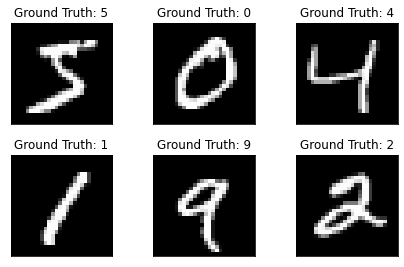

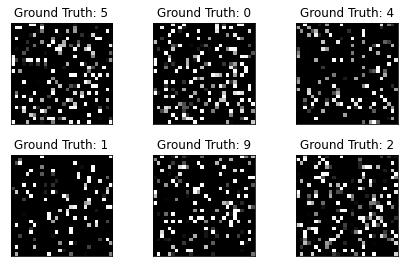

In [2]:
def imshow(img,labels):
    fig = plt.figure()
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.tight_layout()
        plt.imshow(img[i].view(28,28), cmap='gray', interpolation='none')
        plt.title("Ground Truth: {}".format(labels[i]))
        plt.xticks([])
        plt.yticks([])
            
            
def get_permute_mnist():
   
    train_loader = {}
    test_loader = {}
    idx = list(range(28 * 28))
    for i in range(task_number):
        train_loader[i] = torch.utils.data.DataLoader(PermutedMNIST(train = True, permute_idx=idx),
                                                      batch_size=batch_size,
                                                      num_workers=4)
        test_loader[i] = torch.utils.data.DataLoader(PermutedMNIST(train = False, permute_idx= idx),
                                                     batch_size=batch_size)
        random.shuffle(idx)
    return train_loader, test_loader


train_loader, test_loader = get_permute_mnist()

#unpermuted data:
examples_unpermuted = enumerate(train_loader[0])

_, (example_data_unpermuted, example_targets_unpermuted) = next(examples_unpermuted)

imshow(example_data_unpermuted[:6], example_targets_unpermuted[:6])

#permuted data:
examples_permuted = enumerate(train_loader[1])

_, (example_data_permuted, example_targets_permuted) = next(examples_permuted)
imshow(example_data_permuted[:6], example_targets_permuted[:6])

In [3]:
#could also cut last 5 items which are ignored by early stopping
def loss_plot(x):
    num_epochs = 0
    for task in range(1, task_number+1):
        plt.plot(range(num_epochs+1, num_epochs + 1 + len(x[task])), x[task] )
        num_epochs+= len(x[task])
        
def accuracy_plot(x):
    total_epochs = len(x[1])
    for task in range(1, task_number + 1):
        plt.plot(range(total_epochs+1 - len(x[task]), total_epochs+1), x[task] )



In [4]:
def avg_precision_plot(precisions, labels = []): #precisions needs to be in the form of the return value of train
    for num, precision in enumerate(precisions):    
        avg_precisions = []
        total_epochs = task_number*epochs_per_task
        for epoch in range (total_epochs):
            avg_precision = 0
            tasks_considered = epoch // epochs_per_task +1 #gives 1 for first task, 2 for second,...
            for i in range(1,tasks_considered+1): #
                avg_precision += precision[i][epoch - (i-1)*epochs_per_task]
            avg_precision/=tasks_considered
            avg_precisions.append(avg_precision)
        plt.ylim(0.88, 0.94)
        if (len(labels) == len(precisions)):
            plt.plot(range(total_epochs), avg_precisions, label = labels[num])
        else:
            plt.plot(range(total_epochs), avg_precisions)
    plt.legend()
    

In [5]:
# prepare the model.
mlp_no_dropout = MLP( 28*28, 10,
    hidden_size1,
    hidden_size2,
    0,
    0,
    lamda,
)

# initialize the parameters.
utils.gaussian_initialize(mlp_no_dropout)

# prepare the cuda if needed.
if cuda:
    mlp_no_dropout.cuda()


In [6]:
# run the standard experiment.
consolidate = False
standard_prec_no_dropout, standard_total_loss_no_dropout, standard_ce_loss_no_dropout, standard_ewc_loss_no_dropout = train(
    mlp_no_dropout, train_loader, test_loader,
    epochs_per_task,
    batch_size,
    test_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    eval_log_interval,
    loss_log_interval,
    cuda
)

=> task: 1/5 | epoch: 1/100 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.3783 / ewc: 0.0 / total: 0.3783: : 469it [00:04, 107.64it/s]  


Validation loss decreased (inf --> 0.321097).  Saving model ...


=> task: 1/5 | epoch: 2/100 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.3011 / ewc: 0.0 / total: 0.3011: : 469it [00:04, 103.05it/s]  


Validation loss decreased (0.321097 --> 0.224553).  Saving model ...


=> task: 1/5 | epoch: 3/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2619 / ewc: 0.0 / total: 0.2619: : 469it [00:04, 113.69it/s]  


Validation loss decreased (0.224553 --> 0.175614).  Saving model ...


=> task: 1/5 | epoch: 4/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2404 / ewc: 0.0 / total: 0.2404: : 469it [00:04, 114.05it/s]  


Validation loss decreased (0.175614 --> 0.144688).  Saving model ...


=> task: 1/5 | epoch: 5/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.219 / ewc: 0.0 / total: 0.219: : 469it [00:04, 114.64it/s]    


Validation loss decreased (0.144688 --> 0.123661).  Saving model ...


=> task: 1/5 | epoch: 6/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2061 / ewc: 0.0 / total: 0.2061: : 469it [00:04, 114.00it/s] 


Validation loss decreased (0.123661 --> 0.109342).  Saving model ...


=> task: 1/5 | epoch: 7/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1977 / ewc: 0.0 / total: 0.1977: : 469it [00:03, 117.59it/s]  


Validation loss decreased (0.109342 --> 0.098685).  Saving model ...


=> task: 1/5 | epoch: 8/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1921 / ewc: 0.0 / total: 0.1921: : 469it [00:03, 118.24it/s]  


Validation loss decreased (0.098685 --> 0.091287).  Saving model ...


=> task: 1/5 | epoch: 9/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1832 / ewc: 0.0 / total: 0.1832: : 469it [00:04, 114.75it/s] 


Validation loss decreased (0.091287 --> 0.085794).  Saving model ...


=> task: 1/5 | epoch: 10/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1728 / ewc: 0.0 / total: 0.1728: : 469it [00:03, 117.40it/s] 


Validation loss decreased (0.085794 --> 0.081983).  Saving model ...


=> task: 1/5 | epoch: 11/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1659 / ewc: 0.0 / total: 0.1659: : 469it [00:03, 118.16it/s] 


Validation loss decreased (0.081983 --> 0.079612).  Saving model ...


=> task: 1/5 | epoch: 12/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1596 / ewc: 0.0 / total: 0.1596: : 469it [00:04, 114.83it/s] 


Validation loss decreased (0.079612 --> 0.077884).  Saving model ...


=> task: 1/5 | epoch: 13/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1523 / ewc: 0.0 / total: 0.1523: : 469it [00:04, 116.15it/s] 


Validation loss decreased (0.077884 --> 0.076277).  Saving model ...


=> task: 1/5 | epoch: 14/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1444 / ewc: 0.0 / total: 0.1444: : 469it [00:04, 116.83it/s] 


Validation loss decreased (0.076277 --> 0.074622).  Saving model ...


=> task: 1/5 | epoch: 15/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1387 / ewc: 0.0 / total: 0.1387: : 469it [00:03, 118.10it/s] 


Validation loss decreased (0.074622 --> 0.073464).  Saving model ...


=> task: 1/5 | epoch: 16/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1314 / ewc: 0.0 / total: 0.1314: : 469it [00:04, 115.70it/s] 


Validation loss decreased (0.073464 --> 0.072424).  Saving model ...


=> task: 1/5 | epoch: 17/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1254 / ewc: 0.0 / total: 0.1254: : 469it [00:04, 117.15it/s]  


Validation loss decreased (0.072424 --> 0.071883).  Saving model ...


=> task: 1/5 | epoch: 18/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.12 / ewc: 0.0 / total: 0.12: : 469it [00:04, 117.17it/s]      


Validation loss decreased (0.071883 --> 0.070941).  Saving model ...


=> task: 1/5 | epoch: 19/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1138 / ewc: 0.0 / total: 0.1138: : 469it [00:03, 117.49it/s]  


Validation loss decreased (0.070941 --> 0.070035).  Saving model ...


=> task: 1/5 | epoch: 20/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1085 / ewc: 0.0 / total: 0.1085: : 469it [00:04, 114.37it/s] 


EarlyStopping counter: 1 out of 5


=> task: 1/5 | epoch: 21/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1012 / ewc: 0.0 / total: 0.1012: : 469it [00:04, 106.56it/s] 


Validation loss decreased (0.070035 --> 0.069651).  Saving model ...


=> task: 1/5 | epoch: 22/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09543 / ewc: 0.0 / total: 0.09543: : 469it [00:04, 96.64it/s] 


EarlyStopping counter: 1 out of 5


=> task: 1/5 | epoch: 23/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0881 / ewc: 0.0 / total: 0.0881: : 469it [00:04, 102.88it/s]  


Validation loss decreased (0.069651 --> 0.069425).  Saving model ...


=> task: 1/5 | epoch: 24/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08152 / ewc: 0.0 / total: 0.08152: : 469it [00:04, 106.95it/s]


EarlyStopping counter: 1 out of 5


=> task: 1/5 | epoch: 25/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0729 / ewc: 0.0 / total: 0.0729: : 469it [00:04, 112.34it/s]  


EarlyStopping counter: 2 out of 5


=> task: 1/5 | epoch: 26/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06506 / ewc: 0.0 / total: 0.06506: : 469it [00:03, 117.95it/s]


EarlyStopping counter: 3 out of 5


=> task: 1/5 | epoch: 27/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05565 / ewc: 0.0 / total: 0.05565: : 469it [00:04, 100.45it/s] 


EarlyStopping counter: 4 out of 5


=> task: 1/5 | epoch: 28/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04793 / ewc: 0.0 / total: 0.04793: : 469it [00:03, 118.23it/s]


EarlyStopping counter: 5 out of 5
Early stopping


=> task: 2/5 | epoch: 1/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2103 / ewc: 0.0 / total: 0.2103: : 469it [00:04, 111.15it/s]  


Validation loss decreased (inf --> 0.155639).  Saving model ...


=> task: 2/5 | epoch: 2/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1838 / ewc: 0.0 / total: 0.1838: : 469it [00:03, 118.48it/s] 


Validation loss decreased (0.155639 --> 0.110471).  Saving model ...


=> task: 2/5 | epoch: 3/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1851 / ewc: 0.0 / total: 0.1851: : 469it [00:03, 118.78it/s] 


Validation loss decreased (0.110471 --> 0.097320).  Saving model ...


=> task: 2/5 | epoch: 4/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1795 / ewc: 0.0 / total: 0.1795: : 469it [00:04, 117.03it/s] 


Validation loss decreased (0.097320 --> 0.089374).  Saving model ...


=> task: 2/5 | epoch: 5/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1757 / ewc: 0.0 / total: 0.1757: : 469it [00:03, 118.77it/s] 


Validation loss decreased (0.089374 --> 0.083490).  Saving model ...


=> task: 2/5 | epoch: 6/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1758 / ewc: 0.0 / total: 0.1758: : 469it [00:03, 119.09it/s] 


Validation loss decreased (0.083490 --> 0.079233).  Saving model ...


=> task: 2/5 | epoch: 7/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1743 / ewc: 0.0 / total: 0.1743: : 469it [00:03, 118.31it/s] 


Validation loss decreased (0.079233 --> 0.077183).  Saving model ...


=> task: 2/5 | epoch: 8/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.17 / ewc: 0.0 / total: 0.17: : 469it [00:03, 119.91it/s]       


Validation loss decreased (0.077183 --> 0.075160).  Saving model ...


=> task: 2/5 | epoch: 9/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1674 / ewc: 0.0 / total: 0.1674: : 469it [00:03, 121.01it/s] 


Validation loss decreased (0.075160 --> 0.074958).  Saving model ...


=> task: 2/5 | epoch: 10/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1611 / ewc: 0.0 / total: 0.1611: : 469it [00:03, 120.55it/s] 


Validation loss decreased (0.074958 --> 0.074059).  Saving model ...


=> task: 2/5 | epoch: 11/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1603 / ewc: 0.0 / total: 0.1603: : 469it [00:03, 120.73it/s] 


Validation loss decreased (0.074059 --> 0.073663).  Saving model ...


=> task: 2/5 | epoch: 12/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.156 / ewc: 0.0 / total: 0.156: : 469it [00:03, 120.08it/s]   


Validation loss decreased (0.073663 --> 0.073262).  Saving model ...


=> task: 2/5 | epoch: 13/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1503 / ewc: 0.0 / total: 0.1503: : 469it [00:03, 118.27it/s]   


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 14/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1495 / ewc: 0.0 / total: 0.1495: : 469it [00:03, 120.03it/s]   


Validation loss decreased (0.073262 --> 0.072870).  Saving model ...


=> task: 2/5 | epoch: 15/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1426 / ewc: 0.0 / total: 0.1426: : 469it [00:03, 119.05it/s]  


Validation loss decreased (0.072870 --> 0.071875).  Saving model ...


=> task: 2/5 | epoch: 16/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1352 / ewc: 0.0 / total: 0.1352: : 469it [00:03, 119.41it/s]  


Validation loss decreased (0.071875 --> 0.071730).  Saving model ...


=> task: 2/5 | epoch: 17/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1288 / ewc: 0.0 / total: 0.1288: : 469it [00:03, 120.08it/s]  


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 18/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1199 / ewc: 0.0 / total: 0.1199: : 469it [00:03, 119.67it/s]   


EarlyStopping counter: 2 out of 5


=> task: 2/5 | epoch: 19/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.111 / ewc: 0.0 / total: 0.111: : 469it [00:03, 120.85it/s]     


Validation loss decreased (0.071730 --> 0.071676).  Saving model ...


=> task: 2/5 | epoch: 20/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1015 / ewc: 0.0 / total: 0.1015: : 469it [00:03, 118.64it/s]   


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 21/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09291 / ewc: 0.0 / total: 0.09291: : 469it [00:03, 119.58it/s] 


EarlyStopping counter: 2 out of 5


=> task: 2/5 | epoch: 22/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08236 / ewc: 0.0 / total: 0.08236: : 469it [00:03, 119.47it/s] 


EarlyStopping counter: 3 out of 5


=> task: 2/5 | epoch: 23/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07393 / ewc: 0.0 / total: 0.07393: : 469it [00:03, 119.80it/s] 


EarlyStopping counter: 4 out of 5


=> task: 2/5 | epoch: 24/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0641 / ewc: 0.0 / total: 0.0641: : 469it [00:03, 120.60it/s]   


EarlyStopping counter: 5 out of 5
Early stopping


=> task: 3/5 | epoch: 1/100 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2379 / ewc: 0.0 / total: 0.2379: : 469it [00:03, 121.08it/s] 


Validation loss decreased (inf --> 0.183795).  Saving model ...


=> task: 3/5 | epoch: 2/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2287 / ewc: 0.0 / total: 0.2287: : 469it [00:03, 119.66it/s] 


Validation loss decreased (0.183795 --> 0.136768).  Saving model ...


=> task: 3/5 | epoch: 3/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1985 / ewc: 0.0 / total: 0.1985: : 469it [00:03, 121.35it/s] 


Validation loss decreased (0.136768 --> 0.111810).  Saving model ...


=> task: 3/5 | epoch: 4/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1901 / ewc: 0.0 / total: 0.1901: : 469it [00:03, 120.85it/s] 


Validation loss decreased (0.111810 --> 0.103179).  Saving model ...


=> task: 3/5 | epoch: 5/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1796 / ewc: 0.0 / total: 0.1796: : 469it [00:03, 120.59it/s] 


Validation loss decreased (0.103179 --> 0.092483).  Saving model ...


=> task: 3/5 | epoch: 6/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1638 / ewc: 0.0 / total: 0.1638: : 469it [00:03, 119.79it/s] 


Validation loss decreased (0.092483 --> 0.087253).  Saving model ...


=> task: 3/5 | epoch: 7/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1533 / ewc: 0.0 / total: 0.1533: : 469it [00:03, 119.94it/s] 


Validation loss decreased (0.087253 --> 0.084039).  Saving model ...


=> task: 3/5 | epoch: 8/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1478 / ewc: 0.0 / total: 0.1478: : 469it [00:03, 119.75it/s] 


Validation loss decreased (0.084039 --> 0.080718).  Saving model ...


=> task: 3/5 | epoch: 9/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1469 / ewc: 0.0 / total: 0.1469: : 469it [00:03, 119.72it/s]  


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 10/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1389 / ewc: 0.0 / total: 0.1389: : 469it [00:03, 120.30it/s]  


Validation loss decreased (0.080718 --> 0.078099).  Saving model ...


=> task: 3/5 | epoch: 11/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1337 / ewc: 0.0 / total: 0.1337: : 469it [00:03, 119.04it/s]  


Validation loss decreased (0.078099 --> 0.076096).  Saving model ...


=> task: 3/5 | epoch: 12/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1269 / ewc: 0.0 / total: 0.1269: : 469it [00:03, 119.87it/s]   


Validation loss decreased (0.076096 --> 0.075397).  Saving model ...


=> task: 3/5 | epoch: 13/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1248 / ewc: 0.0 / total: 0.1248: : 469it [00:03, 119.63it/s]   


Validation loss decreased (0.075397 --> 0.074392).  Saving model ...


=> task: 3/5 | epoch: 14/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1184 / ewc: 0.0 / total: 0.1184: : 469it [00:03, 120.27it/s]   


Validation loss decreased (0.074392 --> 0.073443).  Saving model ...


=> task: 3/5 | epoch: 15/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.114 / ewc: 0.0 / total: 0.114: : 469it [00:03, 120.88it/s]     


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 16/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1065 / ewc: 0.0 / total: 0.1065: : 469it [00:03, 120.69it/s]   


EarlyStopping counter: 2 out of 5


=> task: 3/5 | epoch: 17/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.098 / ewc: 0.0 / total: 0.098: : 469it [00:03, 119.99it/s]     


EarlyStopping counter: 3 out of 5


=> task: 3/5 | epoch: 18/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09273 / ewc: 0.0 / total: 0.09273: : 469it [00:04, 116.50it/s] 


Validation loss decreased (0.073443 --> 0.073325).  Saving model ...


=> task: 3/5 | epoch: 19/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08319 / ewc: 0.0 / total: 0.08319: : 469it [00:03, 120.19it/s]


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 20/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07611 / ewc: 0.0 / total: 0.07611: : 469it [00:03, 120.97it/s]


EarlyStopping counter: 2 out of 5


=> task: 3/5 | epoch: 21/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06646 / ewc: 0.0 / total: 0.06646: : 469it [00:03, 121.16it/s]


EarlyStopping counter: 3 out of 5


=> task: 3/5 | epoch: 22/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05835 / ewc: 0.0 / total: 0.05835: : 469it [00:03, 120.67it/s]


EarlyStopping counter: 4 out of 5


=> task: 3/5 | epoch: 23/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05158 / ewc: 0.0 / total: 0.05158: : 469it [00:03, 119.15it/s]


EarlyStopping counter: 5 out of 5
Early stopping


=> task: 4/5 | epoch: 1/100 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.3401 / ewc: 0.0 / total: 0.3401: : 469it [00:03, 117.94it/s]  


Validation loss decreased (inf --> 0.241388).  Saving model ...


=> task: 4/5 | epoch: 2/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2355 / ewc: 0.0 / total: 0.2355: : 469it [00:03, 120.43it/s]  


Validation loss decreased (0.241388 --> 0.136124).  Saving model ...


=> task: 4/5 | epoch: 3/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2157 / ewc: 0.0 / total: 0.2157: : 469it [00:03, 120.16it/s] 


Validation loss decreased (0.136124 --> 0.102052).  Saving model ...


=> task: 4/5 | epoch: 4/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2131 / ewc: 0.0 / total: 0.2131: : 469it [00:03, 121.08it/s] 


Validation loss decreased (0.102052 --> 0.092044).  Saving model ...


=> task: 4/5 | epoch: 5/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2099 / ewc: 0.0 / total: 0.2099: : 469it [00:03, 120.75it/s] 


Validation loss decreased (0.092044 --> 0.085444).  Saving model ...


=> task: 4/5 | epoch: 6/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2012 / ewc: 0.0 / total: 0.2012: : 469it [00:03, 117.71it/s] 


Validation loss decreased (0.085444 --> 0.081847).  Saving model ...


=> task: 4/5 | epoch: 7/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1946 / ewc: 0.0 / total: 0.1946: : 469it [00:03, 138.48it/s] 


Validation loss decreased (0.081847 --> 0.080379).  Saving model ...


=> task: 4/5 | epoch: 8/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1934 / ewc: 0.0 / total: 0.1934: : 469it [00:03, 119.93it/s] 


Validation loss decreased (0.080379 --> 0.079174).  Saving model ...


=> task: 4/5 | epoch: 9/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1909 / ewc: 0.0 / total: 0.1909: : 469it [00:03, 120.53it/s] 


Validation loss decreased (0.079174 --> 0.079103).  Saving model ...


=> task: 4/5 | epoch: 10/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1841 / ewc: 0.0 / total: 0.1841: : 469it [00:03, 119.94it/s]  


Validation loss decreased (0.079103 --> 0.078173).  Saving model ...


=> task: 4/5 | epoch: 11/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1825 / ewc: 0.0 / total: 0.1825: : 469it [00:03, 120.67it/s] 


EarlyStopping counter: 1 out of 5


=> task: 4/5 | epoch: 12/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1782 / ewc: 0.0 / total: 0.1782: : 469it [00:03, 120.93it/s]   


Validation loss decreased (0.078173 --> 0.078057).  Saving model ...


=> task: 4/5 | epoch: 13/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1716 / ewc: 0.0 / total: 0.1716: : 469it [00:03, 119.34it/s]   


Validation loss decreased (0.078057 --> 0.077781).  Saving model ...


=> task: 4/5 | epoch: 14/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1654 / ewc: 0.0 / total: 0.1654: : 469it [00:03, 119.62it/s]   


Validation loss decreased (0.077781 --> 0.075872).  Saving model ...


=> task: 4/5 | epoch: 15/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1573 / ewc: 0.0 / total: 0.1573: : 469it [00:03, 121.15it/s]  


Validation loss decreased (0.075872 --> 0.075063).  Saving model ...


=> task: 4/5 | epoch: 16/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1429 / ewc: 0.0 / total: 0.1429: : 469it [00:04, 116.32it/s]   


Validation loss decreased (0.075063 --> 0.074698).  Saving model ...


=> task: 4/5 | epoch: 17/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1328 / ewc: 0.0 / total: 0.1328: : 469it [00:04, 106.16it/s]   


EarlyStopping counter: 1 out of 5


=> task: 4/5 | epoch: 18/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1218 / ewc: 0.0 / total: 0.1218: : 469it [00:04, 110.43it/s]   


EarlyStopping counter: 2 out of 5


=> task: 4/5 | epoch: 19/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1087 / ewc: 0.0 / total: 0.1087: : 469it [00:03, 120.93it/s]   


EarlyStopping counter: 3 out of 5


=> task: 4/5 | epoch: 20/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09777 / ewc: 0.0 / total: 0.09777: : 469it [00:03, 120.99it/s] 


EarlyStopping counter: 4 out of 5


=> task: 4/5 | epoch: 21/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08879 / ewc: 0.0 / total: 0.08879: : 469it [00:03, 121.80it/s] 


EarlyStopping counter: 5 out of 5
Early stopping


=> task: 5/5 | epoch: 1/100 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.29 / ewc: 0.0 / total: 0.29: : 469it [00:03, 119.72it/s]     


Validation loss decreased (inf --> 0.186988).  Saving model ...


=> task: 5/5 | epoch: 2/100 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2634 / ewc: 0.0 / total: 0.2634: : 469it [00:03, 120.15it/s] 


Validation loss decreased (0.186988 --> 0.137603).  Saving model ...


=> task: 5/5 | epoch: 3/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2469 / ewc: 0.0 / total: 0.2469: : 469it [00:03, 120.25it/s] 


Validation loss decreased (0.137603 --> 0.115465).  Saving model ...


=> task: 5/5 | epoch: 4/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2365 / ewc: 0.0 / total: 0.2365: : 469it [00:03, 136.09it/s] 


Validation loss decreased (0.115465 --> 0.107000).  Saving model ...


=> task: 5/5 | epoch: 5/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2204 / ewc: 0.0 / total: 0.2204: : 469it [00:03, 119.41it/s] 


Validation loss decreased (0.107000 --> 0.098647).  Saving model ...


=> task: 5/5 | epoch: 6/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2006 / ewc: 0.0 / total: 0.2006: : 469it [00:03, 119.33it/s] 


Validation loss decreased (0.098647 --> 0.095163).  Saving model ...


=> task: 5/5 | epoch: 7/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1931 / ewc: 0.0 / total: 0.1931: : 469it [00:03, 120.21it/s] 


Validation loss decreased (0.095163 --> 0.092518).  Saving model ...


=> task: 5/5 | epoch: 8/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1977 / ewc: 0.0 / total: 0.1977: : 469it [00:03, 118.87it/s] 


EarlyStopping counter: 1 out of 5


=> task: 5/5 | epoch: 9/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1921 / ewc: 0.0 / total: 0.1921: : 469it [00:03, 120.57it/s] 


Validation loss decreased (0.092518 --> 0.091709).  Saving model ...


=> task: 5/5 | epoch: 10/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1838 / ewc: 0.0 / total: 0.1838: : 469it [00:03, 119.64it/s] 


Validation loss decreased (0.091709 --> 0.090249).  Saving model ...


=> task: 5/5 | epoch: 11/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1751 / ewc: 0.0 / total: 0.1751: : 469it [00:03, 119.93it/s] 


EarlyStopping counter: 1 out of 5


=> task: 5/5 | epoch: 12/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1648 / ewc: 0.0 / total: 0.1648: : 469it [00:03, 119.77it/s]  


EarlyStopping counter: 2 out of 5


=> task: 5/5 | epoch: 13/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1553 / ewc: 0.0 / total: 0.1553: : 469it [00:03, 119.41it/s]  


EarlyStopping counter: 3 out of 5


=> task: 5/5 | epoch: 14/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1465 / ewc: 0.0 / total: 0.1465: : 469it [00:03, 119.90it/s]   


EarlyStopping counter: 4 out of 5


=> task: 5/5 | epoch: 15/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1366 / ewc: 0.0 / total: 0.1366: : 469it [00:03, 121.11it/s]  


EarlyStopping counter: 5 out of 5
Early stopping


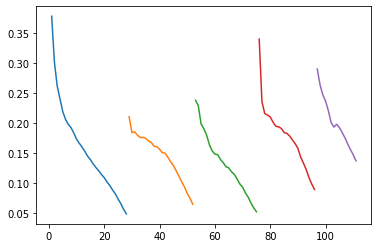

In [10]:
loss_plot(standard_total_loss_no_dropout)

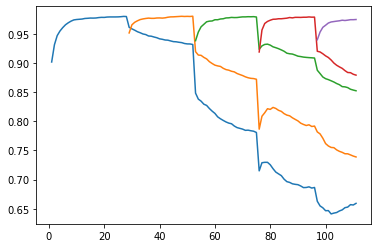

In [11]:
accuracy_plot(standard_prec_no_dropout)

In [ ]:
#avg_precision_plot([standard_prec_no_dropout])

In [12]:
mlp_consolidation_no_dropout = MLP(28*28, 10,
    hidden_size1,
    hidden_size2,
    0,
    0,
    lamda,
)

utils.gaussian_initialize(mlp_consolidation_no_dropout)

# run the standard experiment.
consolidate = True
ewc_prec_no_dropout, ewc_total_loss_no_dropout, ewc_ce_loss_no_dropout, ewc_ewc_loss_no_dropout =train(
    mlp_consolidation_no_dropout, train_loader, test_loader,
    epochs_per_task,
    batch_size,
    test_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    eval_log_interval,
    loss_log_interval,
    cuda
)

=> task: 1/5 | epoch: 1/100 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.3852 / ewc: 0.0 / total: 0.3852: : 469it [00:04, 111.35it/s]  


Validation loss decreased (inf --> 0.321557).  Saving model ...


=> task: 1/5 | epoch: 2/100 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.3203 / ewc: 0.0 / total: 0.3203: : 469it [00:04, 106.46it/s]  


Validation loss decreased (0.321557 --> 0.228814).  Saving model ...


=> task: 1/5 | epoch: 3/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2821 / ewc: 0.0 / total: 0.2821: : 469it [00:04, 100.23it/s] 


Validation loss decreased (0.228814 --> 0.177350).  Saving model ...


=> task: 1/5 | epoch: 4/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2591 / ewc: 0.0 / total: 0.2591: : 469it [00:03, 120.00it/s]  


Validation loss decreased (0.177350 --> 0.146014).  Saving model ...


=> task: 1/5 | epoch: 5/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2436 / ewc: 0.0 / total: 0.2436: : 469it [00:04, 96.61it/s]   


Validation loss decreased (0.146014 --> 0.124020).  Saving model ...


=> task: 1/5 | epoch: 6/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2318 / ewc: 0.0 / total: 0.2318: : 469it [00:04, 113.44it/s]  


Validation loss decreased (0.124020 --> 0.108489).  Saving model ...


=> task: 1/5 | epoch: 7/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2262 / ewc: 0.0 / total: 0.2262: : 469it [00:04, 102.19it/s]  


Validation loss decreased (0.108489 --> 0.098391).  Saving model ...


=> task: 1/5 | epoch: 8/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2231 / ewc: 0.0 / total: 0.2231: : 469it [00:04, 116.47it/s] 


Validation loss decreased (0.098391 --> 0.090833).  Saving model ...


=> task: 1/5 | epoch: 9/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2142 / ewc: 0.0 / total: 0.2142: : 469it [00:04, 116.29it/s] 


Validation loss decreased (0.090833 --> 0.084465).  Saving model ...


=> task: 1/5 | epoch: 10/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2077 / ewc: 0.0 / total: 0.2077: : 469it [00:04, 97.03it/s]  


Validation loss decreased (0.084465 --> 0.080331).  Saving model ...


=> task: 1/5 | epoch: 11/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1994 / ewc: 0.0 / total: 0.1994: : 469it [00:04, 111.75it/s] 


Validation loss decreased (0.080331 --> 0.077573).  Saving model ...


=> task: 1/5 | epoch: 12/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1934 / ewc: 0.0 / total: 0.1934: : 469it [00:04, 116.09it/s] 


Validation loss decreased (0.077573 --> 0.075204).  Saving model ...


=> task: 1/5 | epoch: 13/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1861 / ewc: 0.0 / total: 0.1861: : 469it [00:04, 116.65it/s] 


Validation loss decreased (0.075204 --> 0.073317).  Saving model ...


=> task: 1/5 | epoch: 14/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1784 / ewc: 0.0 / total: 0.1784: : 469it [00:04, 116.53it/s] 


Validation loss decreased (0.073317 --> 0.072141).  Saving model ...


=> task: 1/5 | epoch: 15/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1706 / ewc: 0.0 / total: 0.1706: : 469it [00:04, 117.14it/s] 


Validation loss decreased (0.072141 --> 0.070852).  Saving model ...


=> task: 1/5 | epoch: 16/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1633 / ewc: 0.0 / total: 0.1633: : 469it [00:04, 117.21it/s] 


Validation loss decreased (0.070852 --> 0.070126).  Saving model ...


=> task: 1/5 | epoch: 17/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1556 / ewc: 0.0 / total: 0.1556: : 469it [00:04, 115.91it/s] 


Validation loss decreased (0.070126 --> 0.069691).  Saving model ...


=> task: 1/5 | epoch: 18/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1464 / ewc: 0.0 / total: 0.1464: : 469it [00:04, 116.56it/s] 


Validation loss decreased (0.069691 --> 0.069416).  Saving model ...


=> task: 1/5 | epoch: 19/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1388 / ewc: 0.0 / total: 0.1388: : 469it [00:03, 117.26it/s]  


EarlyStopping counter: 1 out of 5


=> task: 1/5 | epoch: 20/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1311 / ewc: 0.0 / total: 0.1311: : 469it [00:03, 119.86it/s]  


EarlyStopping counter: 2 out of 5


=> task: 1/5 | epoch: 21/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1207 / ewc: 0.0 / total: 0.1207: : 469it [00:03, 120.80it/s]  


EarlyStopping counter: 3 out of 5


=> task: 1/5 | epoch: 22/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1118 / ewc: 0.0 / total: 0.1118: : 469it [00:03, 121.25it/s]  


EarlyStopping counter: 4 out of 5


=> task: 1/5 | epoch: 23/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1033 / ewc: 0.0 / total: 0.1033: : 469it [00:03, 120.72it/s]  


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 2/5 | epoch: 1/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2598 / ewc: 0.03165 / total: 0.2914: : 469it [00:05, 80.96it/s]  


Validation loss decreased (inf --> 0.257362).  Saving model ...


=> task: 2/5 | epoch: 2/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2314 / ewc: 0.02347 / total: 0.2549: : 469it [00:05, 89.71it/s]   


Validation loss decreased (0.257362 --> 0.178158).  Saving model ...


=> task: 2/5 | epoch: 3/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2171 / ewc: 0.0203 / total: 0.2374: : 469it [00:05, 89.69it/s]    


Validation loss decreased (0.178158 --> 0.152834).  Saving model ...


=> task: 2/5 | epoch: 4/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2082 / ewc: 0.01825 / total: 0.2264: : 469it [00:05, 92.36it/s]  


Validation loss decreased (0.152834 --> 0.136160).  Saving model ...


=> task: 2/5 | epoch: 5/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2045 / ewc: 0.01669 / total: 0.2212: : 469it [00:05, 91.62it/s]   


Validation loss decreased (0.136160 --> 0.125379).  Saving model ...


=> task: 2/5 | epoch: 6/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1998 / ewc: 0.01563 / total: 0.2154: : 469it [00:05, 93.23it/s]   


Validation loss decreased (0.125379 --> 0.117425).  Saving model ...


=> task: 2/5 | epoch: 7/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1951 / ewc: 0.0148 / total: 0.2099: : 469it [00:05, 89.00it/s]    


Validation loss decreased (0.117425 --> 0.112107).  Saving model ...


=> task: 2/5 | epoch: 8/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1908 / ewc: 0.01413 / total: 0.205: : 469it [00:05, 91.72it/s]   


Validation loss decreased (0.112107 --> 0.107566).  Saving model ...


=> task: 2/5 | epoch: 9/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1887 / ewc: 0.01352 / total: 0.2022: : 469it [00:05, 91.43it/s]  


Validation loss decreased (0.107566 --> 0.104131).  Saving model ...


=> task: 2/5 | epoch: 10/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1846 / ewc: 0.01306 / total: 0.1977: : 469it [00:05, 93.47it/s]  


Validation loss decreased (0.104131 --> 0.101155).  Saving model ...


=> task: 2/5 | epoch: 11/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1813 / ewc: 0.01269 / total: 0.194: : 469it [00:04, 98.00it/s]   


Validation loss decreased (0.101155 --> 0.099045).  Saving model ...


=> task: 2/5 | epoch: 12/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1812 / ewc: 0.01231 / total: 0.1935: : 469it [00:05, 91.21it/s]  


Validation loss decreased (0.099045 --> 0.097146).  Saving model ...


=> task: 2/5 | epoch: 13/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1777 / ewc: 0.01195 / total: 0.1896: : 469it [00:05, 91.05it/s]  


Validation loss decreased (0.097146 --> 0.095237).  Saving model ...


=> task: 2/5 | epoch: 14/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1755 / ewc: 0.01171 / total: 0.1872: : 469it [00:05, 91.54it/s]  


Validation loss decreased (0.095237 --> 0.093738).  Saving model ...


=> task: 2/5 | epoch: 15/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1738 / ewc: 0.01142 / total: 0.1852: : 469it [00:04, 101.22it/s] 


Validation loss decreased (0.093738 --> 0.092712).  Saving model ...


=> task: 2/5 | epoch: 16/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1707 / ewc: 0.01114 / total: 0.1818: : 469it [00:05, 91.00it/s]  


Validation loss decreased (0.092712 --> 0.091098).  Saving model ...


=> task: 2/5 | epoch: 17/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1689 / ewc: 0.01098 / total: 0.1799: : 469it [00:05, 90.37it/s]   


Validation loss decreased (0.091098 --> 0.090395).  Saving model ...


=> task: 2/5 | epoch: 18/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1665 / ewc: 0.01072 / total: 0.1772: : 469it [00:04, 96.27it/s]   


Validation loss decreased (0.090395 --> 0.089369).  Saving model ...


=> task: 2/5 | epoch: 19/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1651 / ewc: 0.01054 / total: 0.1756: : 469it [00:05, 93.45it/s]   


Validation loss decreased (0.089369 --> 0.088585).  Saving model ...


=> task: 2/5 | epoch: 20/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1626 / ewc: 0.01031 / total: 0.1729: : 469it [00:05, 91.67it/s]   


Validation loss decreased (0.088585 --> 0.087608).  Saving model ...


=> task: 2/5 | epoch: 21/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1609 / ewc: 0.01014 / total: 0.1711: : 469it [00:05, 91.25it/s]   


Validation loss decreased (0.087608 --> 0.086969).  Saving model ...


=> task: 2/5 | epoch: 22/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1597 / ewc: 0.009995 / total: 0.1697: : 469it [00:05, 91.46it/s]  


Validation loss decreased (0.086969 --> 0.086438).  Saving model ...


=> task: 2/5 | epoch: 23/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1603 / ewc: 0.009857 / total: 0.1701: : 469it [00:05, 90.82it/s]  


Validation loss decreased (0.086438 --> 0.085762).  Saving model ...


=> task: 2/5 | epoch: 24/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.157 / ewc: 0.009701 / total: 0.1667: : 469it [00:04, 105.88it/s]  


Validation loss decreased (0.085762 --> 0.085050).  Saving model ...


=> task: 2/5 | epoch: 25/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1557 / ewc: 0.009537 / total: 0.1652: : 469it [00:05, 90.90it/s]  


Validation loss decreased (0.085050 --> 0.084424).  Saving model ...


=> task: 2/5 | epoch: 26/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1558 / ewc: 0.009398 / total: 0.1652: : 469it [00:05, 91.49it/s]  


Validation loss decreased (0.084424 --> 0.083724).  Saving model ...


=> task: 2/5 | epoch: 27/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1541 / ewc: 0.009277 / total: 0.1634: : 469it [00:05, 91.64it/s]  


Validation loss decreased (0.083724 --> 0.083442).  Saving model ...


=> task: 2/5 | epoch: 28/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1508 / ewc: 0.009175 / total: 0.16: : 469it [00:05, 91.43it/s]    


Validation loss decreased (0.083442 --> 0.082777).  Saving model ...


=> task: 2/5 | epoch: 29/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1504 / ewc: 0.008985 / total: 0.1594: : 469it [00:05, 91.58it/s]  


Validation loss decreased (0.082777 --> 0.081894).  Saving model ...


=> task: 2/5 | epoch: 30/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1481 / ewc: 0.008907 / total: 0.157: : 469it [00:05, 91.50it/s]   


Validation loss decreased (0.081894 --> 0.081761).  Saving model ...


=> task: 2/5 | epoch: 31/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1477 / ewc: 0.008735 / total: 0.1565: : 469it [00:05, 91.33it/s]  


Validation loss decreased (0.081761 --> 0.081302).  Saving model ...


=> task: 2/5 | epoch: 32/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1447 / ewc: 0.008647 / total: 0.1533: : 469it [00:05, 89.36it/s]  


Validation loss decreased (0.081302 --> 0.080930).  Saving model ...


=> task: 2/5 | epoch: 33/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1438 / ewc: 0.00851 / total: 0.1523: : 469it [00:05, 89.11it/s]   


Validation loss decreased (0.080930 --> 0.080440).  Saving model ...


=> task: 2/5 | epoch: 34/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1432 / ewc: 0.00845 / total: 0.1516: : 469it [00:05, 93.08it/s]   


Validation loss decreased (0.080440 --> 0.080392).  Saving model ...


=> task: 2/5 | epoch: 35/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1418 / ewc: 0.0083 / total: 0.1501: : 469it [00:05, 92.22it/s]    


Validation loss decreased (0.080392 --> 0.079930).  Saving model ...


=> task: 2/5 | epoch: 36/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1397 / ewc: 0.008235 / total: 0.1479: : 469it [00:05, 89.73it/s]  


Validation loss decreased (0.079930 --> 0.079607).  Saving model ...


=> task: 2/5 | epoch: 37/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1384 / ewc: 0.008073 / total: 0.1465: : 469it [00:05, 90.79it/s]  


Validation loss decreased (0.079607 --> 0.079064).  Saving model ...


=> task: 2/5 | epoch: 38/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1384 / ewc: 0.007991 / total: 0.1464: : 469it [00:05, 91.53it/s]  


Validation loss decreased (0.079064 --> 0.078763).  Saving model ...


=> task: 2/5 | epoch: 39/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.136 / ewc: 0.00787 / total: 0.1438: : 469it [00:05, 90.57it/s]    


Validation loss decreased (0.078763 --> 0.078560).  Saving model ...


=> task: 2/5 | epoch: 40/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1356 / ewc: 0.007765 / total: 0.1433: : 469it [00:05, 88.15it/s]  


Validation loss decreased (0.078560 --> 0.078313).  Saving model ...


=> task: 2/5 | epoch: 41/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1342 / ewc: 0.007696 / total: 0.1419: : 469it [00:05, 90.55it/s]  


Validation loss decreased (0.078313 --> 0.078042).  Saving model ...


=> task: 2/5 | epoch: 42/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1327 / ewc: 0.007566 / total: 0.1403: : 469it [00:05, 91.18it/s]  


Validation loss decreased (0.078042 --> 0.077828).  Saving model ...


=> task: 2/5 | epoch: 43/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1322 / ewc: 0.007485 / total: 0.1396: : 469it [00:05, 91.74it/s]  


Validation loss decreased (0.077828 --> 0.077407).  Saving model ...


=> task: 2/5 | epoch: 44/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1309 / ewc: 0.007387 / total: 0.1383: : 469it [00:05, 90.52it/s]  


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 45/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1283 / ewc: 0.007329 / total: 0.1356: : 469it [00:05, 91.73it/s]  


Validation loss decreased (0.077407 --> 0.077024).  Saving model ...


=> task: 2/5 | epoch: 46/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1275 / ewc: 0.007248 / total: 0.1348: : 469it [00:05, 88.82it/s]  


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 47/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1252 / ewc: 0.007139 / total: 0.1323: : 469it [00:05, 90.50it/s]   


Validation loss decreased (0.077024 --> 0.076481).  Saving model ...


=> task: 2/5 | epoch: 48/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1236 / ewc: 0.007074 / total: 0.1307: : 469it [00:05, 88.52it/s]   


Validation loss decreased (0.076481 --> 0.076302).  Saving model ...


=> task: 2/5 | epoch: 49/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1215 / ewc: 0.006994 / total: 0.1285: : 469it [00:05, 90.23it/s]   


Validation loss decreased (0.076302 --> 0.076149).  Saving model ...


=> task: 2/5 | epoch: 50/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1207 / ewc: 0.00695 / total: 0.1277: : 469it [00:05, 91.09it/s]    


Validation loss decreased (0.076149 --> 0.075945).  Saving model ...


=> task: 2/5 | epoch: 51/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1187 / ewc: 0.006831 / total: 0.1255: : 469it [00:05, 90.32it/s]   


Validation loss decreased (0.075945 --> 0.075580).  Saving model ...


=> task: 2/5 | epoch: 52/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1158 / ewc: 0.006791 / total: 0.1226: : 469it [00:05, 90.85it/s]  


Validation loss decreased (0.075580 --> 0.075239).  Saving model ...


=> task: 2/5 | epoch: 53/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1138 / ewc: 0.006697 / total: 0.1205: : 469it [00:05, 91.27it/s]   


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 54/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1135 / ewc: 0.006628 / total: 0.1201: : 469it [00:05, 91.37it/s]  


Validation loss decreased (0.075239 --> 0.074998).  Saving model ...


=> task: 2/5 | epoch: 55/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1118 / ewc: 0.006582 / total: 0.1184: : 469it [00:05, 91.35it/s]   


Validation loss decreased (0.074998 --> 0.074891).  Saving model ...


=> task: 2/5 | epoch: 56/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1099 / ewc: 0.006523 / total: 0.1164: : 469it [00:05, 91.36it/s]   


Validation loss decreased (0.074891 --> 0.074706).  Saving model ...


=> task: 2/5 | epoch: 57/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1077 / ewc: 0.006443 / total: 0.1141: : 469it [00:05, 90.95it/s]   


Validation loss decreased (0.074706 --> 0.074315).  Saving model ...


=> task: 2/5 | epoch: 58/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.106 / ewc: 0.006353 / total: 0.1123: : 469it [00:05, 89.93it/s]   


Validation loss decreased (0.074315 --> 0.074171).  Saving model ...


=> task: 2/5 | epoch: 59/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.105 / ewc: 0.006327 / total: 0.1113: : 469it [00:05, 89.82it/s]   


Validation loss decreased (0.074171 --> 0.074140).  Saving model ...


=> task: 2/5 | epoch: 60/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1039 / ewc: 0.006273 / total: 0.1102: : 469it [00:04, 100.39it/s] 


Validation loss decreased (0.074140 --> 0.073970).  Saving model ...


=> task: 2/5 | epoch: 61/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1019 / ewc: 0.006189 / total: 0.1081: : 469it [00:05, 91.09it/s]   


Validation loss decreased (0.073970 --> 0.073599).  Saving model ...


=> task: 2/5 | epoch: 62/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09999 / ewc: 0.006131 / total: 0.1061: : 469it [00:05, 91.04it/s]  


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 63/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09868 / ewc: 0.006081 / total: 0.1048: : 469it [00:05, 91.53it/s]  


EarlyStopping counter: 2 out of 5


=> task: 2/5 | epoch: 64/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0967 / ewc: 0.006019 / total: 0.1027: : 469it [00:05, 92.01it/s]   


Validation loss decreased (0.073599 --> 0.073471).  Saving model ...


=> task: 2/5 | epoch: 65/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09473 / ewc: 0.00598 / total: 0.1007: : 469it [00:05, 90.40it/s]   


Validation loss decreased (0.073471 --> 0.073406).  Saving model ...


=> task: 2/5 | epoch: 66/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09294 / ewc: 0.00593 / total: 0.09887: : 469it [00:05, 87.65it/s]  


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 67/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09177 / ewc: 0.00586 / total: 0.09763: : 469it [00:05, 87.11it/s]  


Validation loss decreased (0.073406 --> 0.073184).  Saving model ...


=> task: 2/5 | epoch: 68/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0902 / ewc: 0.005833 / total: 0.09603: : 469it [00:05, 91.76it/s] 


Validation loss decreased (0.073184 --> 0.072941).  Saving model ...


=> task: 2/5 | epoch: 69/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08877 / ewc: 0.005754 / total: 0.09452: : 469it [00:05, 90.83it/s] 


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 70/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08717 / ewc: 0.005713 / total: 0.09288: : 469it [00:05, 90.77it/s] 


EarlyStopping counter: 2 out of 5


=> task: 2/5 | epoch: 71/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08539 / ewc: 0.005682 / total: 0.09107: : 469it [00:05, 89.09it/s]


EarlyStopping counter: 3 out of 5


=> task: 2/5 | epoch: 72/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08365 / ewc: 0.005619 / total: 0.08927: : 469it [00:05, 90.96it/s] 


Validation loss decreased (0.072941 --> 0.072613).  Saving model ...


=> task: 2/5 | epoch: 73/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08237 / ewc: 0.005574 / total: 0.08794: : 469it [00:05, 90.95it/s] 


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 74/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08077 / ewc: 0.00552 / total: 0.08629: : 469it [00:05, 91.86it/s]  


EarlyStopping counter: 2 out of 5


=> task: 2/5 | epoch: 75/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07861 / ewc: 0.005484 / total: 0.08409: : 469it [00:05, 91.31it/s] 


Validation loss decreased (0.072613 --> 0.072604).  Saving model ...


=> task: 2/5 | epoch: 76/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0778 / ewc: 0.005432 / total: 0.08323: : 469it [00:05, 90.51it/s]  


Validation loss decreased (0.072604 --> 0.072573).  Saving model ...


=> task: 2/5 | epoch: 77/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0763 / ewc: 0.005388 / total: 0.08168: : 469it [00:05, 90.63it/s]  


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 78/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07414 / ewc: 0.005359 / total: 0.07949: : 469it [00:05, 91.72it/s] 


Validation loss decreased (0.072573 --> 0.072182).  Saving model ...


=> task: 2/5 | epoch: 79/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07311 / ewc: 0.005303 / total: 0.07842: : 469it [00:05, 91.66it/s] 


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 80/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07143 / ewc: 0.005277 / total: 0.07671: : 469it [00:05, 91.36it/s] 


EarlyStopping counter: 2 out of 5


=> task: 2/5 | epoch: 81/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06937 / ewc: 0.005214 / total: 0.07458: : 469it [00:04, 98.34it/s] 


EarlyStopping counter: 3 out of 5


=> task: 2/5 | epoch: 82/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06811 / ewc: 0.005187 / total: 0.07329: : 469it [00:04, 106.77it/s]


EarlyStopping counter: 4 out of 5


=> task: 2/5 | epoch: 83/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06605 / ewc: 0.00515 / total: 0.0712: : 469it [00:05, 91.58it/s]   


Validation loss decreased (0.072182 --> 0.072124).  Saving model ...


=> task: 2/5 | epoch: 84/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06476 / ewc: 0.005098 / total: 0.06986: : 469it [00:05, 90.87it/s] 


Validation loss decreased (0.072124 --> 0.072089).  Saving model ...


=> task: 2/5 | epoch: 85/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06375 / ewc: 0.005082 / total: 0.06883: : 469it [00:05, 90.69it/s] 


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 86/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06218 / ewc: 0.005031 / total: 0.06721: : 469it [00:05, 91.21it/s] 


Validation loss decreased (0.072089 --> 0.071830).  Saving model ...


=> task: 2/5 | epoch: 87/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06063 / ewc: 0.005012 / total: 0.06565: : 469it [00:05, 91.40it/s] 


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 88/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05913 / ewc: 0.004959 / total: 0.06409: : 469it [00:05, 91.66it/s] 


Validation loss decreased (0.071830 --> 0.071742).  Saving model ...


=> task: 2/5 | epoch: 89/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05827 / ewc: 0.004937 / total: 0.06321: : 469it [00:05, 90.43it/s] 


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 90/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05603 / ewc: 0.00489 / total: 0.06092: : 469it [00:05, 92.20it/s] 


Validation loss decreased (0.071742 --> 0.071735).  Saving model ...


=> task: 2/5 | epoch: 91/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05379 / ewc: 0.004852 / total: 0.05864: : 469it [00:05, 90.85it/s] 


Validation loss decreased (0.071735 --> 0.071601).  Saving model ...


=> task: 2/5 | epoch: 92/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05258 / ewc: 0.004826 / total: 0.0574: : 469it [00:05, 91.62it/s]  


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 93/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05124 / ewc: 0.004781 / total: 0.05602: : 469it [00:05, 91.67it/s] 


EarlyStopping counter: 2 out of 5


=> task: 2/5 | epoch: 94/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05022 / ewc: 0.004769 / total: 0.05499: : 469it [00:05, 91.85it/s] 


EarlyStopping counter: 3 out of 5


=> task: 2/5 | epoch: 95/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04814 / ewc: 0.004718 / total: 0.05286: : 469it [00:05, 91.86it/s] 


EarlyStopping counter: 4 out of 5


=> task: 2/5 | epoch: 96/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04716 / ewc: 0.004685 / total: 0.05184: : 469it [00:04, 95.45it/s] 


Validation loss decreased (0.071601 --> 0.071341).  Saving model ...


=> task: 2/5 | epoch: 97/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04584 / ewc: 0.004664 / total: 0.05051: : 469it [00:05, 90.85it/s] 


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 98/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04375 / ewc: 0.004612 / total: 0.04837: : 469it [00:05, 91.51it/s] 


EarlyStopping counter: 2 out of 5


=> task: 2/5 | epoch: 99/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04241 / ewc: 0.004585 / total: 0.047: : 469it [00:05, 91.67it/s]   


Validation loss decreased (0.071341 --> 0.071192).  Saving model ...


=> task: 2/5 | epoch: 100/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04175 / ewc: 0.004565 / total: 0.04631: : 469it [00:05, 91.13it/s] 


EarlyStopping counter: 1 out of 5
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 3/5 | epoch: 1/100 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.3051 / ewc: 0.03011 / total: 0.3352: : 469it [00:05, 87.59it/s]   


Validation loss decreased (inf --> 0.246123).  Saving model ...


=> task: 3/5 | epoch: 2/100 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2551 / ewc: 0.02257 / total: 0.2777: : 469it [00:04, 100.15it/s] 


Validation loss decreased (0.246123 --> 0.182672).  Saving model ...


=> task: 3/5 | epoch: 3/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2393 / ewc: 0.01937 / total: 0.2586: : 469it [00:05, 90.85it/s]  


Validation loss decreased (0.182672 --> 0.160228).  Saving model ...


=> task: 3/5 | epoch: 4/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2345 / ewc: 0.01733 / total: 0.2519: : 469it [00:05, 91.17it/s]  


Validation loss decreased (0.160228 --> 0.146692).  Saving model ...


=> task: 3/5 | epoch: 5/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2299 / ewc: 0.01584 / total: 0.2458: : 469it [00:05, 91.38it/s]  


Validation loss decreased (0.146692 --> 0.138421).  Saving model ...


=> task: 3/5 | epoch: 6/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2267 / ewc: 0.01482 / total: 0.2416: : 469it [00:05, 90.84it/s]  


Validation loss decreased (0.138421 --> 0.130504).  Saving model ...


=> task: 3/5 | epoch: 7/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2218 / ewc: 0.01395 / total: 0.2358: : 469it [00:05, 91.02it/s]  


Validation loss decreased (0.130504 --> 0.123898).  Saving model ...


=> task: 3/5 | epoch: 8/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2149 / ewc: 0.01326 / total: 0.2281: : 469it [00:05, 91.29it/s]  


Validation loss decreased (0.123898 --> 0.119810).  Saving model ...


=> task: 3/5 | epoch: 9/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2102 / ewc: 0.01269 / total: 0.2228: : 469it [00:05, 90.87it/s]  


Validation loss decreased (0.119810 --> 0.115108).  Saving model ...


=> task: 3/5 | epoch: 10/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2017 / ewc: 0.01214 / total: 0.2138: : 469it [00:05, 93.13it/s]  


Validation loss decreased (0.115108 --> 0.111311).  Saving model ...


=> task: 3/5 | epoch: 11/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1972 / ewc: 0.01171 / total: 0.2089: : 469it [00:05, 90.77it/s]  


Validation loss decreased (0.111311 --> 0.108799).  Saving model ...


=> task: 3/5 | epoch: 12/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1926 / ewc: 0.01129 / total: 0.2038: : 469it [00:05, 89.00it/s]  


Validation loss decreased (0.108799 --> 0.106352).  Saving model ...


=> task: 3/5 | epoch: 13/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1883 / ewc: 0.01091 / total: 0.1992: : 469it [00:05, 89.66it/s]  


Validation loss decreased (0.106352 --> 0.103834).  Saving model ...


=> task: 3/5 | epoch: 14/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1837 / ewc: 0.0106 / total: 0.1943: : 469it [00:05, 91.30it/s]   


Validation loss decreased (0.103834 --> 0.102374).  Saving model ...


=> task: 3/5 | epoch: 15/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1793 / ewc: 0.01028 / total: 0.1896: : 469it [00:05, 91.46it/s]   


Validation loss decreased (0.102374 --> 0.100496).  Saving model ...


=> task: 3/5 | epoch: 16/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1753 / ewc: 0.01 / total: 0.1853: : 469it [00:05, 90.70it/s]      


Validation loss decreased (0.100496 --> 0.099426).  Saving model ...


=> task: 3/5 | epoch: 17/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.17 / ewc: 0.00976 / total: 0.1798: : 469it [00:05, 90.17it/s]     


Validation loss decreased (0.099426 --> 0.097634).  Saving model ...


=> task: 3/5 | epoch: 18/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1661 / ewc: 0.0095 / total: 0.1756: : 469it [00:05, 91.41it/s]    


Validation loss decreased (0.097634 --> 0.097157).  Saving model ...


=> task: 3/5 | epoch: 19/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1601 / ewc: 0.009295 / total: 0.1694: : 469it [00:05, 91.25it/s]  


Validation loss decreased (0.097157 --> 0.096355).  Saving model ...


=> task: 3/5 | epoch: 20/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1548 / ewc: 0.009041 / total: 0.1638: : 469it [00:05, 90.84it/s]  


Validation loss decreased (0.096355 --> 0.094415).  Saving model ...


=> task: 3/5 | epoch: 21/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1502 / ewc: 0.00884 / total: 0.159: : 469it [00:05, 91.00it/s]    


Validation loss decreased (0.094415 --> 0.093892).  Saving model ...


=> task: 3/5 | epoch: 22/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.146 / ewc: 0.008664 / total: 0.1547: : 469it [00:05, 91.26it/s]   


Validation loss decreased (0.093892 --> 0.092718).  Saving model ...


=> task: 3/5 | epoch: 23/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1412 / ewc: 0.008473 / total: 0.1497: : 469it [00:05, 91.45it/s]  


Validation loss decreased (0.092718 --> 0.091972).  Saving model ...


=> task: 3/5 | epoch: 24/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1381 / ewc: 0.008296 / total: 0.1464: : 469it [00:05, 91.42it/s]  


Validation loss decreased (0.091972 --> 0.091386).  Saving model ...


=> task: 3/5 | epoch: 25/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1337 / ewc: 0.008135 / total: 0.1419: : 469it [00:05, 91.81it/s]  


Validation loss decreased (0.091386 --> 0.090742).  Saving model ...


=> task: 3/5 | epoch: 26/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.131 / ewc: 0.007983 / total: 0.139: : 469it [00:05, 91.48it/s]    


Validation loss decreased (0.090742 --> 0.090689).  Saving model ...


=> task: 3/5 | epoch: 27/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1269 / ewc: 0.007829 / total: 0.1347: : 469it [00:05, 91.86it/s]  


Validation loss decreased (0.090689 --> 0.089995).  Saving model ...


=> task: 3/5 | epoch: 28/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1252 / ewc: 0.0077 / total: 0.1329: : 469it [00:05, 91.47it/s]    


Validation loss decreased (0.089995 --> 0.089653).  Saving model ...


=> task: 3/5 | epoch: 29/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1206 / ewc: 0.00757 / total: 0.1282: : 469it [00:05, 91.29it/s]    


Validation loss decreased (0.089653 --> 0.089060).  Saving model ...


=> task: 3/5 | epoch: 30/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1182 / ewc: 0.007451 / total: 0.1256: : 469it [00:05, 91.18it/s]  


Validation loss decreased (0.089060 --> 0.088850).  Saving model ...


=> task: 3/5 | epoch: 31/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1152 / ewc: 0.007333 / total: 0.1225: : 469it [00:05, 92.57it/s]   


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 32/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.113 / ewc: 0.007229 / total: 0.1203: : 469it [00:05, 90.85it/s]    


Validation loss decreased (0.088850 --> 0.088783).  Saving model ...


=> task: 3/5 | epoch: 33/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1095 / ewc: 0.007107 / total: 0.1166: : 469it [00:05, 91.83it/s]   


Validation loss decreased (0.088783 --> 0.088412).  Saving model ...


=> task: 3/5 | epoch: 34/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1069 / ewc: 0.007007 / total: 0.1139: : 469it [00:05, 90.77it/s]   


Validation loss decreased (0.088412 --> 0.088358).  Saving model ...


=> task: 3/5 | epoch: 35/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1053 / ewc: 0.0069 / total: 0.1122: : 469it [00:05, 91.63it/s]     


Validation loss decreased (0.088358 --> 0.088309).  Saving model ...


=> task: 3/5 | epoch: 36/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1023 / ewc: 0.006791 / total: 0.1091: : 469it [00:05, 91.31it/s]   


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 37/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09949 / ewc: 0.006702 / total: 0.1062: : 469it [00:05, 91.45it/s]  


Validation loss decreased (0.088309 --> 0.087902).  Saving model ...


=> task: 3/5 | epoch: 38/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09654 / ewc: 0.006607 / total: 0.1032: : 469it [00:05, 91.31it/s] 


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 39/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09463 / ewc: 0.006518 / total: 0.1012: : 469it [00:05, 91.53it/s]  


EarlyStopping counter: 2 out of 5


=> task: 3/5 | epoch: 40/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09282 / ewc: 0.006453 / total: 0.09928: : 469it [00:05, 91.96it/s] 


EarlyStopping counter: 3 out of 5


=> task: 3/5 | epoch: 41/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09037 / ewc: 0.006353 / total: 0.09673: : 469it [00:05, 91.70it/s] 


Validation loss decreased (0.087902 --> 0.087663).  Saving model ...


=> task: 3/5 | epoch: 42/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08736 / ewc: 0.006274 / total: 0.09363: : 469it [00:05, 90.53it/s] 


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 43/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08503 / ewc: 0.00621 / total: 0.09124: : 469it [00:05, 91.96it/s]  


EarlyStopping counter: 2 out of 5


=> task: 3/5 | epoch: 44/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08072 / ewc: 0.006113 / total: 0.08684: : 469it [00:05, 91.43it/s] 


Validation loss decreased (0.087663 --> 0.087137).  Saving model ...


=> task: 3/5 | epoch: 45/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08073 / ewc: 0.006041 / total: 0.08677: : 469it [00:05, 91.61it/s] 


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 46/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07843 / ewc: 0.005976 / total: 0.08441: : 469it [00:05, 91.49it/s] 


EarlyStopping counter: 2 out of 5


=> task: 3/5 | epoch: 47/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07498 / ewc: 0.005897 / total: 0.08088: : 469it [00:05, 90.76it/s] 


EarlyStopping counter: 3 out of 5


=> task: 3/5 | epoch: 48/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07496 / ewc: 0.00583 / total: 0.08079: : 469it [00:05, 92.02it/s] 


EarlyStopping counter: 4 out of 5


=> task: 3/5 | epoch: 49/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07164 / ewc: 0.00578 / total: 0.07742: : 469it [00:05, 91.38it/s]  


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 4/5 | epoch: 1/100 | progress: [60032/60000] (100%) | prec: 0.9062 | loss => ce: 0.3982 / ewc: 0.02941 / total: 0.4276: : 469it [00:05, 87.29it/s]   


Validation loss decreased (inf --> 0.404458).  Saving model ...


=> task: 4/5 | epoch: 2/100 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.3376 / ewc: 0.02156 / total: 0.3592: : 469it [00:05, 81.39it/s]   


Validation loss decreased (0.404458 --> 0.290591).  Saving model ...


=> task: 4/5 | epoch: 3/100 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.3136 / ewc: 0.01825 / total: 0.3318: : 469it [00:05, 90.92it/s]  


Validation loss decreased (0.290591 --> 0.263774).  Saving model ...


=> task: 4/5 | epoch: 4/100 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2781 / ewc: 0.01624 / total: 0.2944: : 469it [00:05, 90.34it/s]   


Validation loss decreased (0.263774 --> 0.194623).  Saving model ...


=> task: 4/5 | epoch: 5/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2705 / ewc: 0.01501 / total: 0.2855: : 469it [00:05, 89.78it/s]   


Validation loss decreased (0.194623 --> 0.172864).  Saving model ...


=> task: 4/5 | epoch: 6/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.256 / ewc: 0.01406 / total: 0.2701: : 469it [00:05, 89.84it/s]    


Validation loss decreased (0.172864 --> 0.151396).  Saving model ...


=> task: 4/5 | epoch: 7/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2432 / ewc: 0.01322 / total: 0.2564: : 469it [00:05, 89.66it/s]   


Validation loss decreased (0.151396 --> 0.136519).  Saving model ...


=> task: 4/5 | epoch: 8/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.239 / ewc: 0.0125 / total: 0.2515: : 469it [00:05, 91.52it/s]    


Validation loss decreased (0.136519 --> 0.130416).  Saving model ...


=> task: 4/5 | epoch: 9/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2302 / ewc: 0.01199 / total: 0.2422: : 469it [00:05, 91.38it/s]  


Validation loss decreased (0.130416 --> 0.122918).  Saving model ...


=> task: 4/5 | epoch: 10/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2217 / ewc: 0.01144 / total: 0.2331: : 469it [00:05, 88.94it/s]  


Validation loss decreased (0.122918 --> 0.116882).  Saving model ...


=> task: 4/5 | epoch: 11/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2165 / ewc: 0.01104 / total: 0.2275: : 469it [00:05, 90.90it/s]  


Validation loss decreased (0.116882 --> 0.113647).  Saving model ...


=> task: 4/5 | epoch: 12/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2078 / ewc: 0.01068 / total: 0.2184: : 469it [00:05, 90.39it/s]  


Validation loss decreased (0.113647 --> 0.110942).  Saving model ...


=> task: 4/5 | epoch: 13/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2019 / ewc: 0.01036 / total: 0.2123: : 469it [00:05, 91.07it/s]   


Validation loss decreased (0.110942 --> 0.108009).  Saving model ...


=> task: 4/5 | epoch: 14/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1958 / ewc: 0.01012 / total: 0.2059: : 469it [00:05, 91.28it/s]   


Validation loss decreased (0.108009 --> 0.105526).  Saving model ...


=> task: 4/5 | epoch: 15/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1898 / ewc: 0.009829 / total: 0.1996: : 469it [00:05, 90.68it/s]  


Validation loss decreased (0.105526 --> 0.103504).  Saving model ...


=> task: 4/5 | epoch: 16/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1859 / ewc: 0.0096 / total: 0.1955: : 469it [00:05, 90.09it/s]    


Validation loss decreased (0.103504 --> 0.102426).  Saving model ...


=> task: 4/5 | epoch: 17/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1796 / ewc: 0.009424 / total: 0.189: : 469it [00:05, 89.36it/s]   


Validation loss decreased (0.102426 --> 0.101467).  Saving model ...


=> task: 4/5 | epoch: 18/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1739 / ewc: 0.009151 / total: 0.183: : 469it [00:05, 90.35it/s]   


Validation loss decreased (0.101467 --> 0.099895).  Saving model ...


=> task: 4/5 | epoch: 19/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1686 / ewc: 0.008957 / total: 0.1776: : 469it [00:05, 91.22it/s]  


Validation loss decreased (0.099895 --> 0.098403).  Saving model ...


=> task: 4/5 | epoch: 20/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1648 / ewc: 0.0088 / total: 0.1736: : 469it [00:05, 91.52it/s]    


Validation loss decreased (0.098403 --> 0.097831).  Saving model ...


=> task: 4/5 | epoch: 21/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.159 / ewc: 0.008558 / total: 0.1675: : 469it [00:05, 91.56it/s]   


Validation loss decreased (0.097831 --> 0.096462).  Saving model ...


=> task: 4/5 | epoch: 22/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1547 / ewc: 0.008377 / total: 0.163: : 469it [00:05, 90.99it/s]   


Validation loss decreased (0.096462 --> 0.095658).  Saving model ...


=> task: 4/5 | epoch: 23/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.15 / ewc: 0.00824 / total: 0.1583: : 469it [00:05, 90.85it/s]     


Validation loss decreased (0.095658 --> 0.094243).  Saving model ...


=> task: 4/5 | epoch: 24/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1458 / ewc: 0.008066 / total: 0.1539: : 469it [00:05, 91.28it/s]  


Validation loss decreased (0.094243 --> 0.093713).  Saving model ...


=> task: 4/5 | epoch: 25/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1426 / ewc: 0.007888 / total: 0.1505: : 469it [00:05, 91.33it/s]  


Validation loss decreased (0.093713 --> 0.092832).  Saving model ...


=> task: 4/5 | epoch: 26/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1396 / ewc: 0.00771 / total: 0.1473: : 469it [00:05, 91.55it/s]   


Validation loss decreased (0.092832 --> 0.092378).  Saving model ...


=> task: 4/5 | epoch: 27/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1367 / ewc: 0.007601 / total: 0.1443: : 469it [00:05, 91.24it/s]  


EarlyStopping counter: 1 out of 5


=> task: 4/5 | epoch: 28/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1341 / ewc: 0.007439 / total: 0.1415: : 469it [00:05, 92.03it/s]  


Validation loss decreased (0.092378 --> 0.091722).  Saving model ...


=> task: 4/5 | epoch: 29/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1303 / ewc: 0.007301 / total: 0.1376: : 469it [00:05, 91.47it/s]  


Validation loss decreased (0.091722 --> 0.091288).  Saving model ...


=> task: 4/5 | epoch: 30/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1271 / ewc: 0.007158 / total: 0.1343: : 469it [00:05, 90.74it/s]  


Validation loss decreased (0.091288 --> 0.090743).  Saving model ...


=> task: 4/5 | epoch: 31/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1248 / ewc: 0.007021 / total: 0.1319: : 469it [00:05, 91.09it/s]  


Validation loss decreased (0.090743 --> 0.090286).  Saving model ...


=> task: 4/5 | epoch: 32/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1217 / ewc: 0.006912 / total: 0.1286: : 469it [00:05, 89.89it/s]  


EarlyStopping counter: 1 out of 5


=> task: 4/5 | epoch: 33/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1179 / ewc: 0.006753 / total: 0.1247: : 469it [00:05, 90.48it/s]  


Validation loss decreased (0.090286 --> 0.089486).  Saving model ...


=> task: 4/5 | epoch: 34/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.116 / ewc: 0.006657 / total: 0.1227: : 469it [00:05, 89.98it/s]    


EarlyStopping counter: 1 out of 5


=> task: 4/5 | epoch: 35/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1133 / ewc: 0.006546 / total: 0.1198: : 469it [00:05, 92.26it/s]   


Validation loss decreased (0.089486 --> 0.089383).  Saving model ...


=> task: 4/5 | epoch: 36/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1103 / ewc: 0.00644 / total: 0.1167: : 469it [00:05, 91.09it/s]    


Validation loss decreased (0.089383 --> 0.088772).  Saving model ...


=> task: 4/5 | epoch: 37/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1078 / ewc: 0.006291 / total: 0.1141: : 469it [00:05, 91.22it/s]   


EarlyStopping counter: 1 out of 5


=> task: 4/5 | epoch: 38/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1037 / ewc: 0.006219 / total: 0.11: : 469it [00:05, 90.16it/s]     


EarlyStopping counter: 2 out of 5


=> task: 4/5 | epoch: 39/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09961 / ewc: 0.006099 / total: 0.1057: : 469it [00:05, 91.91it/s] 


EarlyStopping counter: 3 out of 5


=> task: 4/5 | epoch: 40/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09518 / ewc: 0.006015 / total: 0.1012: : 469it [00:05, 92.29it/s]  


EarlyStopping counter: 4 out of 5


=> task: 4/5 | epoch: 41/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09073 / ewc: 0.005907 / total: 0.09663: : 469it [00:05, 92.12it/s] 


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 5/5 | epoch: 1/100 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.27 / ewc: 0.03025 / total: 0.3003: : 469it [00:05, 81.39it/s]     


Validation loss decreased (inf --> 0.246410).  Saving model ...


=> task: 5/5 | epoch: 2/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2197 / ewc: 0.02195 / total: 0.2416: : 469it [00:05, 79.92it/s]  


Validation loss decreased (0.246410 --> 0.170818).  Saving model ...


=> task: 5/5 | epoch: 3/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2062 / ewc: 0.01845 / total: 0.2246: : 469it [00:05, 81.95it/s]   


Validation loss decreased (0.170818 --> 0.146862).  Saving model ...


=> task: 5/5 | epoch: 4/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2079 / ewc: 0.01636 / total: 0.2242: : 469it [00:05, 90.62it/s]   


Validation loss decreased (0.146862 --> 0.135247).  Saving model ...


=> task: 5/5 | epoch: 5/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1987 / ewc: 0.01494 / total: 0.2136: : 469it [00:05, 91.23it/s]   


Validation loss decreased (0.135247 --> 0.124831).  Saving model ...


=> task: 5/5 | epoch: 6/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1916 / ewc: 0.01392 / total: 0.2055: : 469it [00:05, 91.50it/s]   


Validation loss decreased (0.124831 --> 0.117749).  Saving model ...


=> task: 5/5 | epoch: 7/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1882 / ewc: 0.01312 / total: 0.2013: : 469it [00:05, 91.09it/s]   


Validation loss decreased (0.117749 --> 0.112732).  Saving model ...


=> task: 5/5 | epoch: 8/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1855 / ewc: 0.01238 / total: 0.1979: : 469it [00:05, 89.70it/s]  


Validation loss decreased (0.112732 --> 0.109618).  Saving model ...


=> task: 5/5 | epoch: 9/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1825 / ewc: 0.0118 / total: 0.1943: : 469it [00:05, 89.85it/s]   


Validation loss decreased (0.109618 --> 0.106196).  Saving model ...


=> task: 5/5 | epoch: 10/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1787 / ewc: 0.01126 / total: 0.1899: : 469it [00:05, 89.82it/s]   


Validation loss decreased (0.106196 --> 0.102914).  Saving model ...


=> task: 5/5 | epoch: 11/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1733 / ewc: 0.01079 / total: 0.1841: : 469it [00:05, 91.59it/s]  


Validation loss decreased (0.102914 --> 0.100653).  Saving model ...


=> task: 5/5 | epoch: 12/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1699 / ewc: 0.01036 / total: 0.1803: : 469it [00:05, 91.17it/s]  


Validation loss decreased (0.100653 --> 0.098879).  Saving model ...


=> task: 5/5 | epoch: 13/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1679 / ewc: 0.009998 / total: 0.1779: : 469it [00:05, 91.28it/s]  


Validation loss decreased (0.098879 --> 0.097871).  Saving model ...


=> task: 5/5 | epoch: 14/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1612 / ewc: 0.009638 / total: 0.1708: : 469it [00:05, 91.46it/s]   


Validation loss decreased (0.097871 --> 0.094697).  Saving model ...


=> task: 5/5 | epoch: 15/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1603 / ewc: 0.009334 / total: 0.1696: : 469it [00:05, 91.10it/s]  


Validation loss decreased (0.094697 --> 0.093572).  Saving model ...


=> task: 5/5 | epoch: 16/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.157 / ewc: 0.009085 / total: 0.1661: : 469it [00:05, 91.08it/s]    


Validation loss decreased (0.093572 --> 0.093085).  Saving model ...


=> task: 5/5 | epoch: 17/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1536 / ewc: 0.008863 / total: 0.1625: : 469it [00:05, 91.16it/s]  


Validation loss decreased (0.093085 --> 0.091957).  Saving model ...


=> task: 5/5 | epoch: 18/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1506 / ewc: 0.008624 / total: 0.1593: : 469it [00:05, 90.50it/s]  


Validation loss decreased (0.091957 --> 0.091489).  Saving model ...


=> task: 5/5 | epoch: 19/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1468 / ewc: 0.008428 / total: 0.1552: : 469it [00:05, 88.46it/s]  


Validation loss decreased (0.091489 --> 0.090366).  Saving model ...


=> task: 5/5 | epoch: 20/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1428 / ewc: 0.008209 / total: 0.151: : 469it [00:05, 90.71it/s]   


Validation loss decreased (0.090366 --> 0.090321).  Saving model ...


=> task: 5/5 | epoch: 21/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1409 / ewc: 0.008017 / total: 0.1489: : 469it [00:05, 91.62it/s]   


Validation loss decreased (0.090321 --> 0.089286).  Saving model ...


=> task: 5/5 | epoch: 22/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1364 / ewc: 0.007857 / total: 0.1443: : 469it [00:05, 91.25it/s]   


Validation loss decreased (0.089286 --> 0.088421).  Saving model ...


=> task: 5/5 | epoch: 23/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.135 / ewc: 0.007721 / total: 0.1427: : 469it [00:05, 91.15it/s]    


Validation loss decreased (0.088421 --> 0.088297).  Saving model ...


=> task: 5/5 | epoch: 24/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1323 / ewc: 0.007539 / total: 0.1398: : 469it [00:05, 90.10it/s]   


Validation loss decreased (0.088297 --> 0.087404).  Saving model ...


=> task: 5/5 | epoch: 25/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1298 / ewc: 0.007398 / total: 0.1372: : 469it [00:05, 91.56it/s]   


Validation loss decreased (0.087404 --> 0.087004).  Saving model ...


=> task: 5/5 | epoch: 26/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1276 / ewc: 0.007218 / total: 0.1348: : 469it [00:05, 91.48it/s]   


Validation loss decreased (0.087004 --> 0.086370).  Saving model ...


=> task: 5/5 | epoch: 27/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1245 / ewc: 0.007079 / total: 0.1315: : 469it [00:05, 90.89it/s]   


Validation loss decreased (0.086370 --> 0.086103).  Saving model ...


=> task: 5/5 | epoch: 28/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1235 / ewc: 0.006951 / total: 0.1304: : 469it [00:05, 90.90it/s]   


Validation loss decreased (0.086103 --> 0.085897).  Saving model ...


=> task: 5/5 | epoch: 29/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1194 / ewc: 0.006818 / total: 0.1262: : 469it [00:05, 91.25it/s]   


Validation loss decreased (0.085897 --> 0.085490).  Saving model ...


=> task: 5/5 | epoch: 30/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1181 / ewc: 0.006705 / total: 0.1248: : 469it [00:05, 91.64it/s]   


Validation loss decreased (0.085490 --> 0.085182).  Saving model ...


=> task: 5/5 | epoch: 31/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1151 / ewc: 0.006592 / total: 0.1217: : 469it [00:05, 91.80it/s]   


Validation loss decreased (0.085182 --> 0.084693).  Saving model ...


=> task: 5/5 | epoch: 32/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1128 / ewc: 0.006484 / total: 0.1193: : 469it [00:05, 91.43it/s]   


Validation loss decreased (0.084693 --> 0.084597).  Saving model ...


=> task: 5/5 | epoch: 33/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.111 / ewc: 0.006397 / total: 0.1174: : 469it [00:05, 91.16it/s]    


EarlyStopping counter: 1 out of 5


=> task: 5/5 | epoch: 34/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1079 / ewc: 0.006276 / total: 0.1142: : 469it [00:05, 91.62it/s]   


Validation loss decreased (0.084597 --> 0.084306).  Saving model ...


=> task: 5/5 | epoch: 35/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1051 / ewc: 0.006174 / total: 0.1113: : 469it [00:05, 91.94it/s]   


Validation loss decreased (0.084306 --> 0.084253).  Saving model ...


=> task: 5/5 | epoch: 36/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1029 / ewc: 0.006077 / total: 0.109: : 469it [00:05, 90.98it/s]    


Validation loss decreased (0.084253 --> 0.083832).  Saving model ...


=> task: 5/5 | epoch: 37/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1007 / ewc: 0.005988 / total: 0.1067: : 469it [00:05, 91.53it/s]  


Validation loss decreased (0.083832 --> 0.083778).  Saving model ...


=> task: 5/5 | epoch: 38/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0988 / ewc: 0.0059 / total: 0.1047: : 469it [00:05, 92.52it/s]     


EarlyStopping counter: 1 out of 5


=> task: 5/5 | epoch: 39/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09585 / ewc: 0.005805 / total: 0.1017: : 469it [00:05, 89.85it/s]  


Validation loss decreased (0.083778 --> 0.083278).  Saving model ...


=> task: 5/5 | epoch: 40/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09393 / ewc: 0.005714 / total: 0.09964: : 469it [00:05, 91.24it/s] 


EarlyStopping counter: 1 out of 5


=> task: 5/5 | epoch: 41/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09164 / ewc: 0.005638 / total: 0.09728: : 469it [00:05, 91.96it/s] 


Validation loss decreased (0.083278 --> 0.083181).  Saving model ...


=> task: 5/5 | epoch: 42/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08971 / ewc: 0.005553 / total: 0.09526: : 469it [00:05, 91.98it/s] 


Validation loss decreased (0.083181 --> 0.083168).  Saving model ...


=> task: 5/5 | epoch: 43/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08779 / ewc: 0.00547 / total: 0.09326: : 469it [00:05, 91.61it/s]  


Validation loss decreased (0.083168 --> 0.082589).  Saving model ...


=> task: 5/5 | epoch: 44/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08486 / ewc: 0.005401 / total: 0.09026: : 469it [00:05, 90.58it/s] 


Validation loss decreased (0.082589 --> 0.082576).  Saving model ...


=> task: 5/5 | epoch: 45/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08294 / ewc: 0.00533 / total: 0.08827: : 469it [00:05, 91.59it/s] 


EarlyStopping counter: 1 out of 5


=> task: 5/5 | epoch: 46/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08022 / ewc: 0.005261 / total: 0.08548: : 469it [00:05, 91.21it/s] 


EarlyStopping counter: 2 out of 5


=> task: 5/5 | epoch: 47/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07828 / ewc: 0.005189 / total: 0.08347: : 469it [00:05, 92.06it/s] 


Validation loss decreased (0.082576 --> 0.082194).  Saving model ...


=> task: 5/5 | epoch: 48/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07517 / ewc: 0.005113 / total: 0.08028: : 469it [00:05, 91.41it/s] 


Validation loss decreased (0.082194 --> 0.082162).  Saving model ...


=> task: 5/5 | epoch: 49/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07305 / ewc: 0.00505 / total: 0.0781: : 469it [00:05, 90.81it/s]  


Validation loss decreased (0.082162 --> 0.081912).  Saving model ...


=> task: 5/5 | epoch: 50/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07027 / ewc: 0.004982 / total: 0.07525: : 469it [00:05, 90.89it/s] 


Validation loss decreased (0.081912 --> 0.081360).  Saving model ...


=> task: 5/5 | epoch: 51/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06775 / ewc: 0.004919 / total: 0.07267: : 469it [00:05, 91.26it/s] 


EarlyStopping counter: 1 out of 5


=> task: 5/5 | epoch: 52/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06621 / ewc: 0.004857 / total: 0.07106: : 469it [00:05, 92.12it/s] 


EarlyStopping counter: 2 out of 5


=> task: 5/5 | epoch: 53/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06383 / ewc: 0.004798 / total: 0.06862: : 469it [00:05, 92.48it/s] 


EarlyStopping counter: 3 out of 5


=> task: 5/5 | epoch: 54/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06104 / ewc: 0.004743 / total: 0.06578: : 469it [00:05, 92.08it/s] 


Validation loss decreased (0.081360 --> 0.081214).  Saving model ...


=> task: 5/5 | epoch: 55/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05927 / ewc: 0.004682 / total: 0.06395: : 469it [00:05, 91.36it/s] 


EarlyStopping counter: 1 out of 5


=> task: 5/5 | epoch: 56/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05701 / ewc: 0.004624 / total: 0.06164: : 469it [00:05, 91.51it/s] 


Validation loss decreased (0.081214 --> 0.080665).  Saving model ...


=> task: 5/5 | epoch: 57/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05468 / ewc: 0.00457 / total: 0.05925: : 469it [00:05, 92.40it/s] 


EarlyStopping counter: 1 out of 5


=> task: 5/5 | epoch: 58/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05319 / ewc: 0.004517 / total: 0.05771: : 469it [00:05, 89.18it/s] 


EarlyStopping counter: 2 out of 5


=> task: 5/5 | epoch: 59/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05049 / ewc: 0.004463 / total: 0.05495: : 469it [00:05, 90.81it/s] 


EarlyStopping counter: 3 out of 5


=> task: 5/5 | epoch: 60/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04716 / ewc: 0.004417 / total: 0.05158: : 469it [00:05, 88.39it/s] 


EarlyStopping counter: 4 out of 5


=> task: 5/5 | epoch: 61/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04647 / ewc: 0.004364 / total: 0.05083: : 469it [00:05, 91.62it/s] 


Validation loss decreased (0.080665 --> 0.080555).  Saving model ...


=> task: 5/5 | epoch: 62/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.044 / ewc: 0.004326 / total: 0.04832: : 469it [00:05, 90.91it/s]   


EarlyStopping counter: 1 out of 5


=> task: 5/5 | epoch: 63/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04176 / ewc: 0.004281 / total: 0.04604: : 469it [00:05, 78.95it/s] 


EarlyStopping counter: 2 out of 5


=> task: 5/5 | epoch: 64/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04001 / ewc: 0.004234 / total: 0.04424: : 469it [00:06, 77.55it/s] 


EarlyStopping counter: 3 out of 5


=> task: 5/5 | epoch: 65/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.03731 / ewc: 0.004185 / total: 0.04149: : 469it [00:06, 71.05it/s]


Validation loss decreased (0.080555 --> 0.080390).  Saving model ...


=> task: 5/5 | epoch: 66/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.03577 / ewc: 0.004148 / total: 0.03992: : 469it [00:05, 83.84it/s]


EarlyStopping counter: 1 out of 5


=> task: 5/5 | epoch: 67/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0342 / ewc: 0.004109 / total: 0.03831: : 469it [00:05, 81.49it/s] 


EarlyStopping counter: 2 out of 5


=> task: 5/5 | epoch: 68/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.03252 / ewc: 0.004069 / total: 0.03658: : 469it [00:05, 88.27it/s] 


EarlyStopping counter: 3 out of 5


=> task: 5/5 | epoch: 69/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.03095 / ewc: 0.004031 / total: 0.03498: : 469it [00:05, 89.18it/s] 


Validation loss decreased (0.080390 --> 0.080182).  Saving model ...


=> task: 5/5 | epoch: 70/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.02895 / ewc: 0.003995 / total: 0.03294: : 469it [00:05, 83.88it/s] 


EarlyStopping counter: 1 out of 5


=> task: 5/5 | epoch: 71/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0272 / ewc: 0.003955 / total: 0.03115: : 469it [00:05, 87.14it/s] 


Validation loss decreased (0.080182 --> 0.080172).  Saving model ...


=> task: 5/5 | epoch: 72/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.02682 / ewc: 0.003923 / total: 0.03074: : 469it [00:05, 87.24it/s] 


Validation loss decreased (0.080172 --> 0.080008).  Saving model ...


=> task: 5/5 | epoch: 73/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.02527 / ewc: 0.003883 / total: 0.02915: : 469it [00:06, 74.32it/s] 


EarlyStopping counter: 1 out of 5


=> task: 5/5 | epoch: 74/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.02381 / ewc: 0.003847 / total: 0.02766: : 469it [00:06, 75.88it/s]


EarlyStopping counter: 2 out of 5


=> task: 5/5 | epoch: 75/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.02245 / ewc: 0.003814 / total: 0.02626: : 469it [00:05, 81.32it/s]


Validation loss decreased (0.080008 --> 0.079794).  Saving model ...


=> task: 5/5 | epoch: 76/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0215 / ewc: 0.00378 / total: 0.02528: : 469it [00:05, 81.14it/s]  


EarlyStopping counter: 1 out of 5


=> task: 5/5 | epoch: 77/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.02071 / ewc: 0.003748 / total: 0.02445: : 469it [00:06, 76.60it/s] 


EarlyStopping counter: 2 out of 5


=> task: 5/5 | epoch: 78/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.01925 / ewc: 0.003716 / total: 0.02296: : 469it [00:06, 74.78it/s]


EarlyStopping counter: 3 out of 5


=> task: 5/5 | epoch: 79/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.01851 / ewc: 0.003687 / total: 0.02219: : 469it [00:05, 80.73it/s] 


EarlyStopping counter: 4 out of 5


=> task: 5/5 | epoch: 80/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.01774 / ewc: 0.003654 / total: 0.02139: : 469it [00:05, 81.33it/s] 


EarlyStopping counter: 5 out of 5
Early stopping


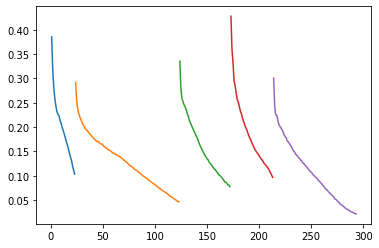

In [13]:
loss_plot(ewc_total_loss_no_dropout)

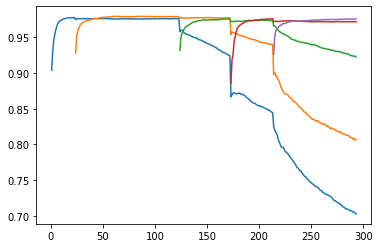

In [14]:
accuracy_plot(ewc_prec_no_dropout)

In [16]:
#avg_precision_plot([ewc_prec_no_dropout])

In [17]:
# prepare the model.
mlp_dropout = MLP(28*28, 10,
    hidden_size1,
    hidden_size2,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)
#different to xavier intialisation ??? test
# initialize the parameters.
utils.gaussian_initialize(mlp_dropout)

# run the standard experiment.
consolidate = False
standard_prec_dropout, standard_total_loss_dropout, standard_ce_loss_dropout, standard_ewc_loss_dropout = train(
    mlp_dropout, train_loader, test_loader,
    epochs_per_task,
    batch_size,
    test_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    eval_log_interval,
    loss_log_interval,
    cuda
)

=> task: 1/5 | epoch: 1/100 | progress: [60032/60000] (100%) | prec: 0.8854 | loss => ce: 0.5181 / ewc: 0.0 / total: 0.5181: : 469it [00:04, 108.87it/s]


Validation loss decreased (inf --> 0.308995).  Saving model ...


=> task: 1/5 | epoch: 2/100 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.3998 / ewc: 0.0 / total: 0.3998: : 469it [00:04, 105.09it/s] 


Validation loss decreased (0.308995 --> 0.219582).  Saving model ...


=> task: 1/5 | epoch: 3/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.221 / ewc: 0.0 / total: 0.221: : 469it [00:04, 96.11it/s]     


Validation loss decreased (0.219582 --> 0.170035).  Saving model ...


=> task: 1/5 | epoch: 4/100 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2848 / ewc: 0.0 / total: 0.2848: : 469it [00:04, 107.11it/s]  


Validation loss decreased (0.170035 --> 0.138773).  Saving model ...


=> task: 1/5 | epoch: 5/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2137 / ewc: 0.0 / total: 0.2137: : 469it [00:04, 105.30it/s]  


Validation loss decreased (0.138773 --> 0.117944).  Saving model ...


=> task: 1/5 | epoch: 6/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2491 / ewc: 0.0 / total: 0.2491: : 469it [00:04, 113.33it/s]  


Validation loss decreased (0.117944 --> 0.106362).  Saving model ...


=> task: 1/5 | epoch: 7/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1903 / ewc: 0.0 / total: 0.1903: : 469it [00:04, 97.15it/s]   


Validation loss decreased (0.106362 --> 0.096258).  Saving model ...


=> task: 1/5 | epoch: 8/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2447 / ewc: 0.0 / total: 0.2447: : 469it [00:05, 93.74it/s]   


Validation loss decreased (0.096258 --> 0.090319).  Saving model ...


=> task: 1/5 | epoch: 9/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2282 / ewc: 0.0 / total: 0.2282: : 469it [00:04, 104.20it/s]  


Validation loss decreased (0.090319 --> 0.085188).  Saving model ...


=> task: 1/5 | epoch: 10/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1907 / ewc: 0.0 / total: 0.1907: : 469it [00:04, 109.04it/s] 


Validation loss decreased (0.085188 --> 0.082260).  Saving model ...


=> task: 1/5 | epoch: 11/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2041 / ewc: 0.0 / total: 0.2041: : 469it [00:04, 101.01it/s] 


Validation loss decreased (0.082260 --> 0.079276).  Saving model ...


=> task: 1/5 | epoch: 12/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2197 / ewc: 0.0 / total: 0.2197: : 469it [00:04, 107.14it/s]  


Validation loss decreased (0.079276 --> 0.075665).  Saving model ...


=> task: 1/5 | epoch: 13/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1645 / ewc: 0.0 / total: 0.1645: : 469it [00:04, 102.06it/s]  


Validation loss decreased (0.075665 --> 0.074081).  Saving model ...


=> task: 1/5 | epoch: 14/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1596 / ewc: 0.0 / total: 0.1596: : 469it [00:04, 102.49it/s] 


Validation loss decreased (0.074081 --> 0.073438).  Saving model ...


=> task: 1/5 | epoch: 15/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2045 / ewc: 0.0 / total: 0.2045: : 469it [00:04, 100.60it/s] 


Validation loss decreased (0.073438 --> 0.068194).  Saving model ...


=> task: 1/5 | epoch: 16/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2197 / ewc: 0.0 / total: 0.2197: : 469it [00:04, 103.51it/s] 


Validation loss decreased (0.068194 --> 0.067763).  Saving model ...


=> task: 1/5 | epoch: 17/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1339 / ewc: 0.0 / total: 0.1339: : 469it [00:04, 107.35it/s] 


Validation loss decreased (0.067763 --> 0.066282).  Saving model ...


=> task: 1/5 | epoch: 18/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1615 / ewc: 0.0 / total: 0.1615: : 469it [00:04, 97.44it/s]  


Validation loss decreased (0.066282 --> 0.065462).  Saving model ...


=> task: 1/5 | epoch: 19/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2284 / ewc: 0.0 / total: 0.2284: : 469it [00:04, 107.70it/s]  


Validation loss decreased (0.065462 --> 0.062738).  Saving model ...


=> task: 1/5 | epoch: 20/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1619 / ewc: 0.0 / total: 0.1619: : 469it [00:04, 107.58it/s]  


EarlyStopping counter: 1 out of 5


=> task: 1/5 | epoch: 21/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.134 / ewc: 0.0 / total: 0.134: : 469it [00:04, 101.49it/s]     


Validation loss decreased (0.062738 --> 0.062234).  Saving model ...


=> task: 1/5 | epoch: 22/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1861 / ewc: 0.0 / total: 0.1861: : 469it [00:04, 100.67it/s]  


EarlyStopping counter: 1 out of 5


=> task: 1/5 | epoch: 23/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1187 / ewc: 0.0 / total: 0.1187: : 469it [00:04, 104.29it/s]  


EarlyStopping counter: 2 out of 5


=> task: 1/5 | epoch: 24/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.08377 / ewc: 0.0 / total: 0.08377: : 469it [00:04, 115.38it/s]


EarlyStopping counter: 3 out of 5


=> task: 1/5 | epoch: 25/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1611 / ewc: 0.0 / total: 0.1611: : 469it [00:04, 100.94it/s] 


EarlyStopping counter: 4 out of 5


=> task: 1/5 | epoch: 26/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1752 / ewc: 0.0 / total: 0.1752: : 469it [00:04, 100.93it/s] 


EarlyStopping counter: 5 out of 5
Early stopping


=> task: 2/5 | epoch: 1/100 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2323 / ewc: 0.0 / total: 0.2323: : 469it [00:04, 101.58it/s]  


Validation loss decreased (inf --> 0.151528).  Saving model ...


=> task: 2/5 | epoch: 2/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.199 / ewc: 0.0 / total: 0.199: : 469it [00:04, 109.42it/s]    


Validation loss decreased (0.151528 --> 0.105572).  Saving model ...


=> task: 2/5 | epoch: 3/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2129 / ewc: 0.0 / total: 0.2129: : 469it [00:04, 112.56it/s] 


Validation loss decreased (0.105572 --> 0.090704).  Saving model ...


=> task: 2/5 | epoch: 4/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2453 / ewc: 0.0 / total: 0.2453: : 469it [00:04, 112.43it/s]  


Validation loss decreased (0.090704 --> 0.082444).  Saving model ...


=> task: 2/5 | epoch: 5/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2932 / ewc: 0.0 / total: 0.2932: : 469it [00:04, 113.28it/s] 


Validation loss decreased (0.082444 --> 0.077604).  Saving model ...


=> task: 2/5 | epoch: 6/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.287 / ewc: 0.0 / total: 0.287: : 469it [00:04, 112.45it/s]   


Validation loss decreased (0.077604 --> 0.075844).  Saving model ...


=> task: 2/5 | epoch: 7/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2101 / ewc: 0.0 / total: 0.2101: : 469it [00:04, 113.35it/s]  


Validation loss decreased (0.075844 --> 0.070210).  Saving model ...


=> task: 2/5 | epoch: 8/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2456 / ewc: 0.0 / total: 0.2456: : 469it [00:04, 114.79it/s]  


Validation loss decreased (0.070210 --> 0.069008).  Saving model ...


=> task: 2/5 | epoch: 9/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1725 / ewc: 0.0 / total: 0.1725: : 469it [00:04, 114.87it/s]  


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 10/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1634 / ewc: 0.0 / total: 0.1634: : 469it [00:04, 114.50it/s] 


Validation loss decreased (0.069008 --> 0.066593).  Saving model ...


=> task: 2/5 | epoch: 11/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1808 / ewc: 0.0 / total: 0.1808: : 469it [00:04, 114.51it/s] 


Validation loss decreased (0.066593 --> 0.064101).  Saving model ...


=> task: 2/5 | epoch: 12/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1126 / ewc: 0.0 / total: 0.1126: : 469it [00:04, 114.18it/s]  


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 13/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.157 / ewc: 0.0 / total: 0.157: : 469it [00:04, 113.27it/s]   


Validation loss decreased (0.064101 --> 0.062990).  Saving model ...


=> task: 2/5 | epoch: 14/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1877 / ewc: 0.0 / total: 0.1877: : 469it [00:04, 114.80it/s]  


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 15/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1464 / ewc: 0.0 / total: 0.1464: : 469it [00:04, 115.21it/s] 


Validation loss decreased (0.062990 --> 0.061394).  Saving model ...


=> task: 2/5 | epoch: 16/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1745 / ewc: 0.0 / total: 0.1745: : 469it [00:04, 114.96it/s] 


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 17/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1635 / ewc: 0.0 / total: 0.1635: : 469it [00:04, 114.47it/s] 


Validation loss decreased (0.061394 --> 0.061037).  Saving model ...


=> task: 2/5 | epoch: 18/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1737 / ewc: 0.0 / total: 0.1737: : 469it [00:04, 113.43it/s] 


Validation loss decreased (0.061037 --> 0.059943).  Saving model ...


=> task: 2/5 | epoch: 19/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1015 / ewc: 0.0 / total: 0.1015: : 469it [00:04, 115.18it/s]   


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 20/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1599 / ewc: 0.0 / total: 0.1599: : 469it [00:04, 113.82it/s]   


EarlyStopping counter: 2 out of 5


=> task: 2/5 | epoch: 21/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1238 / ewc: 0.0 / total: 0.1238: : 469it [00:04, 115.17it/s] 


Validation loss decreased (0.059943 --> 0.056100).  Saving model ...


=> task: 2/5 | epoch: 22/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1156 / ewc: 0.0 / total: 0.1156: : 469it [00:04, 114.15it/s] 


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 23/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1213 / ewc: 0.0 / total: 0.1213: : 469it [00:04, 114.61it/s] 


EarlyStopping counter: 2 out of 5


=> task: 2/5 | epoch: 24/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1164 / ewc: 0.0 / total: 0.1164: : 469it [00:04, 114.83it/s]   


EarlyStopping counter: 3 out of 5


=> task: 2/5 | epoch: 25/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1182 / ewc: 0.0 / total: 0.1182: : 469it [00:04, 115.42it/s] 


EarlyStopping counter: 4 out of 5


=> task: 2/5 | epoch: 26/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07963 / ewc: 0.0 / total: 0.07963: : 469it [00:04, 114.39it/s]


EarlyStopping counter: 5 out of 5
Early stopping


=> task: 3/5 | epoch: 1/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2964 / ewc: 0.0 / total: 0.2964: : 469it [00:04, 116.00it/s]  


Validation loss decreased (inf --> 0.142920).  Saving model ...


=> task: 3/5 | epoch: 2/100 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.3016 / ewc: 0.0 / total: 0.3016: : 469it [00:04, 114.36it/s]  


Validation loss decreased (0.142920 --> 0.117978).  Saving model ...


=> task: 3/5 | epoch: 3/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1698 / ewc: 0.0 / total: 0.1698: : 469it [00:04, 114.16it/s]  


Validation loss decreased (0.117978 --> 0.101122).  Saving model ...


=> task: 3/5 | epoch: 4/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2117 / ewc: 0.0 / total: 0.2117: : 469it [00:04, 112.50it/s]  


Validation loss decreased (0.101122 --> 0.088498).  Saving model ...


=> task: 3/5 | epoch: 5/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.4041 / ewc: 0.0 / total: 0.4041: : 469it [00:04, 114.91it/s]  


Validation loss decreased (0.088498 --> 0.084613).  Saving model ...


=> task: 3/5 | epoch: 6/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2495 / ewc: 0.0 / total: 0.2495: : 469it [00:04, 114.73it/s]  


Validation loss decreased (0.084613 --> 0.080293).  Saving model ...


=> task: 3/5 | epoch: 7/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.3261 / ewc: 0.0 / total: 0.3261: : 469it [00:04, 114.65it/s]  


Validation loss decreased (0.080293 --> 0.075920).  Saving model ...


=> task: 3/5 | epoch: 8/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.159 / ewc: 0.0 / total: 0.159: : 469it [00:04, 115.22it/s]    


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 9/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2735 / ewc: 0.0 / total: 0.2735: : 469it [00:04, 115.28it/s] 


Validation loss decreased (0.075920 --> 0.073507).  Saving model ...


=> task: 3/5 | epoch: 10/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2707 / ewc: 0.0 / total: 0.2707: : 469it [00:04, 114.10it/s]  


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 11/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1177 / ewc: 0.0 / total: 0.1177: : 469it [00:04, 114.51it/s] 


Validation loss decreased (0.073507 --> 0.067650).  Saving model ...


=> task: 3/5 | epoch: 12/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2474 / ewc: 0.0 / total: 0.2474: : 469it [00:04, 114.92it/s]  


Validation loss decreased (0.067650 --> 0.065699).  Saving model ...


=> task: 3/5 | epoch: 13/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2019 / ewc: 0.0 / total: 0.2019: : 469it [00:04, 113.92it/s]  


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 14/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2341 / ewc: 0.0 / total: 0.2341: : 469it [00:04, 115.01it/s] 


EarlyStopping counter: 2 out of 5


=> task: 3/5 | epoch: 15/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.209 / ewc: 0.0 / total: 0.209: : 469it [00:04, 114.63it/s]    


EarlyStopping counter: 3 out of 5


=> task: 3/5 | epoch: 16/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2489 / ewc: 0.0 / total: 0.2489: : 469it [00:04, 113.58it/s] 


Validation loss decreased (0.065699 --> 0.064365).  Saving model ...


=> task: 3/5 | epoch: 17/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1896 / ewc: 0.0 / total: 0.1896: : 469it [00:04, 114.47it/s] 


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 18/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2206 / ewc: 0.0 / total: 0.2206: : 469it [00:04, 114.98it/s]  


Validation loss decreased (0.064365 --> 0.063900).  Saving model ...


=> task: 3/5 | epoch: 19/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1742 / ewc: 0.0 / total: 0.1742: : 469it [00:04, 112.76it/s]  


Validation loss decreased (0.063900 --> 0.062264).  Saving model ...


=> task: 3/5 | epoch: 20/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.118 / ewc: 0.0 / total: 0.118: : 469it [00:04, 114.74it/s]     


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 21/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1466 / ewc: 0.0 / total: 0.1466: : 469it [00:04, 114.96it/s] 


Validation loss decreased (0.062264 --> 0.061891).  Saving model ...


=> task: 3/5 | epoch: 22/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1955 / ewc: 0.0 / total: 0.1955: : 469it [00:04, 114.88it/s]  


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 23/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1827 / ewc: 0.0 / total: 0.1827: : 469it [00:04, 114.88it/s] 


Validation loss decreased (0.061891 --> 0.058646).  Saving model ...


=> task: 3/5 | epoch: 24/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1791 / ewc: 0.0 / total: 0.1791: : 469it [00:04, 114.18it/s]  


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 25/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1081 / ewc: 0.0 / total: 0.1081: : 469it [00:04, 115.05it/s]   


EarlyStopping counter: 2 out of 5


=> task: 3/5 | epoch: 26/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.147 / ewc: 0.0 / total: 0.147: : 469it [00:04, 114.69it/s]   


EarlyStopping counter: 3 out of 5


=> task: 3/5 | epoch: 27/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1537 / ewc: 0.0 / total: 0.1537: : 469it [00:04, 114.53it/s]   


EarlyStopping counter: 4 out of 5


=> task: 3/5 | epoch: 28/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1352 / ewc: 0.0 / total: 0.1352: : 469it [00:03, 117.81it/s] 


EarlyStopping counter: 5 out of 5
Early stopping


=> task: 4/5 | epoch: 1/100 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.424 / ewc: 0.0 / total: 0.424: : 469it [00:04, 114.26it/s]    


Validation loss decreased (inf --> 0.153344).  Saving model ...


=> task: 4/5 | epoch: 2/100 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.2829 / ewc: 0.0 / total: 0.2829: : 469it [00:04, 114.08it/s]  


Validation loss decreased (0.153344 --> 0.118094).  Saving model ...


=> task: 4/5 | epoch: 3/100 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2282 / ewc: 0.0 / total: 0.2282: : 469it [00:04, 113.93it/s]  


Validation loss decreased (0.118094 --> 0.103055).  Saving model ...


=> task: 4/5 | epoch: 4/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.3032 / ewc: 0.0 / total: 0.3032: : 469it [00:04, 114.34it/s]  


Validation loss decreased (0.103055 --> 0.094435).  Saving model ...


=> task: 4/5 | epoch: 5/100 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.3382 / ewc: 0.0 / total: 0.3382: : 469it [00:04, 114.14it/s] 


Validation loss decreased (0.094435 --> 0.085443).  Saving model ...


=> task: 4/5 | epoch: 6/100 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.266 / ewc: 0.0 / total: 0.266: : 469it [00:04, 113.87it/s]   


Validation loss decreased (0.085443 --> 0.079245).  Saving model ...


=> task: 4/5 | epoch: 7/100 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.236 / ewc: 0.0 / total: 0.236: : 469it [00:04, 114.00it/s]    


Validation loss decreased (0.079245 --> 0.079186).  Saving model ...


=> task: 4/5 | epoch: 8/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1638 / ewc: 0.0 / total: 0.1638: : 469it [00:04, 113.96it/s]  


Validation loss decreased (0.079186 --> 0.075290).  Saving model ...


=> task: 4/5 | epoch: 9/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2368 / ewc: 0.0 / total: 0.2368: : 469it [00:04, 115.45it/s] 


EarlyStopping counter: 1 out of 5


=> task: 4/5 | epoch: 10/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2106 / ewc: 0.0 / total: 0.2106: : 469it [00:04, 114.16it/s] 


Validation loss decreased (0.075290 --> 0.073054).  Saving model ...


=> task: 4/5 | epoch: 11/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.182 / ewc: 0.0 / total: 0.182: : 469it [00:04, 114.29it/s]   


Validation loss decreased (0.073054 --> 0.071492).  Saving model ...


=> task: 4/5 | epoch: 12/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1498 / ewc: 0.0 / total: 0.1498: : 469it [00:03, 129.70it/s]  


EarlyStopping counter: 1 out of 5


=> task: 4/5 | epoch: 13/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1454 / ewc: 0.0 / total: 0.1454: : 469it [00:04, 113.79it/s]  


Validation loss decreased (0.071492 --> 0.067971).  Saving model ...


=> task: 4/5 | epoch: 14/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1391 / ewc: 0.0 / total: 0.1391: : 469it [00:04, 114.11it/s] 


Validation loss decreased (0.067971 --> 0.066963).  Saving model ...


=> task: 4/5 | epoch: 15/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1985 / ewc: 0.0 / total: 0.1985: : 469it [00:04, 113.99it/s] 


EarlyStopping counter: 1 out of 5


=> task: 4/5 | epoch: 16/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1685 / ewc: 0.0 / total: 0.1685: : 469it [00:04, 113.90it/s] 


EarlyStopping counter: 2 out of 5


=> task: 4/5 | epoch: 17/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1963 / ewc: 0.0 / total: 0.1963: : 469it [00:04, 113.55it/s] 


Validation loss decreased (0.066963 --> 0.064643).  Saving model ...


=> task: 4/5 | epoch: 18/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1257 / ewc: 0.0 / total: 0.1257: : 469it [00:04, 114.38it/s] 


EarlyStopping counter: 1 out of 5


=> task: 4/5 | epoch: 19/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1552 / ewc: 0.0 / total: 0.1552: : 469it [00:04, 113.85it/s]  


EarlyStopping counter: 2 out of 5


=> task: 4/5 | epoch: 20/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2124 / ewc: 0.0 / total: 0.2124: : 469it [00:04, 115.17it/s] 


EarlyStopping counter: 3 out of 5


=> task: 4/5 | epoch: 21/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1305 / ewc: 0.0 / total: 0.1305: : 469it [00:04, 115.21it/s]  


EarlyStopping counter: 4 out of 5


=> task: 4/5 | epoch: 22/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1292 / ewc: 0.0 / total: 0.1292: : 469it [00:04, 114.47it/s] 


EarlyStopping counter: 5 out of 5
Early stopping


=> task: 5/5 | epoch: 1/100 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.3315 / ewc: 0.0 / total: 0.3315: : 469it [00:04, 115.52it/s]  


Validation loss decreased (inf --> 0.163112).  Saving model ...


=> task: 5/5 | epoch: 2/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1947 / ewc: 0.0 / total: 0.1947: : 469it [00:04, 114.02it/s] 


Validation loss decreased (0.163112 --> 0.125481).  Saving model ...


=> task: 5/5 | epoch: 3/100 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2641 / ewc: 0.0 / total: 0.2641: : 469it [00:04, 112.97it/s]  


Validation loss decreased (0.125481 --> 0.106072).  Saving model ...


=> task: 5/5 | epoch: 4/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.3333 / ewc: 0.0 / total: 0.3333: : 469it [00:04, 113.55it/s] 


Validation loss decreased (0.106072 --> 0.099918).  Saving model ...


=> task: 5/5 | epoch: 5/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1849 / ewc: 0.0 / total: 0.1849: : 469it [00:04, 114.03it/s]  


Validation loss decreased (0.099918 --> 0.094127).  Saving model ...


=> task: 5/5 | epoch: 6/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2073 / ewc: 0.0 / total: 0.2073: : 469it [00:04, 114.11it/s]  


Validation loss decreased (0.094127 --> 0.093384).  Saving model ...


=> task: 5/5 | epoch: 7/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2468 / ewc: 0.0 / total: 0.2468: : 469it [00:04, 114.83it/s]  


Validation loss decreased (0.093384 --> 0.087809).  Saving model ...


=> task: 5/5 | epoch: 8/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2479 / ewc: 0.0 / total: 0.2479: : 469it [00:04, 113.58it/s]  


Validation loss decreased (0.087809 --> 0.080131).  Saving model ...


=> task: 5/5 | epoch: 9/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1921 / ewc: 0.0 / total: 0.1921: : 469it [00:04, 114.85it/s] 


Validation loss decreased (0.080131 --> 0.074950).  Saving model ...


=> task: 5/5 | epoch: 10/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2999 / ewc: 0.0 / total: 0.2999: : 469it [00:04, 113.61it/s]  


EarlyStopping counter: 1 out of 5


=> task: 5/5 | epoch: 11/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.153 / ewc: 0.0 / total: 0.153: : 469it [00:04, 115.22it/s]    


Validation loss decreased (0.074950 --> 0.073936).  Saving model ...


=> task: 5/5 | epoch: 12/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1573 / ewc: 0.0 / total: 0.1573: : 469it [00:04, 113.94it/s]  


EarlyStopping counter: 1 out of 5


=> task: 5/5 | epoch: 13/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2342 / ewc: 0.0 / total: 0.2342: : 469it [00:04, 115.03it/s] 


Validation loss decreased (0.073936 --> 0.072423).  Saving model ...


=> task: 5/5 | epoch: 14/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1296 / ewc: 0.0 / total: 0.1296: : 469it [00:04, 114.57it/s]  


Validation loss decreased (0.072423 --> 0.071176).  Saving model ...


=> task: 5/5 | epoch: 15/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1639 / ewc: 0.0 / total: 0.1639: : 469it [00:04, 114.85it/s] 


Validation loss decreased (0.071176 --> 0.070635).  Saving model ...


=> task: 5/5 | epoch: 16/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2002 / ewc: 0.0 / total: 0.2002: : 469it [00:04, 113.82it/s]  


EarlyStopping counter: 1 out of 5


=> task: 5/5 | epoch: 17/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2044 / ewc: 0.0 / total: 0.2044: : 469it [00:04, 115.20it/s] 


Validation loss decreased (0.070635 --> 0.068177).  Saving model ...


=> task: 5/5 | epoch: 18/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1943 / ewc: 0.0 / total: 0.1943: : 469it [00:03, 128.74it/s] 


EarlyStopping counter: 1 out of 5


=> task: 5/5 | epoch: 19/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1415 / ewc: 0.0 / total: 0.1415: : 469it [00:04, 114.75it/s] 


EarlyStopping counter: 2 out of 5


=> task: 5/5 | epoch: 20/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1259 / ewc: 0.0 / total: 0.1259: : 469it [00:04, 115.31it/s]   


Validation loss decreased (0.068177 --> 0.067844).  Saving model ...


=> task: 5/5 | epoch: 21/100 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1413 / ewc: 0.0 / total: 0.1413: : 469it [00:04, 115.22it/s]  


Validation loss decreased (0.067844 --> 0.067825).  Saving model ...


=> task: 5/5 | epoch: 22/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1463 / ewc: 0.0 / total: 0.1463: : 469it [00:04, 114.50it/s]  


Validation loss decreased (0.067825 --> 0.064733).  Saving model ...


=> task: 5/5 | epoch: 23/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2286 / ewc: 0.0 / total: 0.2286: : 469it [00:04, 114.65it/s] 


EarlyStopping counter: 1 out of 5


=> task: 5/5 | epoch: 24/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1677 / ewc: 0.0 / total: 0.1677: : 469it [00:04, 114.05it/s]   


EarlyStopping counter: 2 out of 5


=> task: 5/5 | epoch: 25/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08811 / ewc: 0.0 / total: 0.08811: : 469it [00:04, 115.16it/s]


Validation loss decreased (0.064733 --> 0.063371).  Saving model ...


=> task: 5/5 | epoch: 26/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.157 / ewc: 0.0 / total: 0.157: : 469it [00:04, 113.87it/s]   


EarlyStopping counter: 1 out of 5


=> task: 5/5 | epoch: 27/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.13 / ewc: 0.0 / total: 0.13: : 469it [00:04, 114.08it/s]       


EarlyStopping counter: 2 out of 5


=> task: 5/5 | epoch: 28/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1074 / ewc: 0.0 / total: 0.1074: : 469it [00:04, 114.40it/s]  


EarlyStopping counter: 3 out of 5


=> task: 5/5 | epoch: 29/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1248 / ewc: 0.0 / total: 0.1248: : 469it [00:04, 115.29it/s]   


EarlyStopping counter: 4 out of 5


=> task: 5/5 | epoch: 30/100 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1246 / ewc: 0.0 / total: 0.1246: : 469it [00:04, 113.33it/s]   


EarlyStopping counter: 5 out of 5
Early stopping


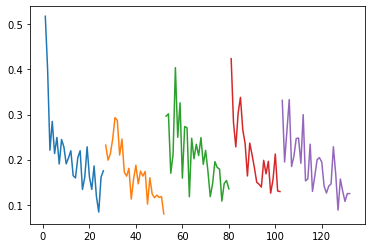

In [18]:
loss_plot(standard_total_loss_dropout)

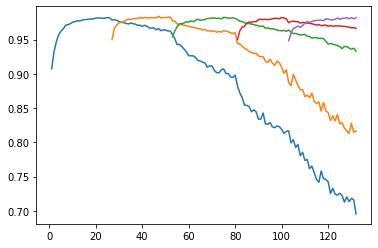

In [19]:
accuracy_plot(standard_prec_dropout)

In [20]:
#avg_precision_plot([standard_prec_dropout])

In [27]:
mlp_consolidation_dropout = MLP(28*28, 10,
    hidden_size1,
    hidden_size2,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

utils.gaussian_initialize(mlp_consolidation_dropout)

# run the standard experiment.
consolidate = True
ewc_prec_dropout, ewc_total_loss_dropout, ewc_ce_loss_dropout, ewc_ewc_loss_dropout =train(
    mlp_consolidation_dropout, train_loader, test_loader,
    epochs_per_task,
    batch_size,
    test_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    eval_log_interval,
    loss_log_interval,
    cuda
)

=> task: 1/5 | epoch: 1/100 | progress: [60032/60000] (100%) | prec: 0.8958 | loss => ce: 0.4358 / ewc: 0.0 / total: 0.4358: : 469it [00:04, 113.30it/s]


Validation loss decreased (inf --> 0.307913).  Saving model ...


=> task: 1/5 | epoch: 2/100 | progress: [60032/60000] (100%) | prec: 0.9062 | loss => ce: 0.3807 / ewc: 0.0 / total: 0.3807: : 469it [00:04, 111.31it/s]  


Validation loss decreased (0.307913 --> 0.219287).  Saving model ...


=> task: 1/5 | epoch: 3/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2315 / ewc: 0.0 / total: 0.2315: : 469it [00:04, 100.97it/s]  


Validation loss decreased (0.219287 --> 0.160860).  Saving model ...


=> task: 1/5 | epoch: 4/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.3476 / ewc: 0.0 / total: 0.3476: : 469it [00:04, 97.61it/s]   


Validation loss decreased (0.160860 --> 0.137013).  Saving model ...


=> task: 1/5 | epoch: 5/100 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2261 / ewc: 0.0 / total: 0.2261: : 469it [00:03, 127.87it/s]  


Validation loss decreased (0.137013 --> 0.118857).  Saving model ...


=> task: 1/5 | epoch: 6/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2429 / ewc: 0.0 / total: 0.2429: : 469it [00:03, 131.45it/s]  


Validation loss decreased (0.118857 --> 0.105267).  Saving model ...


=> task: 1/5 | epoch: 7/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1985 / ewc: 0.0 / total: 0.1985: : 469it [00:04, 113.73it/s]  


Validation loss decreased (0.105267 --> 0.093562).  Saving model ...


=> task: 1/5 | epoch: 8/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2642 / ewc: 0.0 / total: 0.2642: : 469it [00:04, 103.93it/s]  


Validation loss decreased (0.093562 --> 0.089004).  Saving model ...


=> task: 1/5 | epoch: 9/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2044 / ewc: 0.0 / total: 0.2044: : 469it [00:04, 100.96it/s]  


Validation loss decreased (0.089004 --> 0.084191).  Saving model ...


=> task: 1/5 | epoch: 10/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2371 / ewc: 0.0 / total: 0.2371: : 469it [00:04, 99.39it/s]  


Validation loss decreased (0.084191 --> 0.079600).  Saving model ...


=> task: 1/5 | epoch: 11/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2141 / ewc: 0.0 / total: 0.2141: : 469it [00:04, 100.89it/s] 


Validation loss decreased (0.079600 --> 0.077131).  Saving model ...


=> task: 1/5 | epoch: 12/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1773 / ewc: 0.0 / total: 0.1773: : 469it [00:04, 100.38it/s]  


Validation loss decreased (0.077131 --> 0.074855).  Saving model ...


=> task: 1/5 | epoch: 13/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1931 / ewc: 0.0 / total: 0.1931: : 469it [00:04, 99.84it/s]   


Validation loss decreased (0.074855 --> 0.070613).  Saving model ...


=> task: 1/5 | epoch: 14/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1683 / ewc: 0.0 / total: 0.1683: : 469it [00:04, 100.15it/s] 


Validation loss decreased (0.070613 --> 0.068821).  Saving model ...


=> task: 1/5 | epoch: 15/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2665 / ewc: 0.0 / total: 0.2665: : 469it [00:04, 98.01it/s]   


EarlyStopping counter: 1 out of 5


=> task: 1/5 | epoch: 16/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2167 / ewc: 0.0 / total: 0.2167: : 469it [00:04, 98.47it/s]  


Validation loss decreased (0.068821 --> 0.065635).  Saving model ...


=> task: 1/5 | epoch: 17/100 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2161 / ewc: 0.0 / total: 0.2161: : 469it [00:04, 99.26it/s]  


EarlyStopping counter: 1 out of 5


=> task: 1/5 | epoch: 18/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2002 / ewc: 0.0 / total: 0.2002: : 469it [00:04, 98.58it/s]   


Validation loss decreased (0.065635 --> 0.064818).  Saving model ...


=> task: 1/5 | epoch: 19/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1434 / ewc: 0.0 / total: 0.1434: : 469it [00:04, 98.43it/s]  


Validation loss decreased (0.064818 --> 0.062624).  Saving model ...


=> task: 1/5 | epoch: 20/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1413 / ewc: 0.0 / total: 0.1413: : 469it [00:05, 91.96it/s]  


EarlyStopping counter: 1 out of 5


=> task: 1/5 | epoch: 21/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1889 / ewc: 0.0 / total: 0.1889: : 469it [00:04, 101.57it/s]  


Validation loss decreased (0.062624 --> 0.062477).  Saving model ...


=> task: 1/5 | epoch: 22/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1569 / ewc: 0.0 / total: 0.1569: : 469it [00:04, 99.68it/s]   


Validation loss decreased (0.062477 --> 0.058447).  Saving model ...


=> task: 1/5 | epoch: 23/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1239 / ewc: 0.0 / total: 0.1239: : 469it [00:04, 102.07it/s]   


EarlyStopping counter: 1 out of 5


=> task: 1/5 | epoch: 24/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1628 / ewc: 0.0 / total: 0.1628: : 469it [00:04, 103.61it/s] 


EarlyStopping counter: 2 out of 5


=> task: 1/5 | epoch: 25/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2071 / ewc: 0.0 / total: 0.2071: : 469it [00:03, 122.50it/s] 


EarlyStopping counter: 3 out of 5


=> task: 1/5 | epoch: 26/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1508 / ewc: 0.0 / total: 0.1508: : 469it [00:03, 117.57it/s]   


EarlyStopping counter: 4 out of 5


=> task: 1/5 | epoch: 27/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1184 / ewc: 0.0 / total: 0.1184: : 469it [00:04, 116.89it/s] 


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 2/5 | epoch: 1/100 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.3145 / ewc: 0.03727 / total: 0.3518: : 469it [00:06, 76.68it/s] 


Validation loss decreased (inf --> 0.237075).  Saving model ...


=> task: 2/5 | epoch: 2/100 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.3449 / ewc: 0.02888 / total: 0.3738: : 469it [00:06, 77.39it/s] 


Validation loss decreased (0.237075 --> 0.188468).  Saving model ...


=> task: 2/5 | epoch: 3/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1931 / ewc: 0.02553 / total: 0.2186: : 469it [00:05, 79.04it/s] 


Validation loss decreased (0.188468 --> 0.162448).  Saving model ...


=> task: 2/5 | epoch: 4/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2064 / ewc: 0.02165 / total: 0.228: : 469it [00:06, 77.98it/s]   


Validation loss decreased (0.162448 --> 0.133589).  Saving model ...


=> task: 2/5 | epoch: 5/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2362 / ewc: 0.0204 / total: 0.2566: : 469it [00:06, 76.60it/s]   


Validation loss decreased (0.133589 --> 0.130383).  Saving model ...


=> task: 2/5 | epoch: 6/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2275 / ewc: 0.02058 / total: 0.248: : 469it [00:06, 77.14it/s]   


Validation loss decreased (0.130383 --> 0.121541).  Saving model ...


=> task: 2/5 | epoch: 7/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2089 / ewc: 0.01845 / total: 0.2273: : 469it [00:06, 76.75it/s]  


Validation loss decreased (0.121541 --> 0.115239).  Saving model ...


=> task: 2/5 | epoch: 8/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2008 / ewc: 0.01841 / total: 0.2192: : 469it [00:06, 77.08it/s]  


Validation loss decreased (0.115239 --> 0.108960).  Saving model ...


=> task: 2/5 | epoch: 9/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.257 / ewc: 0.01639 / total: 0.2734: : 469it [00:06, 76.40it/s]  


Validation loss decreased (0.108960 --> 0.106272).  Saving model ...


=> task: 2/5 | epoch: 10/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2542 / ewc: 0.01649 / total: 0.2707: : 469it [00:06, 77.02it/s]  


Validation loss decreased (0.106272 --> 0.105032).  Saving model ...


=> task: 2/5 | epoch: 11/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1318 / ewc: 0.01561 / total: 0.1474: : 469it [00:06, 76.62it/s] 


Validation loss decreased (0.105032 --> 0.101815).  Saving model ...


=> task: 2/5 | epoch: 12/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2558 / ewc: 0.01628 / total: 0.2721: : 469it [00:06, 76.26it/s]  


Validation loss decreased (0.101815 --> 0.100130).  Saving model ...


=> task: 2/5 | epoch: 13/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1533 / ewc: 0.01533 / total: 0.1686: : 469it [00:06, 76.53it/s]  


Validation loss decreased (0.100130 --> 0.095667).  Saving model ...


=> task: 2/5 | epoch: 14/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.234 / ewc: 0.01443 / total: 0.2485: : 469it [00:06, 76.07it/s]  


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 15/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1795 / ewc: 0.01494 / total: 0.1944: : 469it [00:06, 77.17it/s]  


Validation loss decreased (0.095667 --> 0.093805).  Saving model ...


=> task: 2/5 | epoch: 16/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1985 / ewc: 0.01433 / total: 0.2128: : 469it [00:06, 77.29it/s] 


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 17/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1699 / ewc: 0.0143 / total: 0.1842: : 469it [00:06, 76.80it/s]   


Validation loss decreased (0.093805 --> 0.091544).  Saving model ...


=> task: 2/5 | epoch: 18/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1126 / ewc: 0.01431 / total: 0.1269: : 469it [00:06, 76.05it/s] 


Validation loss decreased (0.091544 --> 0.091134).  Saving model ...


=> task: 2/5 | epoch: 19/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2322 / ewc: 0.01356 / total: 0.2458: : 469it [00:06, 76.88it/s] 


Validation loss decreased (0.091134 --> 0.089158).  Saving model ...


=> task: 2/5 | epoch: 20/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1602 / ewc: 0.01332 / total: 0.1735: : 469it [00:05, 78.61it/s]  


Validation loss decreased (0.089158 --> 0.087578).  Saving model ...


=> task: 2/5 | epoch: 21/100 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.1562 / ewc: 0.01417 / total: 0.1704: : 469it [00:05, 87.85it/s]  


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 22/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1758 / ewc: 0.01266 / total: 0.1885: : 469it [00:04, 96.80it/s]   


Validation loss decreased (0.087578 --> 0.087419).  Saving model ...


=> task: 2/5 | epoch: 23/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2064 / ewc: 0.01284 / total: 0.2193: : 469it [00:04, 98.74it/s]   


Validation loss decreased (0.087419 --> 0.085872).  Saving model ...


=> task: 2/5 | epoch: 24/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1493 / ewc: 0.01341 / total: 0.1627: : 469it [00:06, 77.18it/s] 


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 25/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.169 / ewc: 0.01286 / total: 0.1818: : 469it [00:06, 76.44it/s]  


EarlyStopping counter: 2 out of 5


=> task: 2/5 | epoch: 26/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1805 / ewc: 0.01159 / total: 0.1921: : 469it [00:06, 76.86it/s] 


Validation loss decreased (0.085872 --> 0.081561).  Saving model ...


=> task: 2/5 | epoch: 27/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1983 / ewc: 0.0122 / total: 0.2105: : 469it [00:06, 75.80it/s]  


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 28/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1311 / ewc: 0.01303 / total: 0.1441: : 469it [00:05, 78.30it/s]  


EarlyStopping counter: 2 out of 5


=> task: 2/5 | epoch: 29/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1482 / ewc: 0.01241 / total: 0.1606: : 469it [00:06, 76.92it/s]  


EarlyStopping counter: 3 out of 5


=> task: 2/5 | epoch: 30/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1555 / ewc: 0.01181 / total: 0.1673: : 469it [00:06, 76.27it/s] 


EarlyStopping counter: 4 out of 5


=> task: 2/5 | epoch: 31/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1965 / ewc: 0.01209 / total: 0.2086: : 469it [00:06, 77.01it/s]  


Validation loss decreased (0.081561 --> 0.080878).  Saving model ...


=> task: 2/5 | epoch: 32/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1664 / ewc: 0.01251 / total: 0.1789: : 469it [00:05, 93.23it/s]  


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 33/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2254 / ewc: 0.01181 / total: 0.2372: : 469it [00:05, 78.46it/s]   


EarlyStopping counter: 2 out of 5


=> task: 2/5 | epoch: 34/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1888 / ewc: 0.01223 / total: 0.201: : 469it [00:06, 77.53it/s]   


EarlyStopping counter: 3 out of 5


=> task: 2/5 | epoch: 35/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2664 / ewc: 0.01243 / total: 0.2788: : 469it [00:06, 75.58it/s]  


Validation loss decreased (0.080878 --> 0.080250).  Saving model ...


=> task: 2/5 | epoch: 36/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1488 / ewc: 0.01133 / total: 0.1601: : 469it [00:05, 80.45it/s]   


Validation loss decreased (0.080250 --> 0.077915).  Saving model ...


=> task: 2/5 | epoch: 37/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1482 / ewc: 0.01309 / total: 0.1613: : 469it [00:06, 69.31it/s]  


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 38/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1452 / ewc: 0.01092 / total: 0.1561: : 469it [00:05, 80.78it/s]  


EarlyStopping counter: 2 out of 5


=> task: 2/5 | epoch: 39/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1608 / ewc: 0.01047 / total: 0.1713: : 469it [00:05, 89.67it/s]   


Validation loss decreased (0.077915 --> 0.076992).  Saving model ...


=> task: 2/5 | epoch: 40/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1752 / ewc: 0.01089 / total: 0.1861: : 469it [00:05, 86.88it/s]   


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 41/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1523 / ewc: 0.01221 / total: 0.1646: : 469it [00:06, 75.63it/s]   


EarlyStopping counter: 2 out of 5


=> task: 2/5 | epoch: 42/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1497 / ewc: 0.0117 / total: 0.1614: : 469it [00:06, 74.30it/s]    


EarlyStopping counter: 3 out of 5


=> task: 2/5 | epoch: 43/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.182 / ewc: 0.01181 / total: 0.1939: : 469it [00:05, 85.16it/s]    


EarlyStopping counter: 4 out of 5


=> task: 2/5 | epoch: 44/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1231 / ewc: 0.01057 / total: 0.1337: : 469it [00:05, 86.94it/s]   


Validation loss decreased (0.076992 --> 0.076263).  Saving model ...


=> task: 2/5 | epoch: 45/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1562 / ewc: 0.01115 / total: 0.1674: : 469it [00:05, 86.33it/s]   


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 46/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1192 / ewc: 0.01038 / total: 0.1296: : 469it [00:05, 87.22it/s]   


Validation loss decreased (0.076263 --> 0.075304).  Saving model ...


=> task: 2/5 | epoch: 47/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1332 / ewc: 0.01055 / total: 0.1438: : 469it [00:05, 87.59it/s]   


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 48/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1721 / ewc: 0.01038 / total: 0.1825: : 469it [00:05, 93.67it/s]   


EarlyStopping counter: 2 out of 5


=> task: 2/5 | epoch: 49/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1421 / ewc: 0.01094 / total: 0.153: : 469it [00:05, 87.59it/s]    


EarlyStopping counter: 3 out of 5


=> task: 2/5 | epoch: 50/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1315 / ewc: 0.009839 / total: 0.1413: : 469it [00:05, 88.07it/s]  


EarlyStopping counter: 4 out of 5


=> task: 2/5 | epoch: 51/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.102 / ewc: 0.01129 / total: 0.1133: : 469it [00:05, 87.24it/s]    


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 3/5 | epoch: 1/100 | progress: [60032/60000] (100%) | prec: 0.8958 | loss => ce: 0.3075 / ewc: 0.03599 / total: 0.3435: : 469it [00:05, 87.37it/s] 


Validation loss decreased (inf --> 0.231423).  Saving model ...


=> task: 3/5 | epoch: 2/100 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.3404 / ewc: 0.02719 / total: 0.3675: : 469it [00:05, 87.21it/s]  


Validation loss decreased (0.231423 --> 0.188515).  Saving model ...


=> task: 3/5 | epoch: 3/100 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2171 / ewc: 0.02405 / total: 0.2411: : 469it [00:05, 78.99it/s] 


Validation loss decreased (0.188515 --> 0.156196).  Saving model ...


=> task: 3/5 | epoch: 4/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.3082 / ewc: 0.02179 / total: 0.33: : 469it [00:05, 86.45it/s]     


Validation loss decreased (0.156196 --> 0.151395).  Saving model ...


=> task: 3/5 | epoch: 5/100 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2877 / ewc: 0.01972 / total: 0.3074: : 469it [00:05, 85.50it/s]   


Validation loss decreased (0.151395 --> 0.137750).  Saving model ...


=> task: 3/5 | epoch: 6/100 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2736 / ewc: 0.01784 / total: 0.2914: : 469it [00:05, 88.88it/s]  


Validation loss decreased (0.137750 --> 0.130565).  Saving model ...


=> task: 3/5 | epoch: 7/100 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2679 / ewc: 0.01725 / total: 0.2852: : 469it [00:05, 89.11it/s]  


Validation loss decreased (0.130565 --> 0.122474).  Saving model ...


=> task: 3/5 | epoch: 8/100 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2794 / ewc: 0.01625 / total: 0.2956: : 469it [00:05, 88.51it/s]  


Validation loss decreased (0.122474 --> 0.116145).  Saving model ...


=> task: 3/5 | epoch: 9/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2189 / ewc: 0.01644 / total: 0.2353: : 469it [00:05, 88.28it/s]  


Validation loss decreased (0.116145 --> 0.109094).  Saving model ...


=> task: 3/5 | epoch: 10/100 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1462 / ewc: 0.01544 / total: 0.1616: : 469it [00:05, 89.17it/s]   


Validation loss decreased (0.109094 --> 0.107266).  Saving model ...


=> task: 3/5 | epoch: 11/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2284 / ewc: 0.01573 / total: 0.2442: : 469it [00:05, 88.83it/s]  


Validation loss decreased (0.107266 --> 0.106610).  Saving model ...


=> task: 3/5 | epoch: 12/100 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2715 / ewc: 0.01454 / total: 0.2861: : 469it [00:05, 89.16it/s]  


Validation loss decreased (0.106610 --> 0.102730).  Saving model ...


=> task: 3/5 | epoch: 13/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2368 / ewc: 0.01534 / total: 0.2522: : 469it [00:05, 89.15it/s]   


Validation loss decreased (0.102730 --> 0.102682).  Saving model ...


=> task: 3/5 | epoch: 14/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2639 / ewc: 0.01464 / total: 0.2786: : 469it [00:05, 88.63it/s]   


Validation loss decreased (0.102682 --> 0.099053).  Saving model ...


=> task: 3/5 | epoch: 15/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2178 / ewc: 0.01362 / total: 0.2314: : 469it [00:05, 88.59it/s]   


Validation loss decreased (0.099053 --> 0.096428).  Saving model ...


=> task: 3/5 | epoch: 16/100 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.3022 / ewc: 0.01291 / total: 0.3151: : 469it [00:05, 88.85it/s]  


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 17/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.243 / ewc: 0.01197 / total: 0.255: : 469it [00:05, 90.77it/s]    


Validation loss decreased (0.096428 --> 0.094774).  Saving model ...


=> task: 3/5 | epoch: 18/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1841 / ewc: 0.01309 / total: 0.1972: : 469it [00:06, 76.30it/s] 


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 19/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1522 / ewc: 0.01271 / total: 0.1649: : 469it [00:06, 77.90it/s]  


Validation loss decreased (0.094774 --> 0.090953).  Saving model ...


=> task: 3/5 | epoch: 20/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1809 / ewc: 0.01246 / total: 0.1934: : 469it [00:05, 87.26it/s]   


Validation loss decreased (0.090953 --> 0.089638).  Saving model ...


=> task: 3/5 | epoch: 21/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.104 / ewc: 0.01364 / total: 0.1176: : 469it [00:05, 87.16it/s]    


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 22/100 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.227 / ewc: 0.01274 / total: 0.2398: : 469it [00:05, 87.85it/s]    


EarlyStopping counter: 2 out of 5


=> task: 3/5 | epoch: 23/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2116 / ewc: 0.01176 / total: 0.2233: : 469it [00:05, 87.23it/s]  


Validation loss decreased (0.089638 --> 0.089181).  Saving model ...


=> task: 3/5 | epoch: 24/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1679 / ewc: 0.01168 / total: 0.1796: : 469it [00:05, 86.50it/s]  


Validation loss decreased (0.089181 --> 0.088758).  Saving model ...


=> task: 3/5 | epoch: 25/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2313 / ewc: 0.01092 / total: 0.2422: : 469it [00:05, 87.19it/s]  


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 26/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2234 / ewc: 0.0128 / total: 0.2362: : 469it [00:05, 89.11it/s]    


EarlyStopping counter: 2 out of 5


=> task: 3/5 | epoch: 27/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1281 / ewc: 0.0115 / total: 0.1396: : 469it [00:05, 89.15it/s]    


Validation loss decreased (0.088758 --> 0.084476).  Saving model ...


=> task: 3/5 | epoch: 28/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1616 / ewc: 0.0125 / total: 0.1741: : 469it [00:05, 88.30it/s]   


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 29/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1194 / ewc: 0.0108 / total: 0.1302: : 469it [00:05, 88.75it/s]    


EarlyStopping counter: 2 out of 5


=> task: 3/5 | epoch: 30/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1967 / ewc: 0.01033 / total: 0.207: : 469it [00:05, 89.17it/s]    


Validation loss decreased (0.084476 --> 0.082936).  Saving model ...


=> task: 3/5 | epoch: 31/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1863 / ewc: 0.01235 / total: 0.1987: : 469it [00:05, 87.95it/s]  


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 32/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1804 / ewc: 0.01189 / total: 0.1923: : 469it [00:05, 89.02it/s]   


EarlyStopping counter: 2 out of 5


=> task: 3/5 | epoch: 33/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1342 / ewc: 0.01093 / total: 0.1451: : 469it [00:05, 88.73it/s]   


Validation loss decreased (0.082936 --> 0.082207).  Saving model ...


=> task: 3/5 | epoch: 34/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2077 / ewc: 0.01305 / total: 0.2208: : 469it [00:05, 88.04it/s]   


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 35/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1975 / ewc: 0.01234 / total: 0.2098: : 469it [00:05, 89.42it/s]   


EarlyStopping counter: 2 out of 5


=> task: 3/5 | epoch: 36/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1641 / ewc: 0.01065 / total: 0.1747: : 469it [00:04, 103.37it/s]  


Validation loss decreased (0.082207 --> 0.081864).  Saving model ...


=> task: 3/5 | epoch: 37/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1961 / ewc: 0.01149 / total: 0.2076: : 469it [00:05, 89.07it/s]   


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 38/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1956 / ewc: 0.01099 / total: 0.2066: : 469it [00:05, 88.93it/s]   


EarlyStopping counter: 2 out of 5


=> task: 3/5 | epoch: 39/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1909 / ewc: 0.01027 / total: 0.2012: : 469it [00:05, 88.98it/s]   


Validation loss decreased (0.081864 --> 0.080888).  Saving model ...


=> task: 3/5 | epoch: 40/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2112 / ewc: 0.009363 / total: 0.2205: : 469it [00:05, 88.37it/s]  


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 41/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.08773 / ewc: 0.01148 / total: 0.09921: : 469it [00:05, 88.46it/s] 


EarlyStopping counter: 2 out of 5


=> task: 3/5 | epoch: 42/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1495 / ewc: 0.0108 / total: 0.1603: : 469it [00:05, 88.66it/s]    


Validation loss decreased (0.080888 --> 0.078864).  Saving model ...


=> task: 3/5 | epoch: 43/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1186 / ewc: 0.01069 / total: 0.1293: : 469it [00:05, 88.17it/s]   


Validation loss decreased (0.078864 --> 0.078748).  Saving model ...


=> task: 3/5 | epoch: 44/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1355 / ewc: 0.01022 / total: 0.1457: : 469it [00:05, 88.71it/s]   


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 45/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1678 / ewc: 0.009533 / total: 0.1773: : 469it [00:05, 89.15it/s]  


EarlyStopping counter: 2 out of 5


=> task: 3/5 | epoch: 46/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1461 / ewc: 0.01053 / total: 0.1566: : 469it [00:05, 89.33it/s]   


EarlyStopping counter: 3 out of 5


=> task: 3/5 | epoch: 47/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.126 / ewc: 0.01012 / total: 0.1361: : 469it [00:05, 89.02it/s]    


Validation loss decreased (0.078748 --> 0.077871).  Saving model ...


=> task: 3/5 | epoch: 48/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1411 / ewc: 0.009068 / total: 0.1502: : 469it [00:05, 88.52it/s]  


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 49/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1405 / ewc: 0.009222 / total: 0.1498: : 469it [00:05, 88.85it/s]  


Validation loss decreased (0.077871 --> 0.075322).  Saving model ...


=> task: 3/5 | epoch: 50/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1713 / ewc: 0.009496 / total: 0.1808: : 469it [00:05, 88.40it/s]   


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 51/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1172 / ewc: 0.01025 / total: 0.1275: : 469it [00:05, 89.84it/s]   


EarlyStopping counter: 2 out of 5


=> task: 3/5 | epoch: 52/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.134 / ewc: 0.009291 / total: 0.1433: : 469it [00:05, 89.30it/s]   


EarlyStopping counter: 3 out of 5


=> task: 3/5 | epoch: 53/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1157 / ewc: 0.01009 / total: 0.1258: : 469it [00:05, 89.15it/s]   


EarlyStopping counter: 4 out of 5


=> task: 3/5 | epoch: 54/100 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.206 / ewc: 0.009683 / total: 0.2157: : 469it [00:05, 87.12it/s]   


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 4/5 | epoch: 1/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 88.10it/s]               


Validation loss decreased (inf --> nan).  Saving model ...


=> task: 4/5 | epoch: 2/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.68it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 3/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 88.02it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 4/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 85.18it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 5/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 85.68it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 6/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 88.16it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 7/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.88it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 8/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 88.05it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 9/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.39it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 10/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 88.22it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 11/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.90it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 12/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.67it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 13/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 88.22it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 14/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.83it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 15/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 88.29it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 16/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 88.14it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 17/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 88.17it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 18/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.84it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 19/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.83it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 20/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 88.16it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 21/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 88.13it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 22/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 88.24it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 23/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.65it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 24/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.98it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 25/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.84it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 26/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 84.07it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 27/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 88.18it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 28/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.21it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 29/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 88.55it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 30/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 88.15it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 31/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 91.01it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 32/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 88.08it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 33/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.84it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 34/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 88.22it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 35/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 88.13it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 36/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 88.56it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 37/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.82it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 38/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.33it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 39/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 88.60it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 40/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.76it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 41/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.86it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 42/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 88.65it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 43/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.50it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 44/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 88.13it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 45/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 88.21it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 46/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.78it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 47/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.91it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 48/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.94it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 49/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 88.40it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 50/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 91.30it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 51/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 88.04it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 52/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.84it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 53/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.59it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 54/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.85it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 55/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 88.19it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 56/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 86.99it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 57/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.70it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 58/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.89it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 59/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.67it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 60/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 88.14it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 61/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 86.37it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 62/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.16it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 63/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.96it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 64/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 88.24it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 65/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 88.44it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 66/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 88.26it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 67/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.55it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 68/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 88.53it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 69/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.75it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 70/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 85.29it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 71/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 88.02it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 72/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.35it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 73/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.44it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 74/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.36it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 75/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 88.43it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 76/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 86.89it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 77/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 85.16it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 78/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.75it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 79/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 88.03it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 80/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 88.39it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 81/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.47it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 82/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 88.22it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 83/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.82it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 84/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.67it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 85/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.45it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 86/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.74it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 87/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.93it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 88/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 88.22it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 89/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 91.74it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 90/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.65it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 91/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.25it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 92/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 88.22it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 93/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 88.06it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 94/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.76it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 95/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 88.15it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 96/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.93it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 97/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 87.90it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 98/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 84.65it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 99/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.28it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 100/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 78.38it/s]


Validation loss decreased (nan --> nan).  Saving model ...
=> Estimating diagonals of the fisher information matrix...

KeyboardInterrupt: 

In [ ]:
loss_plot(ewc_total_loss_dropout)

In [ ]:
accuracy_plot(ewc_prec_dropout)

In [ ]:
#avg_precision_plot([ewc_prec_dropout])
    


In [ ]:
#avg_precision_plot([standard_prec_no_dropout,ewc_prec_no_dropout, standard_prec_dropout,  ewc_prec_dropout], ["no dropout no ewc", "no dropout ewc", "dropout no ewc", "dropout ewc"])

In [28]:
#do wider layers help to get better long term results?
mlp_consolidation_dropout_big = MLP(28*28, 10,
    512,
    256,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

utils.gaussian_initialize(mlp_consolidation_dropout)

# run the standard experiment.
consolidate = True
ewc_prec_dropout_big, ewc_total_loss_dropout_big, ewc_ce_loss_dropout_big, ewc_ewc_loss_dropout_big =train(
    mlp_consolidation_dropout_big, train_loader, test_loader,
    epochs_per_task,
    batch_size,
    test_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    eval_log_interval,
    loss_log_interval,
    cuda
)

=> task: 1/5 | epoch: 1/100 | progress: [60032/60000] (100%) | prec: 0.8958 | loss => ce: 0.3705 / ewc: 0.0 / total: 0.3705: : 469it [00:05, 78.87it/s] 


Validation loss decreased (inf --> 0.294692).  Saving model ...


=> task: 1/5 | epoch: 2/100 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.3024 / ewc: 0.0 / total: 0.3024: : 469it [00:05, 81.49it/s]  


Validation loss decreased (0.294692 --> 0.206280).  Saving model ...


=> task: 1/5 | epoch: 3/100 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.2956 / ewc: 0.0 / total: 0.2956: : 469it [00:05, 81.71it/s]  


Validation loss decreased (0.206280 --> 0.156089).  Saving model ...


=> task: 1/5 | epoch: 4/100 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2694 / ewc: 0.0 / total: 0.2694: : 469it [00:05, 84.16it/s]  


Validation loss decreased (0.156089 --> 0.132420).  Saving model ...


=> task: 1/5 | epoch: 5/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1925 / ewc: 0.0 / total: 0.1925: : 469it [00:05, 81.03it/s] 


Validation loss decreased (0.132420 --> 0.112828).  Saving model ...


=> task: 1/5 | epoch: 6/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2304 / ewc: 0.0 / total: 0.2304: : 469it [00:05, 81.38it/s]  


Validation loss decreased (0.112828 --> 0.097447).  Saving model ...


=> task: 1/5 | epoch: 7/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1883 / ewc: 0.0 / total: 0.1883: : 469it [00:05, 82.39it/s] 


Validation loss decreased (0.097447 --> 0.087489).  Saving model ...


=> task: 1/5 | epoch: 8/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1897 / ewc: 0.0 / total: 0.1897: : 469it [00:05, 80.24it/s]  


Validation loss decreased (0.087489 --> 0.083480).  Saving model ...


=> task: 1/5 | epoch: 9/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1873 / ewc: 0.0 / total: 0.1873: : 469it [00:05, 80.25it/s] 


Validation loss decreased (0.083480 --> 0.078694).  Saving model ...


=> task: 1/5 | epoch: 10/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1572 / ewc: 0.0 / total: 0.1572: : 469it [00:05, 80.15it/s] 


Validation loss decreased (0.078694 --> 0.073599).  Saving model ...


=> task: 1/5 | epoch: 11/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2102 / ewc: 0.0 / total: 0.2102: : 469it [00:05, 80.30it/s] 


Validation loss decreased (0.073599 --> 0.070735).  Saving model ...


=> task: 1/5 | epoch: 12/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2064 / ewc: 0.0 / total: 0.2064: : 469it [00:05, 78.98it/s]  


Validation loss decreased (0.070735 --> 0.068505).  Saving model ...


=> task: 1/5 | epoch: 13/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1835 / ewc: 0.0 / total: 0.1835: : 469it [00:05, 81.19it/s]  


Validation loss decreased (0.068505 --> 0.064684).  Saving model ...


=> task: 1/5 | epoch: 14/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1263 / ewc: 0.0 / total: 0.1263: : 469it [00:05, 80.62it/s]  


EarlyStopping counter: 1 out of 5


=> task: 1/5 | epoch: 15/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1463 / ewc: 0.0 / total: 0.1463: : 469it [00:05, 80.74it/s]  


EarlyStopping counter: 2 out of 5


=> task: 1/5 | epoch: 16/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1698 / ewc: 0.0 / total: 0.1698: : 469it [00:05, 79.84it/s]  


EarlyStopping counter: 3 out of 5


=> task: 1/5 | epoch: 17/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1427 / ewc: 0.0 / total: 0.1427: : 469it [00:05, 81.98it/s] 


Validation loss decreased (0.064684 --> 0.062197).  Saving model ...


=> task: 1/5 | epoch: 18/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09853 / ewc: 0.0 / total: 0.09853: : 469it [00:05, 82.37it/s]


Validation loss decreased (0.062197 --> 0.061239).  Saving model ...


=> task: 1/5 | epoch: 19/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1327 / ewc: 0.0 / total: 0.1327: : 469it [00:05, 81.03it/s] 


Validation loss decreased (0.061239 --> 0.060726).  Saving model ...


=> task: 1/5 | epoch: 20/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1115 / ewc: 0.0 / total: 0.1115: : 469it [00:05, 81.11it/s] 


EarlyStopping counter: 1 out of 5


=> task: 1/5 | epoch: 21/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1631 / ewc: 0.0 / total: 0.1631: : 469it [00:05, 83.45it/s]  


Validation loss decreased (0.060726 --> 0.058783).  Saving model ...


=> task: 1/5 | epoch: 22/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.134 / ewc: 0.0 / total: 0.134: : 469it [00:05, 83.41it/s]     


EarlyStopping counter: 1 out of 5


=> task: 1/5 | epoch: 23/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1415 / ewc: 0.0 / total: 0.1415: : 469it [00:05, 84.47it/s]   


EarlyStopping counter: 2 out of 5


=> task: 1/5 | epoch: 24/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09761 / ewc: 0.0 / total: 0.09761: : 469it [00:05, 83.35it/s]


Validation loss decreased (0.058783 --> 0.057131).  Saving model ...


=> task: 1/5 | epoch: 25/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1542 / ewc: 0.0 / total: 0.1542: : 469it [00:05, 82.89it/s] 


EarlyStopping counter: 1 out of 5


=> task: 1/5 | epoch: 26/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1227 / ewc: 0.0 / total: 0.1227: : 469it [00:05, 83.78it/s] 


Validation loss decreased (0.057131 --> 0.056839).  Saving model ...


=> task: 1/5 | epoch: 27/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1441 / ewc: 0.0 / total: 0.1441: : 469it [00:05, 83.32it/s]   


EarlyStopping counter: 1 out of 5


=> task: 1/5 | epoch: 28/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1049 / ewc: 0.0 / total: 0.1049: : 469it [00:05, 83.91it/s]   


Validation loss decreased (0.056839 --> 0.055768).  Saving model ...


=> task: 1/5 | epoch: 29/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1264 / ewc: 0.0 / total: 0.1264: : 469it [00:05, 83.01it/s]   


EarlyStopping counter: 1 out of 5


=> task: 1/5 | epoch: 30/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1185 / ewc: 0.0 / total: 0.1185: : 469it [00:05, 81.80it/s]  


EarlyStopping counter: 2 out of 5


=> task: 1/5 | epoch: 31/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09571 / ewc: 0.0 / total: 0.09571: : 469it [00:04, 95.33it/s]  


EarlyStopping counter: 3 out of 5


=> task: 1/5 | epoch: 32/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1002 / ewc: 0.0 / total: 0.1002: : 469it [00:05, 83.39it/s]   


EarlyStopping counter: 4 out of 5


=> task: 1/5 | epoch: 33/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05899 / ewc: 0.0 / total: 0.05899: : 469it [00:05, 83.66it/s] 


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 2/5 | epoch: 1/100 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2367 / ewc: 0.03184 / total: 0.2686: : 469it [00:08, 53.41it/s] 


Validation loss decreased (inf --> 0.199040).  Saving model ...


=> task: 2/5 | epoch: 2/100 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2853 / ewc: 0.02455 / total: 0.3098: : 469it [00:08, 55.71it/s]  


Validation loss decreased (0.199040 --> 0.142414).  Saving model ...


=> task: 2/5 | epoch: 3/100 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1922 / ewc: 0.02281 / total: 0.2151: : 469it [00:08, 55.64it/s]  


Validation loss decreased (0.142414 --> 0.132661).  Saving model ...


=> task: 2/5 | epoch: 4/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1632 / ewc: 0.02013 / total: 0.1833: : 469it [00:07, 60.29it/s] 


Validation loss decreased (0.132661 --> 0.113031).  Saving model ...


=> task: 2/5 | epoch: 5/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1753 / ewc: 0.01839 / total: 0.1937: : 469it [00:08, 57.69it/s] 


Validation loss decreased (0.113031 --> 0.105587).  Saving model ...


=> task: 2/5 | epoch: 6/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.158 / ewc: 0.01789 / total: 0.1759: : 469it [00:08, 58.00it/s]   


Validation loss decreased (0.105587 --> 0.099312).  Saving model ...


=> task: 2/5 | epoch: 7/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1579 / ewc: 0.01665 / total: 0.1745: : 469it [00:08, 57.97it/s] 


Validation loss decreased (0.099312 --> 0.094325).  Saving model ...


=> task: 2/5 | epoch: 8/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1856 / ewc: 0.01625 / total: 0.2019: : 469it [00:08, 57.98it/s] 


Validation loss decreased (0.094325 --> 0.092003).  Saving model ...


=> task: 2/5 | epoch: 9/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1518 / ewc: 0.01541 / total: 0.1672: : 469it [00:08, 57.68it/s]  


Validation loss decreased (0.092003 --> 0.088157).  Saving model ...


=> task: 2/5 | epoch: 10/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1565 / ewc: 0.01463 / total: 0.1711: : 469it [00:08, 57.98it/s] 


Validation loss decreased (0.088157 --> 0.085284).  Saving model ...


=> task: 2/5 | epoch: 11/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1367 / ewc: 0.0142 / total: 0.1509: : 469it [00:08, 57.66it/s]  


Validation loss decreased (0.085284 --> 0.081906).  Saving model ...


=> task: 2/5 | epoch: 12/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1425 / ewc: 0.01435 / total: 0.1568: : 469it [00:08, 57.85it/s] 


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 13/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1826 / ewc: 0.01352 / total: 0.1961: : 469it [00:08, 58.15it/s] 


Validation loss decreased (0.081906 --> 0.079989).  Saving model ...


=> task: 2/5 | epoch: 14/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.146 / ewc: 0.0133 / total: 0.1593: : 469it [00:08, 57.92it/s]   


Validation loss decreased (0.079989 --> 0.078147).  Saving model ...


=> task: 2/5 | epoch: 15/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.172 / ewc: 0.01367 / total: 0.1856: : 469it [00:08, 57.93it/s]  


Validation loss decreased (0.078147 --> 0.078034).  Saving model ...


=> task: 2/5 | epoch: 16/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1372 / ewc: 0.01278 / total: 0.1499: : 469it [00:08, 57.64it/s] 


Validation loss decreased (0.078034 --> 0.075736).  Saving model ...


=> task: 2/5 | epoch: 17/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1189 / ewc: 0.01278 / total: 0.1317: : 469it [00:08, 58.10it/s]  


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 18/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1382 / ewc: 0.01235 / total: 0.1505: : 469it [00:08, 58.28it/s] 


Validation loss decreased (0.075736 --> 0.074220).  Saving model ...


=> task: 2/5 | epoch: 19/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1514 / ewc: 0.01253 / total: 0.1639: : 469it [00:08, 58.50it/s]  


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 20/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.162 / ewc: 0.01199 / total: 0.174: : 469it [00:08, 58.19it/s]   


EarlyStopping counter: 2 out of 5


=> task: 2/5 | epoch: 21/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1774 / ewc: 0.01199 / total: 0.1894: : 469it [00:07, 59.74it/s] 


EarlyStopping counter: 3 out of 5


=> task: 2/5 | epoch: 22/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.171 / ewc: 0.01122 / total: 0.1822: : 469it [00:08, 57.91it/s]  


Validation loss decreased (0.074220 --> 0.069932).  Saving model ...


=> task: 2/5 | epoch: 23/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1063 / ewc: 0.01167 / total: 0.118: : 469it [00:08, 58.12it/s]   


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 24/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09191 / ewc: 0.01102 / total: 0.1029: : 469it [00:08, 58.32it/s]


EarlyStopping counter: 2 out of 5


=> task: 2/5 | epoch: 25/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1434 / ewc: 0.01066 / total: 0.1541: : 469it [00:08, 57.95it/s] 


EarlyStopping counter: 3 out of 5


=> task: 2/5 | epoch: 26/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1131 / ewc: 0.01063 / total: 0.1237: : 469it [00:08, 58.24it/s] 


Validation loss decreased (0.069932 --> 0.069357).  Saving model ...


=> task: 2/5 | epoch: 27/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1223 / ewc: 0.01063 / total: 0.133: : 469it [00:07, 59.37it/s]   


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 28/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1559 / ewc: 0.01022 / total: 0.1661: : 469it [00:08, 58.15it/s]  


EarlyStopping counter: 2 out of 5


=> task: 2/5 | epoch: 29/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1152 / ewc: 0.01086 / total: 0.126: : 469it [00:08, 57.78it/s]   


Validation loss decreased (0.069357 --> 0.069188).  Saving model ...


=> task: 2/5 | epoch: 30/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09569 / ewc: 0.01017 / total: 0.1059: : 469it [00:08, 58.09it/s] 


Validation loss decreased (0.069188 --> 0.068040).  Saving model ...


=> task: 2/5 | epoch: 31/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1373 / ewc: 0.01059 / total: 0.1479: : 469it [00:08, 58.56it/s]  


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 32/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1313 / ewc: 0.009883 / total: 0.1412: : 469it [00:06, 69.12it/s] 


Validation loss decreased (0.068040 --> 0.066656).  Saving model ...


=> task: 2/5 | epoch: 33/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.07457 / ewc: 0.01019 / total: 0.08476: : 469it [00:08, 58.03it/s]


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 34/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1432 / ewc: 0.009703 / total: 0.1529: : 469it [00:07, 59.57it/s] 


Validation loss decreased (0.066656 --> 0.066353).  Saving model ...


=> task: 2/5 | epoch: 35/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1014 / ewc: 0.009737 / total: 0.1111: : 469it [00:08, 57.96it/s] 


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 36/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09422 / ewc: 0.009493 / total: 0.1037: : 469it [00:08, 57.76it/s]


EarlyStopping counter: 2 out of 5


=> task: 2/5 | epoch: 37/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07167 / ewc: 0.01006 / total: 0.08172: : 469it [00:07, 59.23it/s] 


EarlyStopping counter: 3 out of 5


=> task: 2/5 | epoch: 38/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1 / ewc: 0.009141 / total: 0.1091: : 469it [00:08, 58.13it/s]    


Validation loss decreased (0.066353 --> 0.065301).  Saving model ...


=> task: 2/5 | epoch: 39/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08694 / ewc: 0.009228 / total: 0.09617: : 469it [00:08, 57.68it/s]


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 40/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08169 / ewc: 0.009239 / total: 0.09092: : 469it [00:08, 58.28it/s]


EarlyStopping counter: 2 out of 5


=> task: 2/5 | epoch: 41/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1288 / ewc: 0.009138 / total: 0.1379: : 469it [00:08, 57.93it/s]  


EarlyStopping counter: 3 out of 5


=> task: 2/5 | epoch: 42/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0812 / ewc: 0.00894 / total: 0.09014: : 469it [00:08, 57.96it/s] 


EarlyStopping counter: 4 out of 5


=> task: 2/5 | epoch: 43/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09505 / ewc: 0.008878 / total: 0.1039: : 469it [00:08, 57.08it/s]


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 3/5 | epoch: 1/100 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.2631 / ewc: 0.02913 / total: 0.2923: : 469it [00:08, 53.30it/s] 


Validation loss decreased (inf --> 0.193968).  Saving model ...


=> task: 3/5 | epoch: 2/100 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.225 / ewc: 0.02185 / total: 0.2469: : 469it [00:07, 59.09it/s]  


Validation loss decreased (0.193968 --> 0.146654).  Saving model ...


=> task: 3/5 | epoch: 3/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1901 / ewc: 0.01909 / total: 0.2092: : 469it [00:08, 57.68it/s]  


Validation loss decreased (0.146654 --> 0.128574).  Saving model ...


=> task: 3/5 | epoch: 4/100 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.2478 / ewc: 0.01717 / total: 0.265: : 469it [00:08, 57.76it/s]  


Validation loss decreased (0.128574 --> 0.120181).  Saving model ...


=> task: 3/5 | epoch: 5/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1487 / ewc: 0.01647 / total: 0.1652: : 469it [00:07, 59.20it/s]  


Validation loss decreased (0.120181 --> 0.105158).  Saving model ...


=> task: 3/5 | epoch: 6/100 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2531 / ewc: 0.01554 / total: 0.2686: : 469it [00:08, 57.92it/s]  


Validation loss decreased (0.105158 --> 0.102289).  Saving model ...


=> task: 3/5 | epoch: 7/100 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1995 / ewc: 0.01354 / total: 0.2131: : 469it [00:08, 57.54it/s] 


Validation loss decreased (0.102289 --> 0.096815).  Saving model ...


=> task: 3/5 | epoch: 8/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1947 / ewc: 0.01361 / total: 0.2083: : 469it [00:08, 57.71it/s] 


Validation loss decreased (0.096815 --> 0.091401).  Saving model ...


=> task: 3/5 | epoch: 9/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1707 / ewc: 0.01318 / total: 0.1839: : 469it [00:08, 57.87it/s] 


Validation loss decreased (0.091401 --> 0.087167).  Saving model ...


=> task: 3/5 | epoch: 10/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2099 / ewc: 0.0126 / total: 0.2225: : 469it [00:08, 57.58it/s]  


Validation loss decreased (0.087167 --> 0.083942).  Saving model ...


=> task: 3/5 | epoch: 11/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1941 / ewc: 0.01236 / total: 0.2064: : 469it [00:08, 57.81it/s] 


Validation loss decreased (0.083942 --> 0.080851).  Saving model ...


=> task: 3/5 | epoch: 12/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.16 / ewc: 0.01237 / total: 0.1723: : 469it [00:08, 57.85it/s]   


Validation loss decreased (0.080851 --> 0.080458).  Saving model ...


=> task: 3/5 | epoch: 13/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1695 / ewc: 0.01145 / total: 0.181: : 469it [00:08, 57.81it/s]  


Validation loss decreased (0.080458 --> 0.078474).  Saving model ...


=> task: 3/5 | epoch: 14/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1276 / ewc: 0.01158 / total: 0.1391: : 469it [00:08, 57.90it/s] 


Validation loss decreased (0.078474 --> 0.078188).  Saving model ...


=> task: 3/5 | epoch: 15/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2171 / ewc: 0.01086 / total: 0.2279: : 469it [00:08, 57.76it/s] 


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 16/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1688 / ewc: 0.01053 / total: 0.1793: : 469it [00:08, 57.72it/s]  


Validation loss decreased (0.078188 --> 0.076995).  Saving model ...


=> task: 3/5 | epoch: 17/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1565 / ewc: 0.01115 / total: 0.1677: : 469it [00:08, 57.68it/s]  


Validation loss decreased (0.076995 --> 0.074518).  Saving model ...


=> task: 3/5 | epoch: 18/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1439 / ewc: 0.01046 / total: 0.1544: : 469it [00:07, 59.73it/s]  


Validation loss decreased (0.074518 --> 0.073820).  Saving model ...


=> task: 3/5 | epoch: 19/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2005 / ewc: 0.009736 / total: 0.2103: : 469it [00:08, 57.96it/s] 


Validation loss decreased (0.073820 --> 0.072171).  Saving model ...


=> task: 3/5 | epoch: 20/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1361 / ewc: 0.009929 / total: 0.146: : 469it [00:08, 57.47it/s]   


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 21/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1116 / ewc: 0.009631 / total: 0.1212: : 469it [00:08, 57.38it/s] 


Validation loss decreased (0.072171 --> 0.070722).  Saving model ...


=> task: 3/5 | epoch: 22/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1464 / ewc: 0.009156 / total: 0.1556: : 469it [00:08, 57.72it/s]  


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 23/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1284 / ewc: 0.009355 / total: 0.1377: : 469it [00:08, 57.66it/s] 


EarlyStopping counter: 2 out of 5


=> task: 3/5 | epoch: 24/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1012 / ewc: 0.009348 / total: 0.1105: : 469it [00:08, 57.79it/s] 


EarlyStopping counter: 3 out of 5


=> task: 3/5 | epoch: 25/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1122 / ewc: 0.009041 / total: 0.1213: : 469it [00:08, 58.00it/s]  


Validation loss decreased (0.070722 --> 0.069981).  Saving model ...


=> task: 3/5 | epoch: 26/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1728 / ewc: 0.009204 / total: 0.1821: : 469it [00:08, 57.64it/s]  


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 27/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09188 / ewc: 0.00845 / total: 0.1003: : 469it [00:08, 57.86it/s] 


EarlyStopping counter: 2 out of 5


=> task: 3/5 | epoch: 28/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1438 / ewc: 0.008657 / total: 0.1525: : 469it [00:08, 58.35it/s]  


Validation loss decreased (0.069981 --> 0.068581).  Saving model ...


=> task: 3/5 | epoch: 29/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1462 / ewc: 0.008781 / total: 0.155: : 469it [00:08, 57.55it/s]   


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 30/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1347 / ewc: 0.008218 / total: 0.1429: : 469it [00:07, 64.75it/s]  


EarlyStopping counter: 2 out of 5


=> task: 3/5 | epoch: 31/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1245 / ewc: 0.00773 / total: 0.1322: : 469it [00:07, 60.15it/s]   


EarlyStopping counter: 3 out of 5


=> task: 3/5 | epoch: 32/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09501 / ewc: 0.00894 / total: 0.104: : 469it [00:08, 57.80it/s]  


EarlyStopping counter: 4 out of 5


=> task: 3/5 | epoch: 33/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1321 / ewc: 0.007417 / total: 0.1395: : 469it [00:07, 60.71it/s]  


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 4/5 | epoch: 1/100 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2821 / ewc: 0.02656 / total: 0.3086: : 469it [00:08, 52.81it/s]  


Validation loss decreased (inf --> 0.191460).  Saving model ...


=> task: 4/5 | epoch: 2/100 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.259 / ewc: 0.02105 / total: 0.2801: : 469it [00:08, 57.63it/s]   


Validation loss decreased (0.191460 --> 0.153048).  Saving model ...


=> task: 4/5 | epoch: 3/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2212 / ewc: 0.01848 / total: 0.2397: : 469it [00:08, 57.75it/s] 


Validation loss decreased (0.153048 --> 0.122387).  Saving model ...


=> task: 4/5 | epoch: 4/100 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2278 / ewc: 0.01636 / total: 0.2442: : 469it [00:08, 57.39it/s]  


Validation loss decreased (0.122387 --> 0.111893).  Saving model ...


=> task: 4/5 | epoch: 5/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1981 / ewc: 0.01464 / total: 0.2127: : 469it [00:08, 57.87it/s] 


Validation loss decreased (0.111893 --> 0.100898).  Saving model ...


=> task: 4/5 | epoch: 6/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2193 / ewc: 0.01436 / total: 0.2336: : 469it [00:08, 57.79it/s] 


Validation loss decreased (0.100898 --> 0.097109).  Saving model ...


=> task: 4/5 | epoch: 7/100 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2104 / ewc: 0.01314 / total: 0.2235: : 469it [00:08, 57.47it/s] 


Validation loss decreased (0.097109 --> 0.093591).  Saving model ...


=> task: 4/5 | epoch: 8/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2208 / ewc: 0.01273 / total: 0.2335: : 469it [00:07, 59.33it/s] 


Validation loss decreased (0.093591 --> 0.087201).  Saving model ...


=> task: 4/5 | epoch: 9/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1792 / ewc: 0.01234 / total: 0.1915: : 469it [00:08, 57.86it/s] 


Validation loss decreased (0.087201 --> 0.086227).  Saving model ...


=> task: 4/5 | epoch: 10/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1982 / ewc: 0.01198 / total: 0.2101: : 469it [00:08, 57.53it/s] 


EarlyStopping counter: 1 out of 5


=> task: 4/5 | epoch: 11/100 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1977 / ewc: 0.0113 / total: 0.209: : 469it [00:07, 58.98it/s]   


Validation loss decreased (0.086227 --> 0.082246).  Saving model ...


=> task: 4/5 | epoch: 12/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1779 / ewc: 0.01089 / total: 0.1888: : 469it [00:07, 59.32it/s]  


Validation loss decreased (0.082246 --> 0.079734).  Saving model ...


=> task: 4/5 | epoch: 13/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1617 / ewc: 0.01087 / total: 0.1725: : 469it [00:08, 57.71it/s] 


EarlyStopping counter: 1 out of 5


=> task: 4/5 | epoch: 14/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1859 / ewc: 0.0103 / total: 0.1962: : 469it [00:08, 57.96it/s]   


Validation loss decreased (0.079734 --> 0.076515).  Saving model ...


=> task: 4/5 | epoch: 15/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1821 / ewc: 0.01006 / total: 0.1922: : 469it [00:08, 57.31it/s]  


Validation loss decreased (0.076515 --> 0.075711).  Saving model ...


=> task: 4/5 | epoch: 16/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1227 / ewc: 0.009939 / total: 0.1326: : 469it [00:08, 57.50it/s] 


Validation loss decreased (0.075711 --> 0.073181).  Saving model ...


=> task: 4/5 | epoch: 17/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1454 / ewc: 0.01021 / total: 0.1556: : 469it [00:07, 63.91it/s]  


EarlyStopping counter: 1 out of 5


=> task: 4/5 | epoch: 18/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1279 / ewc: 0.009539 / total: 0.1374: : 469it [00:08, 57.88it/s] 


EarlyStopping counter: 2 out of 5


=> task: 4/5 | epoch: 19/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1339 / ewc: 0.009336 / total: 0.1433: : 469it [00:08, 57.94it/s]  


Validation loss decreased (0.073181 --> 0.070965).  Saving model ...


=> task: 4/5 | epoch: 20/100 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1484 / ewc: 0.009571 / total: 0.158: : 469it [00:08, 57.64it/s]  


EarlyStopping counter: 1 out of 5


=> task: 4/5 | epoch: 21/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1269 / ewc: 0.008876 / total: 0.1358: : 469it [00:08, 57.83it/s]  


EarlyStopping counter: 2 out of 5


=> task: 4/5 | epoch: 22/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1486 / ewc: 0.00832 / total: 0.1569: : 469it [00:08, 57.77it/s]   


Validation loss decreased (0.070965 --> 0.068147).  Saving model ...


=> task: 4/5 | epoch: 23/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1403 / ewc: 0.008679 / total: 0.1489: : 469it [00:08, 57.56it/s]  


EarlyStopping counter: 1 out of 5


=> task: 4/5 | epoch: 24/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1289 / ewc: 0.008348 / total: 0.1373: : 469it [00:08, 57.91it/s]   


EarlyStopping counter: 2 out of 5


=> task: 4/5 | epoch: 25/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1436 / ewc: 0.00873 / total: 0.1523: : 469it [00:07, 59.44it/s]  


EarlyStopping counter: 3 out of 5


=> task: 4/5 | epoch: 26/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1211 / ewc: 0.008136 / total: 0.1293: : 469it [00:08, 57.52it/s] 


EarlyStopping counter: 4 out of 5


=> task: 4/5 | epoch: 27/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1457 / ewc: 0.008233 / total: 0.1539: : 469it [00:08, 58.00it/s]  


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 5/5 | epoch: 1/100 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.33 / ewc: 0.02575 / total: 0.3558: : 469it [00:08, 52.77it/s]    


Validation loss decreased (inf --> 0.177666).  Saving model ...


=> task: 5/5 | epoch: 2/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2367 / ewc: 0.01991 / total: 0.2566: : 469it [00:08, 58.32it/s] 


Validation loss decreased (0.177666 --> 0.135576).  Saving model ...


=> task: 5/5 | epoch: 3/100 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2523 / ewc: 0.01643 / total: 0.2687: : 469it [00:08, 57.19it/s] 


Validation loss decreased (0.135576 --> 0.120709).  Saving model ...


=> task: 5/5 | epoch: 4/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1945 / ewc: 0.01515 / total: 0.2096: : 469it [00:08, 57.67it/s] 


Validation loss decreased (0.120709 --> 0.108607).  Saving model ...


=> task: 5/5 | epoch: 5/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2141 / ewc: 0.01243 / total: 0.2265: : 469it [00:08, 57.81it/s] 


Validation loss decreased (0.108607 --> 0.096754).  Saving model ...


=> task: 5/5 | epoch: 6/100 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2321 / ewc: 0.01245 / total: 0.2445: : 469it [00:08, 57.52it/s] 


Validation loss decreased (0.096754 --> 0.094680).  Saving model ...


=> task: 5/5 | epoch: 7/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2287 / ewc: 0.01188 / total: 0.2406: : 469it [00:08, 57.81it/s]  


Validation loss decreased (0.094680 --> 0.087382).  Saving model ...


=> task: 5/5 | epoch: 8/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2355 / ewc: 0.01114 / total: 0.2466: : 469it [00:08, 57.61it/s] 


Validation loss decreased (0.087382 --> 0.082658).  Saving model ...


=> task: 5/5 | epoch: 9/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.28 / ewc: 0.0116 / total: 0.2916: : 469it [00:08, 57.58it/s]    


EarlyStopping counter: 1 out of 5


=> task: 5/5 | epoch: 10/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1746 / ewc: 0.01053 / total: 0.1852: : 469it [00:07, 58.75it/s]  


Validation loss decreased (0.082658 --> 0.080813).  Saving model ...


=> task: 5/5 | epoch: 11/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1814 / ewc: 0.01017 / total: 0.1915: : 469it [00:07, 59.13it/s]  


EarlyStopping counter: 1 out of 5


=> task: 5/5 | epoch: 12/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2534 / ewc: 0.01017 / total: 0.2636: : 469it [00:08, 57.49it/s]  


Validation loss decreased (0.080813 --> 0.079989).  Saving model ...


=> task: 5/5 | epoch: 13/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1635 / ewc: 0.01013 / total: 0.1736: : 469it [00:08, 57.70it/s]  


Validation loss decreased (0.079989 --> 0.078999).  Saving model ...


=> task: 5/5 | epoch: 14/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2282 / ewc: 0.009521 / total: 0.2377: : 469it [00:08, 57.72it/s]  


Validation loss decreased (0.078999 --> 0.077528).  Saving model ...


=> task: 5/5 | epoch: 15/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1411 / ewc: 0.009421 / total: 0.1505: : 469it [00:08, 57.34it/s]  


Validation loss decreased (0.077528 --> 0.075247).  Saving model ...


=> task: 5/5 | epoch: 16/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1519 / ewc: 0.008529 / total: 0.1605: : 469it [00:07, 58.81it/s] 


Validation loss decreased (0.075247 --> 0.072556).  Saving model ...


=> task: 5/5 | epoch: 17/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2013 / ewc: 0.008705 / total: 0.2101: : 469it [00:08, 57.64it/s] 


EarlyStopping counter: 1 out of 5


=> task: 5/5 | epoch: 18/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2298 / ewc: 0.008036 / total: 0.2378: : 469it [00:08, 57.72it/s] 


EarlyStopping counter: 2 out of 5


=> task: 5/5 | epoch: 19/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1546 / ewc: 0.00834 / total: 0.1629: : 469it [00:08, 58.40it/s]  


Validation loss decreased (0.072556 --> 0.070382).  Saving model ...


=> task: 5/5 | epoch: 20/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1408 / ewc: 0.007537 / total: 0.1483: : 469it [00:08, 57.64it/s] 


Validation loss decreased (0.070382 --> 0.068545).  Saving model ...


=> task: 5/5 | epoch: 21/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1483 / ewc: 0.007684 / total: 0.156: : 469it [00:08, 57.55it/s]  


Validation loss decreased (0.068545 --> 0.068070).  Saving model ...


=> task: 5/5 | epoch: 22/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1438 / ewc: 0.00738 / total: 0.1512: : 469it [00:08, 57.62it/s]   


EarlyStopping counter: 1 out of 5


=> task: 5/5 | epoch: 23/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1371 / ewc: 0.007513 / total: 0.1447: : 469it [00:07, 60.13it/s] 


Validation loss decreased (0.068070 --> 0.068041).  Saving model ...


=> task: 5/5 | epoch: 24/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1943 / ewc: 0.007138 / total: 0.2015: : 469it [00:08, 57.21it/s]  


EarlyStopping counter: 1 out of 5


=> task: 5/5 | epoch: 25/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1646 / ewc: 0.00788 / total: 0.1725: : 469it [00:08, 56.50it/s]  


EarlyStopping counter: 2 out of 5


=> task: 5/5 | epoch: 26/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1594 / ewc: 0.007326 / total: 0.1668: : 469it [00:08, 57.69it/s] 


EarlyStopping counter: 3 out of 5


=> task: 5/5 | epoch: 27/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1508 / ewc: 0.006853 / total: 0.1576: : 469it [00:08, 57.80it/s] 


EarlyStopping counter: 4 out of 5


=> task: 5/5 | epoch: 28/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1737 / ewc: 0.007605 / total: 0.1813: : 469it [00:08, 57.86it/s]  


Validation loss decreased (0.068041 --> 0.068036).  Saving model ...


=> task: 5/5 | epoch: 29/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1539 / ewc: 0.007311 / total: 0.1613: : 469it [00:08, 57.64it/s] 


EarlyStopping counter: 1 out of 5


=> task: 5/5 | epoch: 30/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1639 / ewc: 0.006531 / total: 0.1704: : 469it [00:08, 57.92it/s]  


Validation loss decreased (0.068036 --> 0.065349).  Saving model ...


=> task: 5/5 | epoch: 31/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1218 / ewc: 0.006486 / total: 0.1283: : 469it [00:08, 58.21it/s]  


EarlyStopping counter: 1 out of 5


=> task: 5/5 | epoch: 32/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.127 / ewc: 0.00679 / total: 0.1338: : 469it [00:08, 57.78it/s]    


Validation loss decreased (0.065349 --> 0.065104).  Saving model ...


=> task: 5/5 | epoch: 33/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1123 / ewc: 0.006756 / total: 0.1191: : 469it [00:08, 57.47it/s]  


EarlyStopping counter: 1 out of 5


=> task: 5/5 | epoch: 34/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1676 / ewc: 0.007128 / total: 0.1748: : 469it [00:08, 57.38it/s]  


EarlyStopping counter: 2 out of 5


=> task: 5/5 | epoch: 35/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07657 / ewc: 0.005566 / total: 0.08213: : 469it [00:08, 57.71it/s]


Validation loss decreased (0.065104 --> 0.064291).  Saving model ...


=> task: 5/5 | epoch: 36/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1195 / ewc: 0.005531 / total: 0.1251: : 469it [00:08, 57.48it/s]  


EarlyStopping counter: 1 out of 5


=> task: 5/5 | epoch: 37/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08119 / ewc: 0.006082 / total: 0.08727: : 469it [00:08, 57.51it/s]


Validation loss decreased (0.064291 --> 0.063872).  Saving model ...


=> task: 5/5 | epoch: 38/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1272 / ewc: 0.005828 / total: 0.133: : 469it [00:08, 57.69it/s]   


Validation loss decreased (0.063872 --> 0.063458).  Saving model ...


=> task: 5/5 | epoch: 39/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09748 / ewc: 0.005804 / total: 0.1033: : 469it [00:08, 57.55it/s] 


EarlyStopping counter: 1 out of 5


=> task: 5/5 | epoch: 40/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09139 / ewc: 0.006015 / total: 0.09741: : 469it [00:08, 57.91it/s]


EarlyStopping counter: 2 out of 5


=> task: 5/5 | epoch: 41/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1371 / ewc: 0.005578 / total: 0.1426: : 469it [00:08, 57.68it/s]  


EarlyStopping counter: 3 out of 5


=> task: 5/5 | epoch: 42/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1286 / ewc: 0.005679 / total: 0.1343: : 469it [00:08, 57.66it/s]  


EarlyStopping counter: 4 out of 5


=> task: 5/5 | epoch: 43/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1684 / ewc: 0.005384 / total: 0.1738: : 469it [00:08, 57.60it/s]  


EarlyStopping counter: 5 out of 5
Early stopping


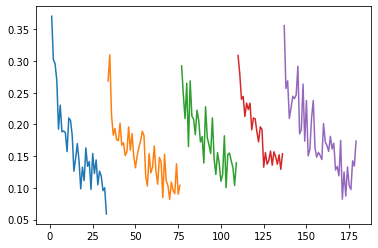

In [29]:
loss_plot(ewc_total_loss_dropout_big)

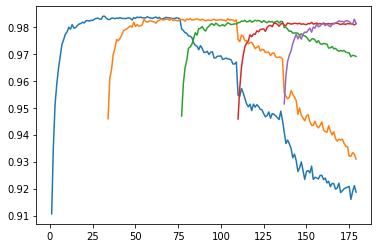

In [30]:
accuracy_plot(ewc_prec_dropout_big)

In [ ]:
#does higher lambda help to get better long term results?
mlp_consolidation_dropout_lambda = MLP(28*28, 10,
    hidden_size1,
    hidden_size1,
    hidden_dropout_prob,
    input_dropout_prob,
    2000,
)

utils.gaussian_initialize(mlp_consolidation_dropout_lambda)

# run the standard experiment.
consolidate = True
ewc_prec_dropout_lambda, ewc_total_loss_dropout_lambda, ewc_ce_loss_dropout_lambda, ewc_ewc_loss_dropout_lambda =train(
    mlp_consolidation_dropout_lambda, train_loader, test_loader,
    epochs_per_task,
    batch_size,
    test_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    eval_log_interval,
    loss_log_interval,
    cuda
)

=> task: 1/5 | epoch: 1/100 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.4018 / ewc: 0.0 / total: 0.4018: : 469it [00:04, 106.52it/s]


Validation loss decreased (inf --> 0.303605).  Saving model ...


=> task: 1/5 | epoch: 2/100 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2879 / ewc: 0.0 / total: 0.2879: : 469it [00:04, 107.42it/s]  


Validation loss decreased (0.303605 --> 0.211962).  Saving model ...


=> task: 1/5 | epoch: 3/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2202 / ewc: 0.0 / total: 0.2202: : 469it [00:04, 108.40it/s] 


Validation loss decreased (0.211962 --> 0.159356).  Saving model ...


=> task: 1/5 | epoch: 4/100 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2716 / ewc: 0.0 / total: 0.2716: : 469it [00:04, 108.69it/s]  


Validation loss decreased (0.159356 --> 0.134057).  Saving model ...


=> task: 1/5 | epoch: 5/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1857 / ewc: 0.0 / total: 0.1857: : 469it [00:04, 107.31it/s] 


Validation loss decreased (0.134057 --> 0.113754).  Saving model ...


=> task: 1/5 | epoch: 6/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.204 / ewc: 0.0 / total: 0.204: : 469it [00:04, 106.22it/s]    


Validation loss decreased (0.113754 --> 0.101303).  Saving model ...


=> task: 1/5 | epoch: 7/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2429 / ewc: 0.0 / total: 0.2429: : 469it [00:04, 108.07it/s] 


Validation loss decreased (0.101303 --> 0.096747).  Saving model ...


=> task: 1/5 | epoch: 8/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1675 / ewc: 0.0 / total: 0.1675: : 469it [00:04, 106.81it/s]  


Validation loss decreased (0.096747 --> 0.086807).  Saving model ...


=> task: 1/5 | epoch: 9/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1474 / ewc: 0.0 / total: 0.1474: : 469it [00:04, 115.00it/s]  


Validation loss decreased (0.086807 --> 0.083085).  Saving model ...


=> task: 1/5 | epoch: 10/100 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1669 / ewc: 0.0 / total: 0.1669: : 469it [00:04, 108.18it/s]  


Validation loss decreased (0.083085 --> 0.078822).  Saving model ...


=> task: 1/5 | epoch: 11/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2134 / ewc: 0.0 / total: 0.2134: : 469it [00:04, 107.57it/s] 


Validation loss decreased (0.078822 --> 0.074487).  Saving model ...


=> task: 1/5 | epoch: 12/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1382 / ewc: 0.0 / total: 0.1382: : 469it [00:03, 118.75it/s] 


Validation loss decreased (0.074487 --> 0.071208).  Saving model ...


=> task: 1/5 | epoch: 13/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1669 / ewc: 0.0 / total: 0.1669: : 469it [00:04, 107.78it/s]  


Validation loss decreased (0.071208 --> 0.069946).  Saving model ...


=> task: 1/5 | epoch: 14/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1414 / ewc: 0.0 / total: 0.1414: : 469it [00:04, 106.97it/s] 


EarlyStopping counter: 1 out of 5


=> task: 1/5 | epoch: 15/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1472 / ewc: 0.0 / total: 0.1472: : 469it [00:03, 121.31it/s]  


Validation loss decreased (0.069946 --> 0.068048).  Saving model ...


=> task: 1/5 | epoch: 16/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2101 / ewc: 0.0 / total: 0.2101: : 469it [00:04, 107.02it/s]  


Validation loss decreased (0.068048 --> 0.065101).  Saving model ...


=> task: 1/5 | epoch: 17/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1046 / ewc: 0.0 / total: 0.1046: : 469it [00:04, 106.63it/s]  


EarlyStopping counter: 1 out of 5


=> task: 1/5 | epoch: 18/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1439 / ewc: 0.0 / total: 0.1439: : 469it [00:04, 106.40it/s] 


Validation loss decreased (0.065101 --> 0.064050).  Saving model ...


=> task: 1/5 | epoch: 19/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2201 / ewc: 0.0 / total: 0.2201: : 469it [00:04, 107.60it/s] 


Validation loss decreased (0.064050 --> 0.063568).  Saving model ...


=> task: 1/5 | epoch: 20/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1556 / ewc: 0.0 / total: 0.1556: : 469it [00:04, 107.73it/s]    


Validation loss decreased (0.063568 --> 0.062778).  Saving model ...


=> task: 1/5 | epoch: 21/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1432 / ewc: 0.0 / total: 0.1432: : 469it [00:04, 107.14it/s] 


EarlyStopping counter: 1 out of 5


=> task: 1/5 | epoch: 22/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1412 / ewc: 0.0 / total: 0.1412: : 469it [00:03, 124.06it/s]  


EarlyStopping counter: 2 out of 5


=> task: 1/5 | epoch: 23/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1147 / ewc: 0.0 / total: 0.1147: : 469it [00:03, 125.28it/s]  


Validation loss decreased (0.062778 --> 0.060278).  Saving model ...


=> task: 1/5 | epoch: 24/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1578 / ewc: 0.0 / total: 0.1578: : 469it [00:04, 110.73it/s] 


Validation loss decreased (0.060278 --> 0.059629).  Saving model ...


=> task: 1/5 | epoch: 25/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09372 / ewc: 0.0 / total: 0.09372: : 469it [00:04, 107.74it/s] 


EarlyStopping counter: 1 out of 5


=> task: 1/5 | epoch: 26/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08853 / ewc: 0.0 / total: 0.08853: : 469it [00:04, 110.53it/s]


EarlyStopping counter: 2 out of 5


=> task: 1/5 | epoch: 27/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09397 / ewc: 0.0 / total: 0.09397: : 469it [00:04, 110.62it/s]  


EarlyStopping counter: 3 out of 5


=> task: 1/5 | epoch: 28/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1276 / ewc: 0.0 / total: 0.1276: : 469it [00:04, 110.43it/s]   


EarlyStopping counter: 4 out of 5


=> task: 1/5 | epoch: 29/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.167 / ewc: 0.0 / total: 0.167: : 469it [00:04, 110.82it/s]     


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 2/5 | epoch: 1/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.58it/s]               


Validation loss decreased (inf --> nan).  Saving model ...


=> task: 2/5 | epoch: 2/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.81it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 3/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.43it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 4/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.51it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 5/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.96it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 6/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.56it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 7/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.20it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 8/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.35it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 9/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:04, 94.19it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 10/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.52it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 11/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.76it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 12/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 83.74it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 13/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.26it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 14/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.75it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 15/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.62it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 16/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.41it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 17/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.56it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 18/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.36it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 19/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.85it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 20/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.77it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 21/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.32it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 22/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 93.30it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 23/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.59it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 24/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.33it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 25/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.71it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 26/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.74it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 27/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.03it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 28/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.27it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 29/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.52it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 30/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.00it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 31/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 84.30it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 32/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.52it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 33/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.64it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 34/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.58it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 35/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.30it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 36/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.49it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 37/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.90it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 38/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.39it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 39/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.34it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 40/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.37it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 41/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.39it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 42/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 78.30it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 43/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.60it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 44/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.13it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 45/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.63it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 46/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.14it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 47/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.41it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 48/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.43it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 49/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.94it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 50/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.10it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 51/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.00it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 52/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:06, 77.59it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 53/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.84it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 54/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.59it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 55/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.98it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 56/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.67it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 57/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.49it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 58/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.28it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 59/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.25it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 60/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.89it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 61/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.60it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 62/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.26it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 63/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.48it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 64/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.44it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 65/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.97it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 66/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.47it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 67/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.61it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 68/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 84.01it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 69/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.45it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 70/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 78.85it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 71/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.49it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 72/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.18it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 73/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.09it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 74/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.33it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 75/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.38it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 76/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.19it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 77/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.40it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 78/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.25it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 79/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.46it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 80/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.07it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 81/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.79it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 82/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.23it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 83/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.30it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 84/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.09it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 85/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.39it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 86/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 83.98it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 87/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.15it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 88/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.07it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 89/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.11it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 90/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.57it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 91/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.66it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 92/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.90it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 93/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.68it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 94/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.50it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 95/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.94it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 96/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.13it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 97/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.96it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 98/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.02it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 99/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.24it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 2/5 | epoch: 100/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.44it/s]


Validation loss decreased (nan --> nan).  Saving model ...
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 3/5 | epoch: 1/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.86it/s]


Validation loss decreased (inf --> nan).  Saving model ...


=> task: 3/5 | epoch: 2/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.79it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 3/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.42it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 4/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.05it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 5/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 78.83it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 6/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.24it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 7/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.44it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 8/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.24it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 9/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.67it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 10/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.21it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 11/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.14it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 12/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 84.23it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 13/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.50it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 14/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.69it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 15/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.35it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 16/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.31it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 17/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.16it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 18/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.08it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 19/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.45it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 20/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.17it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 21/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.44it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 22/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.52it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 23/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.58it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 24/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.20it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 25/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.21it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 26/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.64it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 27/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.71it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 28/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.98it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 29/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.22it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 30/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 84.97it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 31/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.27it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 32/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.08it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 33/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.76it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 34/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.00it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 35/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.13it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 36/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.17it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 37/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.39it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 38/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.90it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 39/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.24it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 40/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.61it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 41/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.85it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 42/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.20it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 43/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.00it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 44/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.48it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 45/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.06it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 46/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.46it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 47/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.33it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 48/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 84.70it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 49/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.55it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 50/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.86it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 51/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.61it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 52/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.54it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 53/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.03it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 54/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.59it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 55/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.29it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 56/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.97it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 57/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.14it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 58/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.18it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 59/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.30it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 60/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.14it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 61/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.95it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 62/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.62it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 63/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.46it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 64/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.35it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 65/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.12it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 66/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 85.17it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 67/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.92it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 68/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:06, 77.48it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 69/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:06, 77.93it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 70/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.21it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 71/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 78.26it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 72/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.72it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 73/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:06, 74.13it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 74/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.16it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 75/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.82it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 76/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.38it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 77/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.57it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 78/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.91it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 79/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.39it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 80/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.13it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 81/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.56it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 82/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 93.38it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 83/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:04, 93.89it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 84/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 82.50it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 85/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.94it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 86/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.51it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 87/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.52it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 88/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.00it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 89/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.90it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 90/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.24it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 91/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.06it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 92/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.50it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 93/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.33it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 94/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.31it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 95/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 79.68it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 96/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.45it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 97/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.13it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 98/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.32it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 99/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.29it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 3/5 | epoch: 100/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:05, 80.21it/s]


Validation loss decreased (nan --> nan).  Saving model ...
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 4/5 | epoch: 1/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:13, 35.57it/s]


Validation loss decreased (inf --> nan).  Saving model ...


=> task: 4/5 | epoch: 2/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:10, 45.01it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 3/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:10, 44.53it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 4/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:12, 38.54it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 5/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:10, 45.42it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 6/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:12, 38.03it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 7/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:10, 46.32it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 8/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:13, 34.11it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 9/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:09, 48.23it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 10/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:12, 38.39it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 11/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:10, 44.50it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 12/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:10, 46.78it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 13/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:11, 40.28it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 14/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:09, 49.08it/s] 


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 15/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:12, 38.23it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 16/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:10, 45.61it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 17/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:10, 42.98it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 18/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:11, 42.25it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 19/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:08, 55.79it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 20/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:10, 42.77it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 21/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:12, 36.31it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 22/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:10, 46.69it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 23/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:13, 35.73it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 24/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:09, 47.20it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 25/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:11, 39.97it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 26/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:10, 43.64it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 27/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:13, 35.89it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 28/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:09, 47.39it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 29/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:12, 36.73it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 30/100 | progress: [60032/60000] (100%) | prec: 0.09375 | loss => ce: nan / ewc: nan / total: nan: : 469it [00:10, 45.87it/s]


Validation loss decreased (nan --> nan).  Saving model ...


=> task: 4/5 | epoch: 31/100 | progress: [31488/60000] (52%) | prec: 0.1094 | loss => ce: nan / ewc: nan / total: nan: : 237it [00:06, 86.82it/s] 

In [ ]:
loss_plot(ewc_total_loss_dropout_lambda)

In [ ]:
accuracy_plot(ewc_prec_dropout_lambda)

In [32]:
#does even higher lambda + greater network size help to get better long term results + more epochs
mlp_consolidation_dropout_lambda_big = MLP(28*28, 10,
    1500,
    1000,
    hidden_dropout_prob,
    input_dropout_prob,
    3000,
)

utils.gaussian_initialize(mlp_consolidation_dropout_big)

# run the standard experiment.
consolidate = True
ewc_prec_dropout_lambda_big, ewc_total_loss_dropout_lambda_big, ewc_ce_loss_dropout_lambda_big, ewc_ewc_loss_dropout_lambda_big =train(
    mlp_consolidation_dropout_lambda_big, train_loader, test_loader,
    epochs_per_task,
    batch_size,
    test_size,
    consolidate,
    fisher_estimation_sample_size,
    5.e-2,
    weight_decay,
    eval_log_interval,
    loss_log_interval,
    cuda
)

=> task: 1/5 | epoch: 1/100 | progress: [60032/60000] (100%) | prec: 0.8958 | loss => ce: 0.4466 / ewc: 0.0 / total: 0.4466: : 469it [00:18, 25.02it/s]


Validation loss decreased (inf --> 0.355261).  Saving model ...


=> task: 1/5 | epoch: 2/100 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.3508 / ewc: 0.0 / total: 0.3508: : 469it [00:16, 27.94it/s] 


Validation loss decreased (0.355261 --> 0.269180).  Saving model ...


=> task: 1/5 | epoch: 3/100 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.3105 / ewc: 0.0 / total: 0.3105: : 469it [00:16, 28.30it/s]  


Validation loss decreased (0.269180 --> 0.219990).  Saving model ...


=> task: 1/5 | epoch: 4/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2524 / ewc: 0.0 / total: 0.2524: : 469it [00:15, 30.39it/s]  


Validation loss decreased (0.219990 --> 0.184289).  Saving model ...


=> task: 1/5 | epoch: 5/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2768 / ewc: 0.0 / total: 0.2768: : 469it [00:16, 27.98it/s] 


Validation loss decreased (0.184289 --> 0.158165).  Saving model ...


=> task: 1/5 | epoch: 6/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2577 / ewc: 0.0 / total: 0.2577: : 469it [00:16, 27.92it/s]  


Validation loss decreased (0.158165 --> 0.139008).  Saving model ...


=> task: 1/5 | epoch: 7/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2059 / ewc: 0.0 / total: 0.2059: : 469it [00:16, 27.71it/s] 


Validation loss decreased (0.139008 --> 0.125407).  Saving model ...


=> task: 1/5 | epoch: 8/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2259 / ewc: 0.0 / total: 0.2259: : 469it [00:16, 27.87it/s]  


Validation loss decreased (0.125407 --> 0.114531).  Saving model ...


=> task: 1/5 | epoch: 9/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2136 / ewc: 0.0 / total: 0.2136: : 469it [00:16, 27.94it/s]  


Validation loss decreased (0.114531 --> 0.104859).  Saving model ...


=> task: 1/5 | epoch: 10/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1917 / ewc: 0.0 / total: 0.1917: : 469it [00:16, 28.03it/s]  


Validation loss decreased (0.104859 --> 0.098441).  Saving model ...


=> task: 1/5 | epoch: 11/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1896 / ewc: 0.0 / total: 0.1896: : 469it [00:16, 28.27it/s]  


Validation loss decreased (0.098441 --> 0.092047).  Saving model ...


=> task: 1/5 | epoch: 12/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1779 / ewc: 0.0 / total: 0.1779: : 469it [00:16, 27.74it/s] 


Validation loss decreased (0.092047 --> 0.086720).  Saving model ...


=> task: 1/5 | epoch: 13/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1876 / ewc: 0.0 / total: 0.1876: : 469it [00:16, 28.40it/s] 


Validation loss decreased (0.086720 --> 0.082426).  Saving model ...


=> task: 1/5 | epoch: 14/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1962 / ewc: 0.0 / total: 0.1962: : 469it [00:16, 28.27it/s]  


Validation loss decreased (0.082426 --> 0.078711).  Saving model ...


=> task: 1/5 | epoch: 15/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1693 / ewc: 0.0 / total: 0.1693: : 469it [00:16, 27.88it/s] 


Validation loss decreased (0.078711 --> 0.075601).  Saving model ...


=> task: 1/5 | epoch: 16/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1667 / ewc: 0.0 / total: 0.1667: : 469it [00:16, 28.04it/s]  


Validation loss decreased (0.075601 --> 0.072140).  Saving model ...


=> task: 1/5 | epoch: 17/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1391 / ewc: 0.0 / total: 0.1391: : 469it [00:16, 28.03it/s] 


Validation loss decreased (0.072140 --> 0.070257).  Saving model ...


=> task: 1/5 | epoch: 18/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1644 / ewc: 0.0 / total: 0.1644: : 469it [00:16, 28.02it/s] 


Validation loss decreased (0.070257 --> 0.068558).  Saving model ...


=> task: 1/5 | epoch: 19/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1469 / ewc: 0.0 / total: 0.1469: : 469it [00:16, 28.00it/s]  


Validation loss decreased (0.068558 --> 0.066576).  Saving model ...


=> task: 1/5 | epoch: 20/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1637 / ewc: 0.0 / total: 0.1637: : 469it [00:16, 27.99it/s]  


Validation loss decreased (0.066576 --> 0.065754).  Saving model ...


=> task: 1/5 | epoch: 21/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1848 / ewc: 0.0 / total: 0.1848: : 469it [00:16, 28.18it/s] 


Validation loss decreased (0.065754 --> 0.063863).  Saving model ...


=> task: 1/5 | epoch: 22/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1583 / ewc: 0.0 / total: 0.1583: : 469it [00:16, 28.01it/s] 


Validation loss decreased (0.063863 --> 0.063360).  Saving model ...


=> task: 1/5 | epoch: 23/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1415 / ewc: 0.0 / total: 0.1415: : 469it [00:16, 28.08it/s]  


Validation loss decreased (0.063360 --> 0.061752).  Saving model ...


=> task: 1/5 | epoch: 24/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1614 / ewc: 0.0 / total: 0.1614: : 469it [00:16, 28.35it/s] 


Validation loss decreased (0.061752 --> 0.061292).  Saving model ...


=> task: 1/5 | epoch: 25/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1457 / ewc: 0.0 / total: 0.1457: : 469it [00:16, 28.03it/s] 


Validation loss decreased (0.061292 --> 0.060924).  Saving model ...


=> task: 1/5 | epoch: 26/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1496 / ewc: 0.0 / total: 0.1496: : 469it [00:16, 28.06it/s]  


Validation loss decreased (0.060924 --> 0.059093).  Saving model ...


=> task: 1/5 | epoch: 27/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1699 / ewc: 0.0 / total: 0.1699: : 469it [00:16, 28.22it/s]   


Validation loss decreased (0.059093 --> 0.057591).  Saving model ...


=> task: 1/5 | epoch: 28/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1682 / ewc: 0.0 / total: 0.1682: : 469it [00:16, 28.10it/s]   


EarlyStopping counter: 1 out of 5


=> task: 1/5 | epoch: 29/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1366 / ewc: 0.0 / total: 0.1366: : 469it [00:16, 28.05it/s]   


EarlyStopping counter: 2 out of 5


=> task: 1/5 | epoch: 30/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1562 / ewc: 0.0 / total: 0.1562: : 469it [00:16, 27.67it/s]   


Validation loss decreased (0.057591 --> 0.056107).  Saving model ...


=> task: 1/5 | epoch: 31/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1587 / ewc: 0.0 / total: 0.1587: : 469it [00:16, 28.29it/s]  


EarlyStopping counter: 1 out of 5


=> task: 1/5 | epoch: 32/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1354 / ewc: 0.0 / total: 0.1354: : 469it [00:16, 28.09it/s]  


Validation loss decreased (0.056107 --> 0.055629).  Saving model ...


=> task: 1/5 | epoch: 33/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1264 / ewc: 0.0 / total: 0.1264: : 469it [00:16, 28.10it/s] 


Validation loss decreased (0.055629 --> 0.055580).  Saving model ...


=> task: 1/5 | epoch: 34/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09118 / ewc: 0.0 / total: 0.09118: : 469it [00:16, 28.02it/s]


EarlyStopping counter: 1 out of 5


=> task: 1/5 | epoch: 35/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1209 / ewc: 0.0 / total: 0.1209: : 469it [00:16, 28.13it/s] 


Validation loss decreased (0.055580 --> 0.055415).  Saving model ...


=> task: 1/5 | epoch: 36/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1053 / ewc: 0.0 / total: 0.1053: : 469it [00:16, 28.05it/s]  


Validation loss decreased (0.055415 --> 0.054152).  Saving model ...


=> task: 1/5 | epoch: 37/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09584 / ewc: 0.0 / total: 0.09584: : 469it [00:16, 28.94it/s]


EarlyStopping counter: 1 out of 5


=> task: 1/5 | epoch: 38/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1284 / ewc: 0.0 / total: 0.1284: : 469it [00:16, 28.82it/s]  


EarlyStopping counter: 2 out of 5


=> task: 1/5 | epoch: 39/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07943 / ewc: 0.0 / total: 0.07943: : 469it [00:16, 28.13it/s] 


EarlyStopping counter: 3 out of 5


=> task: 1/5 | epoch: 40/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1082 / ewc: 0.0 / total: 0.1082: : 469it [00:16, 28.37it/s]   


EarlyStopping counter: 4 out of 5


=> task: 1/5 | epoch: 41/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07943 / ewc: 0.0 / total: 0.07943: : 469it [00:16, 28.10it/s] 


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 2/5 | epoch: 1/100 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.291 / ewc: 0.032 / total: 0.323: : 469it [00:31, 15.03it/s]     


Validation loss decreased (inf --> 0.213890).  Saving model ...


=> task: 2/5 | epoch: 2/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2115 / ewc: 0.02469 / total: 0.2362: : 469it [00:32, 14.55it/s] 


Validation loss decreased (0.213890 --> 0.160259).  Saving model ...


=> task: 2/5 | epoch: 3/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2251 / ewc: 0.02175 / total: 0.2469: : 469it [00:31, 14.90it/s] 


Validation loss decreased (0.160259 --> 0.137897).  Saving model ...


=> task: 2/5 | epoch: 4/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1907 / ewc: 0.01986 / total: 0.2106: : 469it [00:32, 14.63it/s]  


Validation loss decreased (0.137897 --> 0.125164).  Saving model ...


=> task: 2/5 | epoch: 5/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2228 / ewc: 0.01873 / total: 0.2415: : 469it [00:31, 14.73it/s] 


Validation loss decreased (0.125164 --> 0.118099).  Saving model ...


=> task: 2/5 | epoch: 6/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1797 / ewc: 0.01734 / total: 0.197: : 469it [00:32, 14.63it/s]  


Validation loss decreased (0.118099 --> 0.107577).  Saving model ...


=> task: 2/5 | epoch: 7/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1769 / ewc: 0.01666 / total: 0.1935: : 469it [00:31, 14.75it/s] 


Validation loss decreased (0.107577 --> 0.105781).  Saving model ...


=> task: 2/5 | epoch: 8/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1648 / ewc: 0.01583 / total: 0.1807: : 469it [00:31, 14.70it/s] 


Validation loss decreased (0.105781 --> 0.099248).  Saving model ...


=> task: 2/5 | epoch: 9/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1899 / ewc: 0.01529 / total: 0.2052: : 469it [00:32, 14.60it/s] 


Validation loss decreased (0.099248 --> 0.096561).  Saving model ...


=> task: 2/5 | epoch: 10/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1576 / ewc: 0.01476 / total: 0.1723: : 469it [00:32, 14.57it/s] 


Validation loss decreased (0.096561 --> 0.094524).  Saving model ...


=> task: 2/5 | epoch: 11/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1259 / ewc: 0.01443 / total: 0.1404: : 469it [00:31, 14.67it/s] 


Validation loss decreased (0.094524 --> 0.091782).  Saving model ...


=> task: 2/5 | epoch: 12/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1954 / ewc: 0.01411 / total: 0.2095: : 469it [00:31, 14.80it/s] 


Validation loss decreased (0.091782 --> 0.090499).  Saving model ...


=> task: 2/5 | epoch: 13/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1684 / ewc: 0.01365 / total: 0.182: : 469it [00:32, 14.53it/s]  


Validation loss decreased (0.090499 --> 0.087762).  Saving model ...


=> task: 2/5 | epoch: 14/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1943 / ewc: 0.01338 / total: 0.2077: : 469it [00:31, 14.95it/s] 


Validation loss decreased (0.087762 --> 0.086411).  Saving model ...


=> task: 2/5 | epoch: 15/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.183 / ewc: 0.01299 / total: 0.196: : 469it [00:32, 14.52it/s]   


Validation loss decreased (0.086411 --> 0.085165).  Saving model ...


=> task: 2/5 | epoch: 16/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1279 / ewc: 0.01291 / total: 0.1408: : 469it [00:32, 14.56it/s] 


Validation loss decreased (0.085165 --> 0.084428).  Saving model ...


=> task: 2/5 | epoch: 17/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1243 / ewc: 0.01247 / total: 0.1367: : 469it [00:31, 15.06it/s] 


Validation loss decreased (0.084428 --> 0.083213).  Saving model ...


=> task: 2/5 | epoch: 18/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1735 / ewc: 0.01229 / total: 0.1858: : 469it [00:32, 14.57it/s] 


Validation loss decreased (0.083213 --> 0.082196).  Saving model ...


=> task: 2/5 | epoch: 19/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1531 / ewc: 0.01196 / total: 0.1651: : 469it [00:32, 14.64it/s] 


Validation loss decreased (0.082196 --> 0.079555).  Saving model ...


=> task: 2/5 | epoch: 20/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1341 / ewc: 0.01175 / total: 0.1459: : 469it [00:31, 15.07it/s] 


Validation loss decreased (0.079555 --> 0.078798).  Saving model ...


=> task: 2/5 | epoch: 21/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1777 / ewc: 0.01181 / total: 0.1895: : 469it [00:32, 14.62it/s]  


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 22/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1239 / ewc: 0.01153 / total: 0.1354: : 469it [00:32, 14.57it/s]  


Validation loss decreased (0.078798 --> 0.077818).  Saving model ...


=> task: 2/5 | epoch: 23/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1441 / ewc: 0.01134 / total: 0.1555: : 469it [00:32, 14.55it/s] 


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 24/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.131 / ewc: 0.01124 / total: 0.1422: : 469it [00:31, 14.68it/s]  


Validation loss decreased (0.077818 --> 0.075496).  Saving model ...


=> task: 2/5 | epoch: 25/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.128 / ewc: 0.01095 / total: 0.139: : 469it [00:32, 14.55it/s]   


Validation loss decreased (0.075496 --> 0.075149).  Saving model ...


=> task: 2/5 | epoch: 26/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1404 / ewc: 0.01086 / total: 0.1512: : 469it [00:32, 14.57it/s] 


Validation loss decreased (0.075149 --> 0.074410).  Saving model ...


=> task: 2/5 | epoch: 27/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1465 / ewc: 0.01071 / total: 0.1572: : 469it [00:32, 14.54it/s]  


Validation loss decreased (0.074410 --> 0.073957).  Saving model ...


=> task: 2/5 | epoch: 28/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1727 / ewc: 0.01045 / total: 0.1831: : 469it [00:31, 14.81it/s] 


Validation loss decreased (0.073957 --> 0.072864).  Saving model ...


=> task: 2/5 | epoch: 29/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1495 / ewc: 0.01044 / total: 0.1599: : 469it [00:32, 14.47it/s] 


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 30/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1368 / ewc: 0.01026 / total: 0.1471: : 469it [00:32, 14.55it/s] 


Validation loss decreased (0.072864 --> 0.072555).  Saving model ...


=> task: 2/5 | epoch: 31/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09962 / ewc: 0.01004 / total: 0.1097: : 469it [00:31, 14.67it/s] 


Validation loss decreased (0.072555 --> 0.070858).  Saving model ...


=> task: 2/5 | epoch: 32/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1306 / ewc: 0.01014 / total: 0.1407: : 469it [00:32, 14.61it/s]  


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 33/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1082 / ewc: 0.009959 / total: 0.1182: : 469it [00:30, 15.32it/s] 


EarlyStopping counter: 2 out of 5


=> task: 2/5 | epoch: 34/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1433 / ewc: 0.009819 / total: 0.1531: : 469it [00:31, 14.78it/s] 


EarlyStopping counter: 3 out of 5


=> task: 2/5 | epoch: 35/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1122 / ewc: 0.009641 / total: 0.1218: : 469it [00:31, 14.98it/s] 


Validation loss decreased (0.070858 --> 0.070209).  Saving model ...


=> task: 2/5 | epoch: 36/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1092 / ewc: 0.009668 / total: 0.1189: : 469it [00:32, 14.53it/s] 


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 37/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1686 / ewc: 0.009481 / total: 0.1781: : 469it [00:29, 15.74it/s] 


Validation loss decreased (0.070209 --> 0.068824).  Saving model ...


=> task: 2/5 | epoch: 38/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1728 / ewc: 0.009463 / total: 0.1822: : 469it [00:32, 14.61it/s]   


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 39/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1293 / ewc: 0.009266 / total: 0.1386: : 469it [00:31, 14.86it/s] 


Validation loss decreased (0.068824 --> 0.068728).  Saving model ...


=> task: 2/5 | epoch: 40/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1379 / ewc: 0.009094 / total: 0.147: : 469it [00:32, 14.54it/s]   


Validation loss decreased (0.068728 --> 0.068018).  Saving model ...


=> task: 2/5 | epoch: 41/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1454 / ewc: 0.008993 / total: 0.1544: : 469it [00:32, 14.53it/s]  


Validation loss decreased (0.068018 --> 0.067889).  Saving model ...


=> task: 2/5 | epoch: 42/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.131 / ewc: 0.00898 / total: 0.14: : 469it [00:31, 14.77it/s]     


Validation loss decreased (0.067889 --> 0.067027).  Saving model ...


=> task: 2/5 | epoch: 43/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1439 / ewc: 0.008914 / total: 0.1529: : 469it [00:31, 15.12it/s] 


Validation loss decreased (0.067027 --> 0.066996).  Saving model ...


=> task: 2/5 | epoch: 44/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.115 / ewc: 0.008734 / total: 0.1237: : 469it [00:32, 14.54it/s]   


Validation loss decreased (0.066996 --> 0.066152).  Saving model ...


=> task: 2/5 | epoch: 45/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1172 / ewc: 0.008661 / total: 0.1258: : 469it [00:32, 14.55it/s] 


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 46/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1205 / ewc: 0.008616 / total: 0.1291: : 469it [00:32, 14.54it/s] 


Validation loss decreased (0.066152 --> 0.065956).  Saving model ...


=> task: 2/5 | epoch: 47/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09559 / ewc: 0.008618 / total: 0.1042: : 469it [00:32, 14.53it/s]


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 48/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1333 / ewc: 0.008408 / total: 0.1417: : 469it [00:31, 14.69it/s]  


Validation loss decreased (0.065956 --> 0.065848).  Saving model ...


=> task: 2/5 | epoch: 49/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1198 / ewc: 0.008539 / total: 0.1283: : 469it [00:31, 14.97it/s] 


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 50/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1039 / ewc: 0.008343 / total: 0.1122: : 469it [00:32, 14.61it/s]  


Validation loss decreased (0.065848 --> 0.065762).  Saving model ...


=> task: 2/5 | epoch: 51/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1273 / ewc: 0.008203 / total: 0.1355: : 469it [00:32, 14.52it/s]  


Validation loss decreased (0.065762 --> 0.064535).  Saving model ...


=> task: 2/5 | epoch: 52/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08264 / ewc: 0.00813 / total: 0.09077: : 469it [00:32, 14.59it/s] 


Validation loss decreased (0.064535 --> 0.064191).  Saving model ...


=> task: 2/5 | epoch: 53/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09715 / ewc: 0.008134 / total: 0.1053: : 469it [00:32, 14.53it/s] 


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 54/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1318 / ewc: 0.00804 / total: 0.1398: : 469it [00:32, 14.53it/s]   


EarlyStopping counter: 2 out of 5


=> task: 2/5 | epoch: 55/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1024 / ewc: 0.007956 / total: 0.1103: : 469it [00:32, 14.65it/s] 


Validation loss decreased (0.064191 --> 0.064128).  Saving model ...


=> task: 2/5 | epoch: 56/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1053 / ewc: 0.008034 / total: 0.1133: : 469it [00:31, 14.94it/s] 


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 57/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0881 / ewc: 0.007813 / total: 0.09592: : 469it [00:32, 14.61it/s] 


Validation loss decreased (0.064128 --> 0.063479).  Saving model ...


=> task: 2/5 | epoch: 58/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1148 / ewc: 0.007793 / total: 0.1226: : 469it [00:32, 14.51it/s] 


Validation loss decreased (0.063479 --> 0.063231).  Saving model ...


=> task: 2/5 | epoch: 59/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1121 / ewc: 0.007732 / total: 0.1199: : 469it [00:32, 14.58it/s] 


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 60/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09479 / ewc: 0.007652 / total: 0.1024: : 469it [00:32, 14.52it/s]


EarlyStopping counter: 2 out of 5


=> task: 2/5 | epoch: 61/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09904 / ewc: 0.00776 / total: 0.1068: : 469it [00:32, 14.53it/s] 


EarlyStopping counter: 3 out of 5


=> task: 2/5 | epoch: 62/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08418 / ewc: 0.007613 / total: 0.0918: : 469it [00:32, 14.58it/s] 


Validation loss decreased (0.063231 --> 0.063097).  Saving model ...


=> task: 2/5 | epoch: 63/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1035 / ewc: 0.0075 / total: 0.111: : 469it [00:32, 14.64it/s]    


Validation loss decreased (0.063097 --> 0.062750).  Saving model ...


=> task: 2/5 | epoch: 64/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1114 / ewc: 0.007434 / total: 0.1188: : 469it [00:37, 12.41it/s] 


Validation loss decreased (0.062750 --> 0.062655).  Saving model ...


=> task: 2/5 | epoch: 65/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1076 / ewc: 0.007296 / total: 0.1149: : 469it [00:48,  9.72it/s]  


Validation loss decreased (0.062655 --> 0.062651).  Saving model ...


=> task: 2/5 | epoch: 66/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1077 / ewc: 0.007373 / total: 0.1151: : 469it [00:47,  9.93it/s]  


Validation loss decreased (0.062651 --> 0.062338).  Saving model ...


=> task: 2/5 | epoch: 67/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06732 / ewc: 0.007334 / total: 0.07466: : 469it [00:43, 10.78it/s]


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 68/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0831 / ewc: 0.007282 / total: 0.09038: : 469it [00:43, 10.78it/s] 


EarlyStopping counter: 2 out of 5


=> task: 2/5 | epoch: 69/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1012 / ewc: 0.007239 / total: 0.1084: : 469it [00:46, 10.06it/s]  


Validation loss decreased (0.062338 --> 0.062180).  Saving model ...


=> task: 2/5 | epoch: 70/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09315 / ewc: 0.007164 / total: 0.1003: : 469it [00:43, 10.84it/s] 


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 71/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07122 / ewc: 0.007 / total: 0.07822: : 469it [00:43, 10.89it/s]   


Validation loss decreased (0.062180 --> 0.061991).  Saving model ...


=> task: 2/5 | epoch: 72/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08799 / ewc: 0.007016 / total: 0.095: : 469it [00:44, 10.60it/s]  


Validation loss decreased (0.061991 --> 0.061594).  Saving model ...


=> task: 2/5 | epoch: 73/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08605 / ewc: 0.006943 / total: 0.09299: : 469it [00:47,  9.86it/s]


Validation loss decreased (0.061594 --> 0.061262).  Saving model ...


=> task: 2/5 | epoch: 74/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09318 / ewc: 0.006933 / total: 0.1001: : 469it [00:44, 10.56it/s] 


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 75/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1094 / ewc: 0.006805 / total: 0.1162: : 469it [00:42, 10.95it/s]  


Validation loss decreased (0.061262 --> 0.061129).  Saving model ...


=> task: 2/5 | epoch: 76/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05261 / ewc: 0.006732 / total: 0.05934: : 469it [00:47,  9.97it/s]


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 77/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08583 / ewc: 0.006681 / total: 0.09251: : 469it [00:48,  9.67it/s]


EarlyStopping counter: 2 out of 5


=> task: 2/5 | epoch: 78/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09734 / ewc: 0.0068 / total: 0.1041: : 469it [00:46, 10.16it/s]   


Validation loss decreased (0.061129 --> 0.060654).  Saving model ...


=> task: 2/5 | epoch: 79/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08608 / ewc: 0.006767 / total: 0.09284: : 469it [00:46, 10.14it/s] 


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 80/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0794 / ewc: 0.00662 / total: 0.08602: : 469it [00:46, 10.19it/s]  


EarlyStopping counter: 2 out of 5


=> task: 2/5 | epoch: 81/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0716 / ewc: 0.006647 / total: 0.07824: : 469it [00:46, 10.18it/s] 


EarlyStopping counter: 3 out of 5


=> task: 2/5 | epoch: 82/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04811 / ewc: 0.006645 / total: 0.05475: : 469it [00:47,  9.92it/s]


EarlyStopping counter: 4 out of 5


=> task: 2/5 | epoch: 83/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.07493 / ewc: 0.006548 / total: 0.08147: : 469it [00:42, 10.91it/s]


Validation loss decreased (0.060654 --> 0.060639).  Saving model ...


=> task: 2/5 | epoch: 84/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0807 / ewc: 0.006576 / total: 0.08727: : 469it [00:44, 10.61it/s] 


Validation loss decreased (0.060639 --> 0.060052).  Saving model ...


=> task: 2/5 | epoch: 85/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07779 / ewc: 0.006368 / total: 0.08416: : 469it [00:46, 10.11it/s]


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 86/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06587 / ewc: 0.006436 / total: 0.07231: : 469it [00:46, 10.10it/s] 


Validation loss decreased (0.060052 --> 0.059944).  Saving model ...


=> task: 2/5 | epoch: 87/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09208 / ewc: 0.006452 / total: 0.09853: : 469it [00:43, 10.84it/s]


Validation loss decreased (0.059944 --> 0.059804).  Saving model ...


=> task: 2/5 | epoch: 88/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0813 / ewc: 0.006307 / total: 0.08761: : 469it [00:43, 10.90it/s] 


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 89/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06154 / ewc: 0.006307 / total: 0.06785: : 469it [00:46, 10.03it/s]


EarlyStopping counter: 2 out of 5


=> task: 2/5 | epoch: 90/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06745 / ewc: 0.006279 / total: 0.07372: : 469it [00:46, 10.06it/s]


Validation loss decreased (0.059804 --> 0.059391).  Saving model ...


=> task: 2/5 | epoch: 91/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06864 / ewc: 0.00655 / total: 0.07519: : 469it [00:44, 10.63it/s]


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 92/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09033 / ewc: 0.006147 / total: 0.09648: : 469it [00:44, 10.63it/s]


EarlyStopping counter: 2 out of 5


=> task: 2/5 | epoch: 93/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05188 / ewc: 0.006366 / total: 0.05824: : 469it [00:46, 10.07it/s]


EarlyStopping counter: 3 out of 5


=> task: 2/5 | epoch: 94/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06388 / ewc: 0.006128 / total: 0.07001: : 469it [00:46, 10.10it/s]


Validation loss decreased (0.059391 --> 0.059156).  Saving model ...


=> task: 2/5 | epoch: 95/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05328 / ewc: 0.006034 / total: 0.05931: : 469it [00:44, 10.65it/s]


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 96/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06289 / ewc: 0.006087 / total: 0.06898: : 469it [00:43, 10.81it/s]


Validation loss decreased (0.059156 --> 0.058804).  Saving model ...


=> task: 2/5 | epoch: 97/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04873 / ewc: 0.006005 / total: 0.05474: : 469it [00:46,  9.99it/s]


Validation loss decreased (0.058804 --> 0.058461).  Saving model ...


=> task: 2/5 | epoch: 98/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.07465 / ewc: 0.005984 / total: 0.08063: : 469it [00:46, 10.09it/s]


EarlyStopping counter: 1 out of 5


=> task: 2/5 | epoch: 99/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04546 / ewc: 0.006039 / total: 0.0515: : 469it [00:45, 10.40it/s] 


EarlyStopping counter: 2 out of 5


=> task: 2/5 | epoch: 100/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05071 / ewc: 0.005841 / total: 0.05655: : 469it [00:44, 10.61it/s]


EarlyStopping counter: 3 out of 5
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 3/5 | epoch: 1/100 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.2733 / ewc: 0.0282 / total: 0.3015: : 469it [00:52,  8.94it/s]   


Validation loss decreased (inf --> 0.196412).  Saving model ...


=> task: 3/5 | epoch: 2/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2293 / ewc: 0.02301 / total: 0.2523: : 469it [00:50,  9.32it/s] 


Validation loss decreased (0.196412 --> 0.155672).  Saving model ...


=> task: 3/5 | epoch: 3/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2273 / ewc: 0.02031 / total: 0.2476: : 469it [00:48,  9.61it/s] 


Validation loss decreased (0.155672 --> 0.134199).  Saving model ...


=> task: 3/5 | epoch: 4/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.193 / ewc: 0.01861 / total: 0.2116: : 469it [00:48,  9.69it/s]  


Validation loss decreased (0.134199 --> 0.121756).  Saving model ...


=> task: 3/5 | epoch: 5/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1821 / ewc: 0.01743 / total: 0.1995: : 469it [00:50,  9.32it/s] 


Validation loss decreased (0.121756 --> 0.115021).  Saving model ...


=> task: 3/5 | epoch: 6/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1871 / ewc: 0.01645 / total: 0.2036: : 469it [00:50,  9.31it/s] 


Validation loss decreased (0.115021 --> 0.106392).  Saving model ...


=> task: 3/5 | epoch: 7/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1721 / ewc: 0.01568 / total: 0.1878: : 469it [00:48,  9.70it/s] 


Validation loss decreased (0.106392 --> 0.101404).  Saving model ...


=> task: 3/5 | epoch: 8/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1844 / ewc: 0.01507 / total: 0.1995: : 469it [00:48,  9.62it/s] 


Validation loss decreased (0.101404 --> 0.098168).  Saving model ...


=> task: 3/5 | epoch: 9/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1839 / ewc: 0.01443 / total: 0.1983: : 469it [00:49,  9.50it/s] 


Validation loss decreased (0.098168 --> 0.094600).  Saving model ...


=> task: 3/5 | epoch: 10/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1621 / ewc: 0.01405 / total: 0.1761: : 469it [00:50,  9.34it/s] 


Validation loss decreased (0.094600 --> 0.091663).  Saving model ...


=> task: 3/5 | epoch: 11/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1577 / ewc: 0.01362 / total: 0.1713: : 469it [00:50,  9.26it/s] 


Validation loss decreased (0.091663 --> 0.087057).  Saving model ...


=> task: 3/5 | epoch: 12/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1427 / ewc: 0.01325 / total: 0.156: : 469it [00:51,  9.13it/s]  


Validation loss decreased (0.087057 --> 0.085146).  Saving model ...


=> task: 3/5 | epoch: 13/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1365 / ewc: 0.01289 / total: 0.1494: : 469it [00:52,  8.99it/s] 


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 14/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1445 / ewc: 0.01268 / total: 0.1572: : 469it [00:49,  9.43it/s] 


Validation loss decreased (0.085146 --> 0.083828).  Saving model ...


=> task: 3/5 | epoch: 15/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1737 / ewc: 0.01225 / total: 0.186: : 469it [00:47,  9.92it/s]  


Validation loss decreased (0.083828 --> 0.080994).  Saving model ...


=> task: 3/5 | epoch: 16/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1435 / ewc: 0.01191 / total: 0.1554: : 469it [00:47,  9.87it/s] 


Validation loss decreased (0.080994 --> 0.080315).  Saving model ...


=> task: 3/5 | epoch: 17/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.147 / ewc: 0.01181 / total: 0.1588: : 469it [00:29, 15.73it/s]  


Validation loss decreased (0.080315 --> 0.078428).  Saving model ...


=> task: 3/5 | epoch: 18/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1579 / ewc: 0.01142 / total: 0.1693: : 469it [00:27, 16.78it/s] 


Validation loss decreased (0.078428 --> 0.078218).  Saving model ...


=> task: 3/5 | epoch: 19/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1091 / ewc: 0.01124 / total: 0.1203: : 469it [00:27, 17.15it/s] 


Validation loss decreased (0.078218 --> 0.076735).  Saving model ...


=> task: 3/5 | epoch: 20/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1308 / ewc: 0.01118 / total: 0.142: : 469it [00:26, 17.44it/s]  


Validation loss decreased (0.076735 --> 0.076455).  Saving model ...


=> task: 3/5 | epoch: 21/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1234 / ewc: 0.01085 / total: 0.1342: : 469it [00:27, 16.88it/s] 


Validation loss decreased (0.076455 --> 0.074781).  Saving model ...


=> task: 3/5 | epoch: 22/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.144 / ewc: 0.0107 / total: 0.1546: : 469it [00:27, 16.95it/s]   


Validation loss decreased (0.074781 --> 0.073322).  Saving model ...


=> task: 3/5 | epoch: 23/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.119 / ewc: 0.01043 / total: 0.1294: : 469it [00:27, 17.09it/s]  


Validation loss decreased (0.073322 --> 0.072859).  Saving model ...


=> task: 3/5 | epoch: 24/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1178 / ewc: 0.01035 / total: 0.1281: : 469it [00:27, 16.97it/s]  


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 25/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1105 / ewc: 0.01016 / total: 0.1207: : 469it [00:27, 16.90it/s] 


Validation loss decreased (0.072859 --> 0.072011).  Saving model ...


=> task: 3/5 | epoch: 26/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1303 / ewc: 0.01005 / total: 0.1404: : 469it [00:28, 16.71it/s]   


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 27/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1418 / ewc: 0.009857 / total: 0.1517: : 469it [00:28, 16.71it/s]  


EarlyStopping counter: 2 out of 5


=> task: 3/5 | epoch: 28/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1446 / ewc: 0.009703 / total: 0.1543: : 469it [00:27, 17.20it/s] 


Validation loss decreased (0.072011 --> 0.070544).  Saving model ...


=> task: 3/5 | epoch: 29/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1052 / ewc: 0.009551 / total: 0.1148: : 469it [00:28, 16.45it/s] 


Validation loss decreased (0.070544 --> 0.069821).  Saving model ...


=> task: 3/5 | epoch: 30/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09154 / ewc: 0.009468 / total: 0.101: : 469it [00:27, 16.89it/s]  


Validation loss decreased (0.069821 --> 0.069078).  Saving model ...


=> task: 3/5 | epoch: 31/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1052 / ewc: 0.009334 / total: 0.1145: : 469it [00:28, 16.45it/s] 


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 32/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08901 / ewc: 0.009193 / total: 0.0982: : 469it [00:28, 16.65it/s] 


Validation loss decreased (0.069078 --> 0.068027).  Saving model ...


=> task: 3/5 | epoch: 33/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08538 / ewc: 0.009075 / total: 0.09445: : 469it [00:24, 18.81it/s]


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 34/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08281 / ewc: 0.008935 / total: 0.09175: : 469it [00:28, 16.59it/s]


Validation loss decreased (0.068027 --> 0.067617).  Saving model ...


=> task: 3/5 | epoch: 35/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1401 / ewc: 0.008908 / total: 0.149: : 469it [00:28, 16.57it/s]  


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 36/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1184 / ewc: 0.008668 / total: 0.127: : 469it [00:28, 16.49it/s]    


EarlyStopping counter: 2 out of 5


=> task: 3/5 | epoch: 37/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09536 / ewc: 0.008664 / total: 0.104: : 469it [00:27, 16.92it/s]  


EarlyStopping counter: 3 out of 5


=> task: 3/5 | epoch: 38/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0782 / ewc: 0.00847 / total: 0.08667: : 469it [00:28, 16.47it/s]  


Validation loss decreased (0.067617 --> 0.067339).  Saving model ...


=> task: 3/5 | epoch: 39/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09275 / ewc: 0.008455 / total: 0.1012: : 469it [00:28, 16.53it/s] 


Validation loss decreased (0.067339 --> 0.066642).  Saving model ...


=> task: 3/5 | epoch: 40/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08224 / ewc: 0.008348 / total: 0.09059: : 469it [00:28, 16.50it/s]


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 41/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09633 / ewc: 0.008206 / total: 0.1045: : 469it [00:28, 16.50it/s]


Validation loss decreased (0.066642 --> 0.065546).  Saving model ...


=> task: 3/5 | epoch: 42/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1005 / ewc: 0.008168 / total: 0.1086: : 469it [00:28, 16.47it/s] 


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 43/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08829 / ewc: 0.008075 / total: 0.09637: : 469it [00:28, 16.55it/s]


EarlyStopping counter: 2 out of 5


=> task: 3/5 | epoch: 44/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1127 / ewc: 0.007984 / total: 0.1207: : 469it [00:28, 16.47it/s]  


Validation loss decreased (0.065546 --> 0.065078).  Saving model ...


=> task: 3/5 | epoch: 45/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1063 / ewc: 0.007933 / total: 0.1142: : 469it [00:29, 15.91it/s]  


Validation loss decreased (0.065078 --> 0.064340).  Saving model ...


=> task: 3/5 | epoch: 46/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09538 / ewc: 0.007859 / total: 0.1032: : 469it [00:28, 16.45it/s] 


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 47/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.08668 / ewc: 0.007645 / total: 0.09432: : 469it [00:27, 16.76it/s]


Validation loss decreased (0.064340 --> 0.063902).  Saving model ...


=> task: 3/5 | epoch: 48/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05591 / ewc: 0.007684 / total: 0.06359: : 469it [00:28, 16.48it/s]


Validation loss decreased (0.063902 --> 0.063105).  Saving model ...


=> task: 3/5 | epoch: 49/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07973 / ewc: 0.00751 / total: 0.08724: : 469it [00:28, 16.50it/s] 


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 50/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08701 / ewc: 0.00742 / total: 0.09443: : 469it [00:28, 16.66it/s] 


EarlyStopping counter: 2 out of 5


=> task: 3/5 | epoch: 51/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09224 / ewc: 0.007458 / total: 0.0997: : 469it [00:28, 16.51it/s] 


EarlyStopping counter: 3 out of 5


=> task: 3/5 | epoch: 52/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04373 / ewc: 0.007341 / total: 0.05107: : 469it [00:28, 16.50it/s]


Validation loss decreased (0.063105 --> 0.062927).  Saving model ...


=> task: 3/5 | epoch: 53/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.02918 / ewc: 0.007259 / total: 0.03644: : 469it [00:28, 16.44it/s]


Validation loss decreased (0.062927 --> 0.062762).  Saving model ...


=> task: 3/5 | epoch: 54/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07054 / ewc: 0.007149 / total: 0.07769: : 469it [00:28, 16.38it/s]


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 55/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.09001 / ewc: 0.00719 / total: 0.0972: : 469it [00:28, 16.49it/s]  


Validation loss decreased (0.062762 --> 0.062385).  Saving model ...


=> task: 3/5 | epoch: 56/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0898 / ewc: 0.007181 / total: 0.09698: : 469it [00:28, 16.54it/s] 


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 57/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.079 / ewc: 0.006936 / total: 0.08594: : 469it [00:27, 17.05it/s]  


EarlyStopping counter: 2 out of 5


=> task: 3/5 | epoch: 58/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.03632 / ewc: 0.007 / total: 0.04332: : 469it [00:27, 16.85it/s]  


Validation loss decreased (0.062385 --> 0.061951).  Saving model ...


=> task: 3/5 | epoch: 59/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06588 / ewc: 0.006859 / total: 0.07274: : 469it [00:28, 16.43it/s]


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 60/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.01873 / ewc: 0.006826 / total: 0.02556: : 469it [00:28, 16.46it/s]


Validation loss decreased (0.061951 --> 0.061027).  Saving model ...


=> task: 3/5 | epoch: 61/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04659 / ewc: 0.006758 / total: 0.05335: : 469it [00:28, 16.48it/s]


EarlyStopping counter: 1 out of 5


=> task: 3/5 | epoch: 62/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05769 / ewc: 0.006884 / total: 0.06458: : 469it [00:28, 16.56it/s]


EarlyStopping counter: 2 out of 5


=> task: 3/5 | epoch: 63/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05887 / ewc: 0.006692 / total: 0.06556: : 469it [00:28, 16.42it/s]


EarlyStopping counter: 3 out of 5


=> task: 3/5 | epoch: 64/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0511 / ewc: 0.006611 / total: 0.05771: : 469it [00:26, 17.57it/s] 


EarlyStopping counter: 4 out of 5


=> task: 3/5 | epoch: 65/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04434 / ewc: 0.006552 / total: 0.05089: : 469it [00:27, 17.26it/s]


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 4/5 | epoch: 1/100 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.3624 / ewc: 0.02375 / total: 0.3861: : 469it [00:28, 16.43it/s]  


Validation loss decreased (inf --> 0.202997).  Saving model ...


=> task: 4/5 | epoch: 2/100 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2525 / ewc: 0.01894 / total: 0.2715: : 469it [00:27, 16.78it/s]  


Validation loss decreased (0.202997 --> 0.153465).  Saving model ...


=> task: 4/5 | epoch: 3/100 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2356 / ewc: 0.01671 / total: 0.2524: : 469it [00:28, 16.59it/s] 


Validation loss decreased (0.153465 --> 0.126831).  Saving model ...


=> task: 4/5 | epoch: 4/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2038 / ewc: 0.01548 / total: 0.2192: : 469it [00:28, 16.70it/s]  


Validation loss decreased (0.126831 --> 0.112690).  Saving model ...


=> task: 4/5 | epoch: 5/100 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.2655 / ewc: 0.01445 / total: 0.2799: : 469it [00:28, 16.60it/s]  


Validation loss decreased (0.112690 --> 0.112441).  Saving model ...


=> task: 4/5 | epoch: 6/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1839 / ewc: 0.0135 / total: 0.1974: : 469it [00:27, 17.08it/s]  


Validation loss decreased (0.112441 --> 0.096724).  Saving model ...


=> task: 4/5 | epoch: 7/100 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.1827 / ewc: 0.01285 / total: 0.1956: : 469it [00:28, 16.67it/s]  


Validation loss decreased (0.096724 --> 0.092854).  Saving model ...


=> task: 4/5 | epoch: 8/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1579 / ewc: 0.01239 / total: 0.1703: : 469it [00:27, 16.92it/s] 


Validation loss decreased (0.092854 --> 0.086625).  Saving model ...


=> task: 4/5 | epoch: 9/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1558 / ewc: 0.01191 / total: 0.1677: : 469it [00:27, 16.87it/s] 


Validation loss decreased (0.086625 --> 0.084199).  Saving model ...


=> task: 4/5 | epoch: 10/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1544 / ewc: 0.01144 / total: 0.1658: : 469it [00:28, 16.68it/s] 


Validation loss decreased (0.084199 --> 0.083067).  Saving model ...


=> task: 4/5 | epoch: 11/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1394 / ewc: 0.01123 / total: 0.1507: : 469it [00:28, 16.64it/s]  


Validation loss decreased (0.083067 --> 0.079562).  Saving model ...


=> task: 4/5 | epoch: 12/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1732 / ewc: 0.01086 / total: 0.184: : 469it [00:27, 16.95it/s]  


Validation loss decreased (0.079562 --> 0.077160).  Saving model ...


=> task: 4/5 | epoch: 13/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1334 / ewc: 0.01058 / total: 0.144: : 469it [00:27, 16.89it/s]   


Validation loss decreased (0.077160 --> 0.076683).  Saving model ...


=> task: 4/5 | epoch: 14/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1385 / ewc: 0.0103 / total: 0.1488: : 469it [00:28, 16.60it/s]  


EarlyStopping counter: 1 out of 5


=> task: 4/5 | epoch: 15/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.146 / ewc: 0.01007 / total: 0.1561: : 469it [00:28, 16.68it/s]  


Validation loss decreased (0.076683 --> 0.075850).  Saving model ...


=> task: 4/5 | epoch: 16/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.132 / ewc: 0.009718 / total: 0.1417: : 469it [00:28, 16.60it/s]  


Validation loss decreased (0.075850 --> 0.072830).  Saving model ...


=> task: 4/5 | epoch: 17/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1421 / ewc: 0.009592 / total: 0.1516: : 469it [00:28, 16.71it/s] 


EarlyStopping counter: 1 out of 5


=> task: 4/5 | epoch: 18/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1478 / ewc: 0.00938 / total: 0.1572: : 469it [00:27, 16.83it/s]  


Validation loss decreased (0.072830 --> 0.071182).  Saving model ...


=> task: 4/5 | epoch: 19/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1478 / ewc: 0.009196 / total: 0.157: : 469it [00:28, 16.69it/s]  


Validation loss decreased (0.071182 --> 0.071073).  Saving model ...


=> task: 4/5 | epoch: 20/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1491 / ewc: 0.009035 / total: 0.1581: : 469it [00:28, 16.65it/s] 


Validation loss decreased (0.071073 --> 0.069181).  Saving model ...


=> task: 4/5 | epoch: 21/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1175 / ewc: 0.008902 / total: 0.1264: : 469it [00:28, 16.70it/s]  


Validation loss decreased (0.069181 --> 0.068838).  Saving model ...


=> task: 4/5 | epoch: 22/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1334 / ewc: 0.008675 / total: 0.1421: : 469it [00:28, 16.61it/s] 


EarlyStopping counter: 1 out of 5


=> task: 4/5 | epoch: 23/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1084 / ewc: 0.008504 / total: 0.1169: : 469it [00:27, 16.98it/s] 


Validation loss decreased (0.068838 --> 0.067612).  Saving model ...


=> task: 4/5 | epoch: 24/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1044 / ewc: 0.008469 / total: 0.1129: : 469it [00:28, 16.59it/s] 


EarlyStopping counter: 1 out of 5


=> task: 4/5 | epoch: 25/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09518 / ewc: 0.008273 / total: 0.1035: : 469it [00:28, 16.68it/s] 


Validation loss decreased (0.067612 --> 0.066315).  Saving model ...


=> task: 4/5 | epoch: 26/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1082 / ewc: 0.008082 / total: 0.1163: : 469it [00:28, 16.71it/s]  


Validation loss decreased (0.066315 --> 0.066299).  Saving model ...


=> task: 4/5 | epoch: 27/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.07892 / ewc: 0.008022 / total: 0.08694: : 469it [00:28, 16.58it/s]


Validation loss decreased (0.066299 --> 0.065568).  Saving model ...


=> task: 4/5 | epoch: 28/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07424 / ewc: 0.007822 / total: 0.08206: : 469it [00:28, 16.59it/s]


EarlyStopping counter: 1 out of 5


=> task: 4/5 | epoch: 29/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1053 / ewc: 0.007672 / total: 0.113: : 469it [00:27, 16.93it/s]   


Validation loss decreased (0.065568 --> 0.065432).  Saving model ...


=> task: 4/5 | epoch: 30/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.109 / ewc: 0.007674 / total: 0.1167: : 469it [00:28, 16.59it/s]    


Validation loss decreased (0.065432 --> 0.065185).  Saving model ...


=> task: 4/5 | epoch: 31/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08407 / ewc: 0.007507 / total: 0.09157: : 469it [00:28, 16.57it/s]


Validation loss decreased (0.065185 --> 0.064771).  Saving model ...


=> task: 4/5 | epoch: 32/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08494 / ewc: 0.007489 / total: 0.09243: : 469it [00:26, 17.48it/s]


EarlyStopping counter: 1 out of 5


=> task: 4/5 | epoch: 33/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09728 / ewc: 0.007411 / total: 0.1047: : 469it [00:28, 16.62it/s] 


Validation loss decreased (0.064771 --> 0.064205).  Saving model ...


=> task: 4/5 | epoch: 34/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0701 / ewc: 0.007186 / total: 0.07728: : 469it [00:28, 16.49it/s]


Validation loss decreased (0.064205 --> 0.063176).  Saving model ...


=> task: 4/5 | epoch: 35/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09471 / ewc: 0.007175 / total: 0.1019: : 469it [00:26, 17.69it/s]


Validation loss decreased (0.063176 --> 0.062843).  Saving model ...


=> task: 4/5 | epoch: 36/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06009 / ewc: 0.006994 / total: 0.06708: : 469it [00:28, 16.64it/s]


EarlyStopping counter: 1 out of 5


=> task: 4/5 | epoch: 37/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06379 / ewc: 0.006956 / total: 0.07075: : 469it [00:28, 16.58it/s]


EarlyStopping counter: 2 out of 5


=> task: 4/5 | epoch: 38/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07583 / ewc: 0.006841 / total: 0.08267: : 469it [00:27, 17.00it/s]


Validation loss decreased (0.062843 --> 0.062688).  Saving model ...


=> task: 4/5 | epoch: 39/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04902 / ewc: 0.006784 / total: 0.0558: : 469it [00:28, 16.52it/s]


Validation loss decreased (0.062688 --> 0.062328).  Saving model ...


=> task: 4/5 | epoch: 40/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08359 / ewc: 0.006688 / total: 0.09028: : 469it [00:28, 16.46it/s]


EarlyStopping counter: 1 out of 5


=> task: 4/5 | epoch: 41/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06303 / ewc: 0.006632 / total: 0.06967: : 469it [00:28, 16.54it/s]


EarlyStopping counter: 2 out of 5


=> task: 4/5 | epoch: 42/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05643 / ewc: 0.006521 / total: 0.06295: : 469it [00:28, 16.46it/s]


EarlyStopping counter: 3 out of 5


=> task: 4/5 | epoch: 43/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0748 / ewc: 0.006479 / total: 0.08128: : 469it [00:28, 16.55it/s] 


EarlyStopping counter: 4 out of 5


=> task: 4/5 | epoch: 44/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06802 / ewc: 0.006347 / total: 0.07437: : 469it [00:28, 16.52it/s]


Validation loss decreased (0.062328 --> 0.062195).  Saving model ...


=> task: 4/5 | epoch: 45/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0634 / ewc: 0.006298 / total: 0.0697: : 469it [00:26, 17.38it/s] 


Validation loss decreased (0.062195 --> 0.061743).  Saving model ...


=> task: 4/5 | epoch: 46/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0499 / ewc: 0.006243 / total: 0.05615: : 469it [00:26, 17.70it/s] 


Validation loss decreased (0.061743 --> 0.061110).  Saving model ...


=> task: 4/5 | epoch: 47/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04205 / ewc: 0.006211 / total: 0.04826: : 469it [00:28, 16.60it/s] 


EarlyStopping counter: 1 out of 5


=> task: 4/5 | epoch: 48/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04388 / ewc: 0.006105 / total: 0.04999: : 469it [00:28, 16.52it/s]


Validation loss decreased (0.061110 --> 0.060593).  Saving model ...


=> task: 4/5 | epoch: 49/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.08957 / ewc: 0.006009 / total: 0.09558: : 469it [00:28, 16.46it/s]


Validation loss decreased (0.060593 --> 0.060499).  Saving model ...


=> task: 4/5 | epoch: 50/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.03839 / ewc: 0.005928 / total: 0.04432: : 469it [00:25, 18.14it/s]


EarlyStopping counter: 1 out of 5


=> task: 4/5 | epoch: 51/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.03027 / ewc: 0.005937 / total: 0.03621: : 469it [00:28, 16.43it/s]


Validation loss decreased (0.060499 --> 0.060094).  Saving model ...


=> task: 4/5 | epoch: 52/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.01451 / ewc: 0.005813 / total: 0.02033: : 469it [00:28, 16.52it/s]


EarlyStopping counter: 1 out of 5


=> task: 4/5 | epoch: 53/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.05302 / ewc: 0.005784 / total: 0.0588: : 469it [00:28, 16.51it/s] 


EarlyStopping counter: 2 out of 5


=> task: 4/5 | epoch: 54/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.03397 / ewc: 0.005725 / total: 0.0397: : 469it [00:28, 16.49it/s]


EarlyStopping counter: 3 out of 5


=> task: 4/5 | epoch: 55/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.05301 / ewc: 0.005618 / total: 0.05863: : 469it [00:28, 16.69it/s]


Validation loss decreased (0.060094 --> 0.059988).  Saving model ...


=> task: 4/5 | epoch: 56/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.05445 / ewc: 0.005682 / total: 0.06013: : 469it [00:28, 16.56it/s]


EarlyStopping counter: 1 out of 5


=> task: 4/5 | epoch: 57/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04948 / ewc: 0.005542 / total: 0.05502: : 469it [00:28, 16.48it/s]


EarlyStopping counter: 2 out of 5


=> task: 4/5 | epoch: 58/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0217 / ewc: 0.005553 / total: 0.02725: : 469it [00:28, 16.54it/s]


Validation loss decreased (0.059988 --> 0.058899).  Saving model ...


=> task: 4/5 | epoch: 59/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.02471 / ewc: 0.005511 / total: 0.03022: : 469it [00:29, 16.10it/s]


EarlyStopping counter: 1 out of 5


=> task: 4/5 | epoch: 60/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04392 / ewc: 0.005451 / total: 0.04937: : 469it [00:29, 16.02it/s]


EarlyStopping counter: 2 out of 5


=> task: 4/5 | epoch: 61/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.02439 / ewc: 0.005418 / total: 0.0298: : 469it [00:29, 16.01it/s] 


EarlyStopping counter: 3 out of 5


=> task: 4/5 | epoch: 62/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.02837 / ewc: 0.005352 / total: 0.03372: : 469it [00:29, 16.03it/s]


EarlyStopping counter: 4 out of 5


=> task: 4/5 | epoch: 63/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0202 / ewc: 0.005243 / total: 0.02544: : 469it [00:28, 16.18it/s] 


EarlyStopping counter: 5 out of 5
Early stopping
=> Estimating diagonals of the fisher information matrix... Done!


=> task: 5/5 | epoch: 1/100 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2544 / ewc: 0.02369 / total: 0.2781: : 469it [00:29, 15.87it/s] 


Validation loss decreased (inf --> 0.170985).  Saving model ...


=> task: 5/5 | epoch: 2/100 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2481 / ewc: 0.01848 / total: 0.2666: : 469it [00:27, 16.97it/s] 


Validation loss decreased (0.170985 --> 0.138052).  Saving model ...


=> task: 5/5 | epoch: 3/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1632 / ewc: 0.016 / total: 0.1792: : 469it [00:27, 16.89it/s]   


Validation loss decreased (0.138052 --> 0.115222).  Saving model ...


=> task: 5/5 | epoch: 4/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.187 / ewc: 0.01436 / total: 0.2013: : 469it [00:27, 16.96it/s]  


Validation loss decreased (0.115222 --> 0.103479).  Saving model ...


=> task: 5/5 | epoch: 5/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1793 / ewc: 0.01327 / total: 0.1926: : 469it [00:28, 16.74it/s]  


Validation loss decreased (0.103479 --> 0.095436).  Saving model ...


=> task: 5/5 | epoch: 6/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1976 / ewc: 0.01249 / total: 0.2101: : 469it [00:28, 16.67it/s] 


Validation loss decreased (0.095436 --> 0.092044).  Saving model ...


=> task: 5/5 | epoch: 7/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1078 / ewc: 0.01172 / total: 0.1195: : 469it [00:28, 16.57it/s] 


Validation loss decreased (0.092044 --> 0.087567).  Saving model ...


=> task: 5/5 | epoch: 8/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1706 / ewc: 0.01123 / total: 0.1818: : 469it [00:28, 16.74it/s] 


Validation loss decreased (0.087567 --> 0.084670).  Saving model ...


=> task: 5/5 | epoch: 9/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1844 / ewc: 0.01079 / total: 0.1952: : 469it [00:28, 16.71it/s] 


Validation loss decreased (0.084670 --> 0.083582).  Saving model ...


=> task: 5/5 | epoch: 10/100 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1666 / ewc: 0.01029 / total: 0.1768: : 469it [00:28, 16.70it/s] 


Validation loss decreased (0.083582 --> 0.083009).  Saving model ...


=> task: 5/5 | epoch: 11/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1585 / ewc: 0.01006 / total: 0.1686: : 469it [00:28, 16.70it/s] 


Validation loss decreased (0.083009 --> 0.079526).  Saving model ...


=> task: 5/5 | epoch: 12/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1568 / ewc: 0.009581 / total: 0.1664: : 469it [00:28, 16.55it/s] 


Validation loss decreased (0.079526 --> 0.076457).  Saving model ...


=> task: 5/5 | epoch: 13/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1427 / ewc: 0.009339 / total: 0.152: : 469it [00:27, 16.77it/s]  


EarlyStopping counter: 1 out of 5


=> task: 5/5 | epoch: 14/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1348 / ewc: 0.009098 / total: 0.1439: : 469it [00:27, 16.87it/s] 


Validation loss decreased (0.076457 --> 0.075384).  Saving model ...


=> task: 5/5 | epoch: 15/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1305 / ewc: 0.008942 / total: 0.1394: : 469it [00:28, 16.59it/s] 


Validation loss decreased (0.075384 --> 0.073340).  Saving model ...


=> task: 5/5 | epoch: 16/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1421 / ewc: 0.008671 / total: 0.1508: : 469it [00:27, 17.08it/s] 


EarlyStopping counter: 1 out of 5


=> task: 5/5 | epoch: 17/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1487 / ewc: 0.008398 / total: 0.1571: : 469it [00:27, 16.75it/s]  


Validation loss decreased (0.073340 --> 0.070452).  Saving model ...


=> task: 5/5 | epoch: 18/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1128 / ewc: 0.00818 / total: 0.121: : 469it [00:28, 16.60it/s]   


Validation loss decreased (0.070452 --> 0.069738).  Saving model ...


=> task: 5/5 | epoch: 19/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1029 / ewc: 0.007968 / total: 0.1108: : 469it [00:28, 16.59it/s] 


Validation loss decreased (0.069738 --> 0.069167).  Saving model ...


=> task: 5/5 | epoch: 20/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1251 / ewc: 0.007756 / total: 0.1328: : 469it [00:28, 16.64it/s] 


Validation loss decreased (0.069167 --> 0.068282).  Saving model ...


=> task: 5/5 | epoch: 21/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09764 / ewc: 0.007616 / total: 0.1053: : 469it [00:28, 16.57it/s] 


EarlyStopping counter: 1 out of 5


=> task: 5/5 | epoch: 22/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1217 / ewc: 0.00741 / total: 0.1291: : 469it [00:28, 16.61it/s]  


Validation loss decreased (0.068282 --> 0.067648).  Saving model ...


=> task: 5/5 | epoch: 23/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1256 / ewc: 0.007314 / total: 0.133: : 469it [00:27, 17.18it/s]   


Validation loss decreased (0.067648 --> 0.066236).  Saving model ...


=> task: 5/5 | epoch: 24/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.09656 / ewc: 0.00716 / total: 0.1037: : 469it [00:28, 16.67it/s]  


EarlyStopping counter: 1 out of 5


=> task: 5/5 | epoch: 25/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09849 / ewc: 0.006975 / total: 0.1055: : 469it [00:28, 16.61it/s] 


EarlyStopping counter: 2 out of 5


=> task: 5/5 | epoch: 26/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1211 / ewc: 0.00681 / total: 0.128: : 469it [00:28, 16.74it/s]    


EarlyStopping counter: 3 out of 5


=> task: 5/5 | epoch: 27/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1132 / ewc: 0.006676 / total: 0.1198: : 469it [00:28, 16.62it/s]  


EarlyStopping counter: 4 out of 5


=> task: 5/5 | epoch: 28/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.07938 / ewc: 0.006659 / total: 0.08604: : 469it [00:30, 15.15it/s]


Validation loss decreased (0.066236 --> 0.065259).  Saving model ...


=> task: 5/5 | epoch: 29/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08109 / ewc: 0.006515 / total: 0.08761: : 469it [00:29, 15.76it/s]


EarlyStopping counter: 1 out of 5


=> task: 5/5 | epoch: 30/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07424 / ewc: 0.006396 / total: 0.08064: : 469it [00:29, 16.12it/s]


Validation loss decreased (0.065259 --> 0.063989).  Saving model ...


=> task: 5/5 | epoch: 31/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0789 / ewc: 0.006261 / total: 0.08516: : 469it [00:28, 16.24it/s] 


Validation loss decreased (0.063989 --> 0.063713).  Saving model ...


=> task: 5/5 | epoch: 32/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.08094 / ewc: 0.006182 / total: 0.08712: : 469it [00:29, 16.11it/s]


EarlyStopping counter: 1 out of 5


=> task: 5/5 | epoch: 33/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09401 / ewc: 0.006068 / total: 0.1001: : 469it [00:29, 16.14it/s] 


Validation loss decreased (0.063713 --> 0.063660).  Saving model ...


=> task: 5/5 | epoch: 34/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.07533 / ewc: 0.005929 / total: 0.08126: : 469it [00:29, 16.17it/s]


EarlyStopping counter: 1 out of 5


=> task: 5/5 | epoch: 35/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1105 / ewc: 0.005905 / total: 0.1164: : 469it [00:28, 16.70it/s]  


Validation loss decreased (0.063660 --> 0.062747).  Saving model ...


=> task: 5/5 | epoch: 36/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06658 / ewc: 0.005767 / total: 0.07234: : 469it [00:28, 16.57it/s]


Validation loss decreased (0.062747 --> 0.061342).  Saving model ...


=> task: 5/5 | epoch: 37/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.03783 / ewc: 0.005768 / total: 0.04359: : 469it [00:30, 15.61it/s]


EarlyStopping counter: 1 out of 5


=> task: 5/5 | epoch: 38/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06883 / ewc: 0.005716 / total: 0.07455: : 469it [00:29, 15.87it/s]


EarlyStopping counter: 2 out of 5


=> task: 5/5 | epoch: 39/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09517 / ewc: 0.005581 / total: 0.1007: : 469it [00:30, 15.57it/s]


EarlyStopping counter: 3 out of 5


=> task: 5/5 | epoch: 40/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04537 / ewc: 0.005462 / total: 0.05083: : 469it [00:29, 15.65it/s]


Validation loss decreased (0.061342 --> 0.060805).  Saving model ...


=> task: 5/5 | epoch: 41/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06464 / ewc: 0.005432 / total: 0.07007: : 469it [00:29, 15.85it/s]


Validation loss decreased (0.060805 --> 0.060505).  Saving model ...


=> task: 5/5 | epoch: 42/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.06435 / ewc: 0.00534 / total: 0.06969: : 469it [00:29, 15.93it/s]


EarlyStopping counter: 1 out of 5


=> task: 5/5 | epoch: 43/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09113 / ewc: 0.005236 / total: 0.09637: : 469it [00:29, 16.03it/s]


Validation loss decreased (0.060505 --> 0.059617).  Saving model ...


=> task: 5/5 | epoch: 44/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04432 / ewc: 0.005167 / total: 0.04949: : 469it [00:29, 16.03it/s]


EarlyStopping counter: 1 out of 5


=> task: 5/5 | epoch: 45/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04134 / ewc: 0.005127 / total: 0.04646: : 469it [00:29, 16.15it/s]


EarlyStopping counter: 2 out of 5


=> task: 5/5 | epoch: 46/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.02643 / ewc: 0.00507 / total: 0.0315: : 469it [00:28, 16.44it/s] 


EarlyStopping counter: 3 out of 5


=> task: 5/5 | epoch: 47/100 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.04246 / ewc: 0.005063 / total: 0.04752: : 469it [00:28, 16.40it/s]


EarlyStopping counter: 4 out of 5


=> task: 5/5 | epoch: 48/100 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.0704 / ewc: 0.004904 / total: 0.0753: : 469it [00:28, 16.41it/s]  


EarlyStopping counter: 5 out of 5
Early stopping


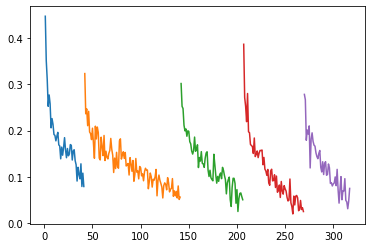

In [33]:
loss_plot(ewc_total_loss_dropout_lambda_big)

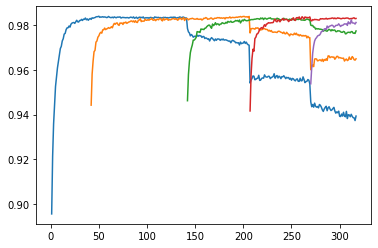

In [34]:
accuracy_plot(ewc_prec_dropout_lambda_big)